# P7 Credit Risk (models)
**Présentation du projet**
- Sujet : aide à la décision concernant l'octroi de crédit 
- Objectif : prédire les personnes qui risquent d'être en défaut de paiement en fonction de leur comportement dans le passé
- Data : historique des donnéées comportementales sur les crédits qui précèdent la demande actuelle des clients 
- Problématique : classification supervisée qui retourne un score qui mesure la probabilité que le client appartienne à la classe possitive (client risqué)

**Mise en oeuvre**
- Versionning sous Git/Github
- Baseline (Dummy classifier), choix de la métrique + métrique métier
- Traiter la problématique de déséquilibre des classes (TARGET) : class_weight, SMOTE, under sampling
- Sélectionner les KBest features (entre 20 et 300)
- Optimisation des modèles de classification avec GridserachCV et RandomizedSearchCV
- Tracking MLFlow pour suivre les éxpériences réalisées

**Analyse SHAP**
- Shape des 50 features globales les + impactantes sur la target
- Shape des 50 features locales (pour 1 demande client donnée)

# Modelling

## Import packages

In [4]:
# In-built general packages
import os
import tempfile
from datetime import datetime
import re # traitement des caractères spéciaux

# Data manipulation
import numpy as np
import pandas as pd

# Data Viz
import matplotlib.pyplot as plt
import seaborn as sns

# Pre-processing & pipeline
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.feature_selection import SelectKBest, f_classif
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler

from sklearn.pipeline import make_pipeline, Pipeline
from imblearn.pipeline import Pipeline as imbpipeline

# Models
from sklearn.dummy import DummyClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC # efficace sur les datasets de petites et moyennes tailles 
from sklearn.ensemble import RandomForestClassifier
from lightgbm import LGBMClassifier

# Models optimization
from sklearn.model_selection import learning_curve # identification de l'over/under fitting
from sklearn.model_selection import KFold, StratifiedKFold # stratégies de classification
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV

# Metrics
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.metrics import accuracy_score, recall_score, precision_score, f1_score, fbeta_score, make_scorer
from sklearn.metrics import roc_curve, roc_auc_score, auc, precision_recall_curve, average_precision_score

# Compactage des modèles au format pickle
import pickle

# MLFlow : Indsutrialisation et monitoring des expériences d'optimisation des modèles
import mlflow
import mlflow.sklearn
import logging
from urllib.parse import urlparse

logging.basicConfig(level=logging.WARN)
logger = logging.getLogger(__name__)

# Warnings management
import warnings
warnings.simplefilter(action='ignore')

#######################################################
## import à l'origine dans EDA 
#######################################################
# In-built general packages
#import gc # Garbage Collector pour supprimer de l'utilisation mémoire
#import time
#from contextlib import contextmanager

# Data imputing
#from sklearn.impute import SimpleImputer

# Data encoding (variables catégorielles)
#from sklearn.preprocessing import LabelEncoder, OneHotEncoder

## Load dataset

In [2]:
# Lecture du fichier des data
df = pd.read_csv('df_scenario_0.csv')
df.drop('Unnamed: 0', axis=1, inplace=True)
print(f'Dimensions : {df.shape}')

Dimensions : (356251, 803)


In [3]:
# Fonctions de nettoyage des NaN du dataset
# Nettoyage des valeurs NaN et des noms de colonnes contenant des caractères spéciaux
# Fill NaN --> 0 : correspond aux valeurs sans correspondance dans les jointures gauche (left join)
def fct_clean_data(df):
    # Fill NaN par 0
    feat = [v for v in list(df.columns) if v != 'TARGET']
    df[feat] = df[feat].fillna(0, axis=0)

    # Bug : "[LightGBM] Do not support special JSON characters in feature name"
    # Correction : suppression des caractères spéciaux ' ', ','... dans le nom des colonnes
    new_names = {col: re.sub(r'[^A-Za-z0-9_]+', '', col) for col in df.columns}
    new_names_list = list(new_names.values())
    
    # Nom des colonnes unique : ajout du suffix i si le nom de la colonne apparaît plus d'1 fois après suppression des caractères spéciaux
    new_names = {col: f'{new_col}_{i}' if new_col in new_names_list[:i] else new_col for i, (col, new_col) in enumerate(new_names.items())}
    df.columns = new_names.values()

    # Retourne le dataframe nettoyé
    return df

# Remplacement des NaN par 0 pour les colonnes aggrégats sans correspondance dans la table gauche jointe (df)
# Utilisé dans le preprocessing des fichiers/tables après chaque jointure gauche effectuée.
# A distinguer du traitement général des NaN, effectué au niveau du fichier/table Application
"""
Paramètres :
- df : dataframe qui correspond à la table cible de la jointure gauche des aggrégats
- cols_agg : liste des colonnes aggrégats
- title : nom de l'aggrégation effectuée
Output:
- df : dataframe dont les valeurs NaN des colonnes aggrégées ont été remplacées
       par 0 pour indiquer que l'indicateur n'existe pas.
"""
def fct_fillna_agg(df, cols_agg, title):
    print(f"\nAggrégat {title} - nombre de NaN (suite aux left join) à remplacer par 0 :\n{(df[cols_agg].isna().sum()).sort_values(ascending=False)}\n")
    df[cols_agg] = df[cols_agg].fillna(value=0, axis=0)
    print(f"Nombre de NaN restant : {df[cols_agg].isna().sum().sum()}")
    return df

In [4]:
# Nettoyage des data
df2 = df.copy()
df2 = df2[~df2['TARGET'].isna()] # TARGET=0/1
df2 = fct_clean_data(df2)

In [5]:
# Distribution par TARGET
print(df2.shape)
print(df2['TARGET'].value_counts())

(307507, 803)
0.0    282682
1.0     24825
Name: TARGET, dtype: int64


In [6]:
# Test missing data 
df_missing = pd.DataFrame((df2.isna().mean()*100).sort_values(ascending=False), columns=['missing_%'])
df_missing = df_missing[df_missing['missing_%'] > 80]
print(f"Check NaN :\n{df_missing}")
feats = df_missing.head(20).index.tolist()
print('-'*50)
print(f'Missing Top 20 features :\n{feats}')

Check NaN :
Empty DataFrame
Columns: [missing_%]
Index: []
--------------------------------------------------
Missing Top 20 features :
[]


## Pre-processing
- Mode debug pour tester l'optimisation des modèles sur 1 échantillon réduit à 2000 individus avant de passer à la taille réelle

In [12]:
# Mode debug : échantillon de 2000 individus en conservant la proportion des 2 classes
debug=True

In [13]:
if debug:
    # Proportion des classes
    prop_class_0 = df2[df2['TARGET']==0].shape[0]/df2.shape[0]
    df_class_0 = df2[df2['TARGET']==0].iloc[:int(2000*prop_class_0)]
    df_class_1 = df2[df2['TARGET']==1].iloc[:int(2000*(1-prop_class_0))]
    df2 = pd.concat([df_class_0, df_class_1], ignore_index=True, axis=0)
    print(f'Dimension mode débug : {df2.shape}')
    print(f"Proportions des classes en % :\n{df2['TARGET'].value_counts()/df2.shape[0]*100}")

Dimension mode débug : (1999, 803)
Proportions des classes en % :
0.0    91.945973
1.0     8.054027
Name: TARGET, dtype: float64


In [13]:
# Split du TRAIN set en TRAIN/TEST sets
df_train, df_test = train_test_split(df2, test_size=0.20, stratify=df2['TARGET'], random_state=0)

print(f'Dimension Train set : {df_train.shape}')
print(f'Dimension Test set : {df_test.shape}')

Dimension Train set : (246005, 803)
Dimension Test set : (61502, 803)
TRAIN set : Fill NaN par 0...
Nb de lignes NaN : 0
TRAIN set - distribution par classe :
0.0    226135
1.0     19858
Name: TARGET, dtype: int64
TEST set : Fill NaN par 0...
Nb de lignes NaN : 0
TEST set - distribution par classe :
0.0    56530
1.0     4965
Name: TARGET, dtype: int64
Dimension Train set : (245993, 802)
Dimension Test set : (61495, 802)


In [12]:
# Imputation
def fct_impute(df, dataset):
    print(f'{dataset} set : Fill NaN par 0...')
    df = df.fillna(0, axis=0) # ou par la moyenne
    #df.dropna(axis=0, inplace=True)

    # Suppression des valeurs infinies positives/négatives définies dans Numpy
    # car message d'erreur lors du fit : "ValueError Input X contains infinity or a value too large for dtype('float64')"
    df = df[~df.isin([np.inf, -np.inf]).any(1)]
    
    #Test missing data 
    df_missing = pd.DataFrame((df.isna().mean()*100).sort_values(ascending=False), columns=['missing_%'])
    df_missing = df_missing[df_missing['missing_%'] > 0]
    print(f"Nb de lignes NaN : {df_missing.shape[0]}")
    
    feats = df_missing.head(3).index.tolist()
    if len(feats) > 0 :
        print('-'*50)
        print(f'Top 3 Missing features :\n{feats}')
    return df

# Séparation features X / target y + format Numpy
def fct_preprocessing(df, dataset):
    # Encodage déjà fait
    # Imputation (NaN)
    df = fct_impute(df, dataset)
    X = df.drop('TARGET', axis=1).values
    y = df['TARGET'].values
    y = y.reshape(y.shape[0], 1)
    # Vérification que l'on a bien la même distribution des individus par classe pour le TRAIN et TEST set
    print(f"{dataset} set - distribution par classe :\n{df['TARGET'].value_counts()}")
    return X, y

In [ ]:
# Data pre-processing
X_train, y_train = fct_preprocessing(df_train, 'TRAIN')
X_test, y_test = fct_preprocessing(df_test, 'TEST')

# Normalisation standard pour SVM (PAS BESOIN) 
#scaler = StandardScaler()
#X_train_std = scaler.fit_transform(X_train)
#X_test_std = scaler.transform(X_test) 

print(f'Dimension Train set : {X_train.shape}')
print(f'Dimension Test set : {X_test.shape}')

## Baseline


Score accuracy : 0.920
Precision_score : 0.000
Recall_score : 0.000
f1_score : 0.000
AUC Roc score : 0.500

Matrice de confusion :
[[368   0]
 [ 32   0]]


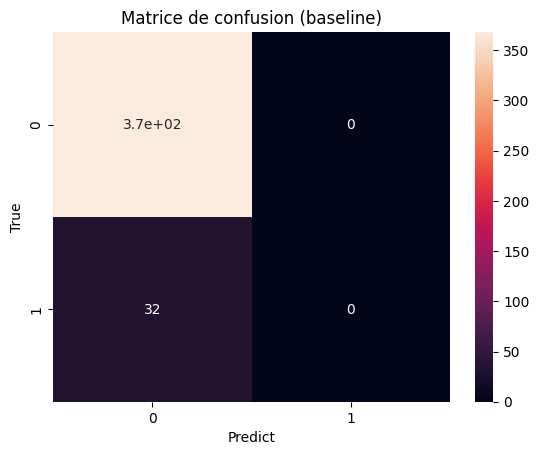

In [15]:
# Modèle de classification baseline 

# Plusieurs stratégies pour le modèle baseline
dummy_clf = DummyClassifier(strategy='most_frequent', random_state=0) # prédit toujours la classe la + fréquente indépendamment de X
dummy_clf.fit(X_train, y_train)
y_pred = dummy_clf.predict(X_test)

# Scores
#for strategy in ['most_frequent', '', '']
score_accuracy = dummy_clf.score(X_test, y_test)
print(f'\nScore accuracy : {score_accuracy:.3f}')
#print(f'Score accuracy 2 : {accuracy_score(y_test, y_pred):.3f}')
print(f'Precision_score : {precision_score(y_test, y_pred):.3f}')
print(f'Recall_score : {recall_score(y_test, y_pred):.3f}')
print(f'f1_score : {f1_score(y_test, y_pred):.3f}')
print(f'AUC Roc score : {roc_auc_score(y_test, y_pred):.3f}')

# Graphe P/R/F1-score --> TO DO !!!
# F1-score dépend du seuil de classification (par défaut seuil=50% pour les prédictions)
# Matrice de confusion
conf_matrix = confusion_matrix(y_test, y_pred)
print(f'\nMatrice de confusion :\n{conf_matrix}')
sns.heatmap(conf_matrix, annot=True, cbar=True)
plt.title ('Matrice de confusion (baseline)')
plt.xlabel('Predict')
plt.ylabel('True')
plt.show()

Observations
- Accuracy = 92%, correspond au taux de prédiction correct
- Cependant ici on ne prédit que la classe négative (0) majoritaire (92% de l'échantillon)

Conclusion
- **l'accuracy ne permet pas de mesurer la capacité du modèle** à prédire les cas positifs (défaut de paiement)
- **Le ROC score** = 0.5 est plus pertinent
- **le déséquilibre** entre les 2 classes est très important 


## Models

In [16]:
# Exemples de modèles de classification
log = LogisticRegression(random_state=0) # modèle linéaire
svc = SVC(kernel = 'rbf', probability=True, random_state=0) # modèle non linéaire : SVM avec noyau gaussien
rfc = RandomForestClassifier(n_estimators=200, random_state=0) # modèle de bagging
lgbm = LGBMClassifier(random_state=0) # modèle de boosting

dict_models = {}
dict_models['baseline'] = dummy_clf
dict_models['log'] = log
dict_models['svc'] = svc
dict_models['rfc'] = rfc 
dict_models['lgbm'] = lgbm

# Modèle rfc : (n_estimators=200, max_depth=None , min_samples_leaf=1, min_weight_fraction_leaf=0,0, max_leaf_nodes=?)

## Evaluation
- Ici on cherche à évaluer la performance de chacun de nos 4 modèles de classification avec les paramètres par défaut

In [18]:
# Fonctions d'évaluation de la performance des modèles de classification
# Renvoit : 
# - AUC score + F1 score (bon compromis entre le Recall et la Précision)
# - Matrice de confusion pour évaluer la proportion de faux + et de faux -
# - La courbe d'apprentissage
def fct_evaluation(model, X_train, X_test):
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    #y_score_pred = model.decision_function(X_test)
    y_score_pred = model.predict_proba(X_test)[:, 1] # supporté par tous les modèles
    
    conf_matrix = confusion_matrix(y_test, y_pred)
    plt.figure(figsize=(3,3)) 
    sns.heatmap(conf_matrix, annot=True, cbar=True)
    plt.title ('Matrice de confusion (model)')
    plt.xlabel('Predict')
    plt.ylabel('True')
    plt.show()

    print(f"Rapport de classification :\n{classification_report(y_test, y_pred)}")
    print(f'f1_score : {f1_score(y_test, y_pred):.3f}')
    print(f'AUC Roc score : {roc_auc_score(y_test, y_score_pred):.3f}')

    # Learning curve pour identifier si over ou under fitting
    n, train_score, val_score = learning_curve(model, X_train, y_train, 
                                               cv=3, 
                                               scoring='f1',
                                               train_sizes=np.linspace(0.1, 1, 10)
    )
    
    plt.figure(figsize=(10,8))
    plt.plot(n, train_score.mean(axis=1), label='train score')
    plt.plot(n, val_score.mean(axis=1), label='validation score')
    plt.title("Courbe d\'apprentissage (f1-score)")
    plt.legend()
    plt.show()

In [16]:
def fct_evaluation_2(model):
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    #y_score_pred = model.decision_function(X_test)
    y_score_pred = model.predict_proba(X_test)[:, 1] # supporté par tous les modèles
    
    conf_matrix = confusion_matrix(y_test, y_pred)
    plt.figure(figsize=(3,3)) 
    sns.heatmap(conf_matrix, annot=True, cbar=True)
    plt.title ('Matrice de confusion (model)')
    plt.xlabel('Predict')
    plt.ylabel('True')
    plt.show()

    print(f"Rapport de classification :\n{classification_report(y_test, y_pred)}")
    print(f'f1_score : {f1_score(y_test, y_pred):.3f}')
    print(f'AUC Roc score : {roc_auc_score(y_test, y_score_pred):.3f}')

In [19]:
# Définition d'une métrique spécifique adaptée aux besoins du métier
""" L'objectif est de définir une métrique métier adaptée à notre problématique, qui permet de : 
- minimiser les FN (nombre d'octroi de crédit a de mauvais payeurs = perte financière)
- minimiser les FP (nombre de refus de crédit a de bons payeurs = manque à gagner)

On commence par un poids de 0.5 pour FN et FP 
- on fait varier ce poids pour FN : 0.5 --> 0.3 --> 0.1
- on fait varier ce poids pour FP : 0.5 --> 0.7 --> 0.9
- on compare les résultats des matrices de confusion
"""
def fct_custom_metric(y, y_pred):
    weight={'FN':0.1, 'FP':0.9}
    df_tmp = pd.DataFrame(data={'y' : y[:,0], 'y_pred' : y_pred })
    # Negative
    FN = df_tmp[(df_tmp['y_pred']==0) & (df_tmp['y']==1)].shape[0]
    TN = df_tmp[(df_tmp['y_pred']==0) & (df_tmp['y']==0)].shape[0]
    N = df_tmp[df_tmp['y']==0].shape[0]
    # Positive
    TP = df_tmp[(df_tmp['y_pred']==1) & (df_tmp['y']==1)].shape[0]
    FP = df_tmp[(df_tmp['y_pred']==1) & (df_tmp['y']==0)].shape[0]
    P = df_tmp[df_tmp['y']==1].shape[0]
    # FNR : False Negative Ratio (taux d'omission des cas +)
    FNR = FN/P
    # FPR : False Positive Ratio (taux de sur-prédiction des cas +)
    FPR = FP/N
    # Custom metric
    FNFPR_score = (weight['FN']*FNR) + (weight['FP']*FPR)
    return FNFPR_score

# La métrique FNFPR_score doit être la + petite possible 
custom_score = make_scorer(fct_custom_metric, greater_is_better=False)

# Métriques custom_score, f1-score et auc-score après avoir entraîné le modèle
def fct_eval_metrics(model, X_test, y_test, flag_graph=True):
    y_pred = model.predict(X_test)
    y_score_pred = model.predict_proba(X_test)[:, 1] # supporté par tous les modèles

    # Métriques
    score_f1 = round(f1_score(y_test, y_pred),3)
    score_auc = round(roc_auc_score(y_test, y_score_pred),3)
    score_custom = round(fct_custom_metric(y_test, y_pred), 3)
    print(f'f1_score : {score_f1}')
    print(f'custom_score : {score_custom}')
    print(f'AUC_Roc_score : {score_auc}') 

    if flag_graph:
        # Heatmap de la matrice de consusion
        conf_matrix = confusion_matrix(y_test, y_pred)
        plt.figure(figsize=(3,3)) 
        sns.heatmap(conf_matrix, annot=True, cbar=True)
        plt.title ('Matrice de confusion (model)')
        plt.xlabel('Predict')
        plt.ylabel('True')
        plt.show()

        # Rapport de classification
        print(f"Rapport de classification :\n{classification_report(y_test, y_pred)}")

    # Retourne les métrics f1, auc
    return score_f1, score_auc 

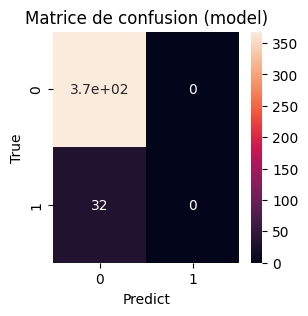

Rapport de classification :
              precision    recall  f1-score   support

         0.0       0.92      1.00      0.96       368
         1.0       0.00      0.00      0.00        32

    accuracy                           0.92       400
   macro avg       0.46      0.50      0.48       400
weighted avg       0.85      0.92      0.88       400

f1_score : 0.000
AUC Roc score : 0.500


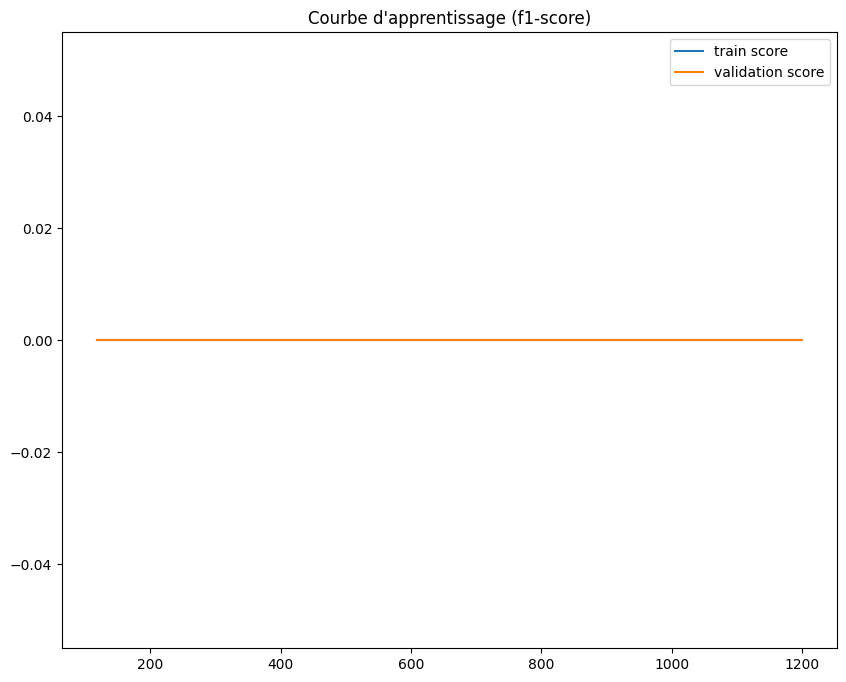

In [20]:
# Evaluation du modèle de référence (baseline)
fct_evaluation(dummy_clf, X_train, X_test)

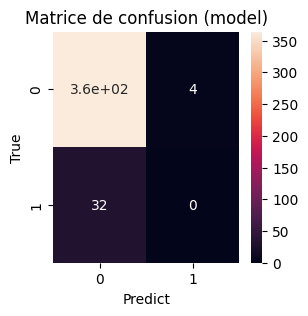

Rapport de classification :
              precision    recall  f1-score   support

         0.0       0.92      0.99      0.95       368
         1.0       0.00      0.00      0.00        32

    accuracy                           0.91       400
   macro avg       0.46      0.49      0.48       400
weighted avg       0.85      0.91      0.88       400

f1_score : 0.000
AUC Roc score : 0.506


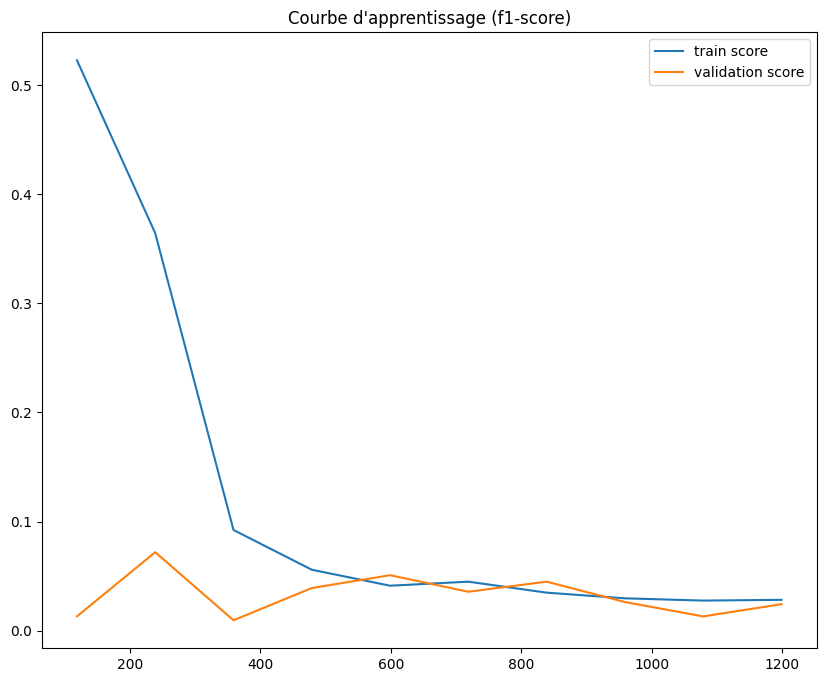

AUC = 0.5061990489130435, AUC2 = 0.5061990489130435


In [197]:
# Evaluation du modèle de Regression Logistique (log) 
fct_evaluation(log, X_train, X_test)

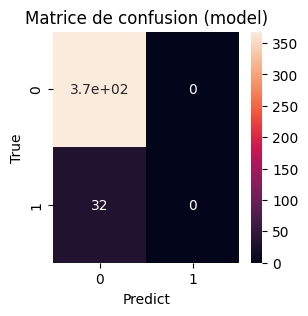

Rapport de classification :
              precision    recall  f1-score   support

         0.0       0.92      1.00      0.96       368
         1.0       0.00      0.00      0.00        32

    accuracy                           0.92       400
   macro avg       0.46      0.50      0.48       400
weighted avg       0.85      0.92      0.88       400

f1_score : 0.000
AUC Roc score : 0.683


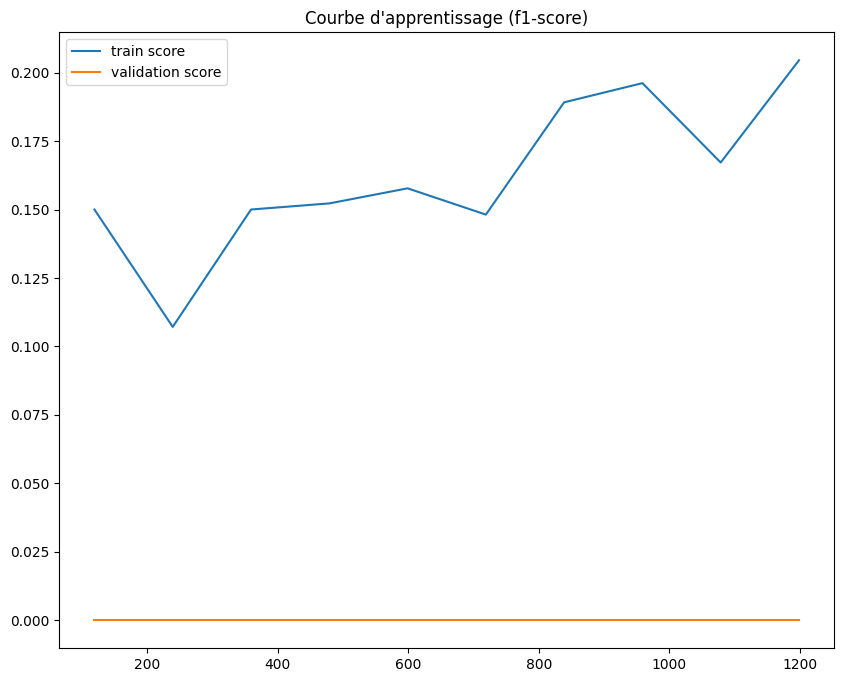

'\nfrom sklearn.metrics import auc\ny_score_pred = svc.predict_proba(X_test_std)[:,1] \nfpr, tpr, thr = roc_curve(y_test, y_score_pred)\nauc = auc(fpr, tpr)\n#auc_2 = roc_auc_score(y_test, y_score_pred) # auc_2 = auc\nprint(f"AUC = {auc}, AUC2 = {auc_2}")\n'

In [198]:
# Evaluation du modèle de Support Vector Machine Classifier (svc)
# Mise à l'echelle standard au préalable pour le modèle SVM 
scaler = StandardScaler()
X_train_std = scaler.fit_transform(X_train)
X_test_std = scaler.transform(X_test) 
fct_evaluation(svc, X_train_std, X_test_std)

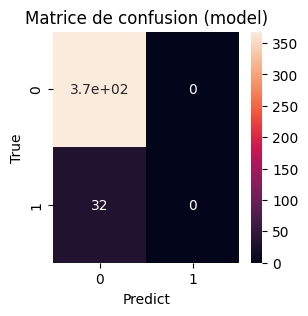

Rapport de classification :
              precision    recall  f1-score   support

         0.0       0.92      1.00      0.96       368
         1.0       0.00      0.00      0.00        32

    accuracy                           0.92       400
   macro avg       0.46      0.50      0.48       400
weighted avg       0.85      0.92      0.88       400

f1_score : 0.000
AUC Roc score : 0.654


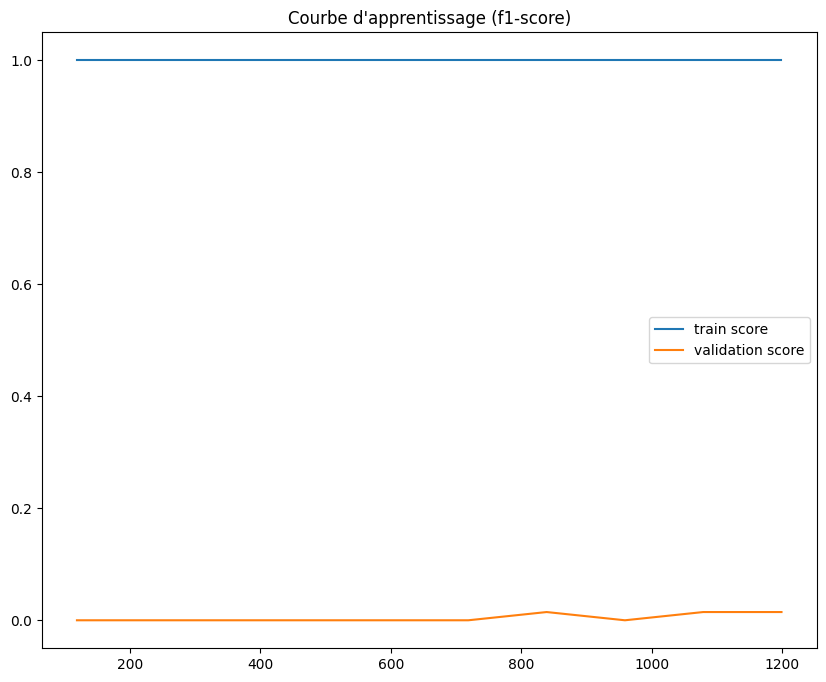

In [199]:
# Evaluation du modèle Random Forest Classifier
fct_evaluation(rfc, X_train, X_test)

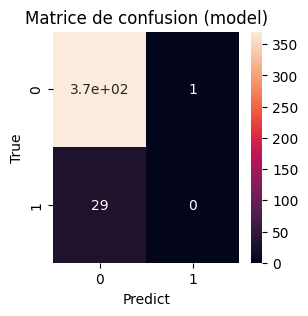

Rapport de classification :
              precision    recall  f1-score   support

         0.0       0.93      1.00      0.96       371
         1.0       0.00      0.00      0.00        29

    accuracy                           0.93       400
   macro avg       0.46      0.50      0.48       400
weighted avg       0.86      0.93      0.89       400

f1_score : 0.000
AUC Roc score : 0.700


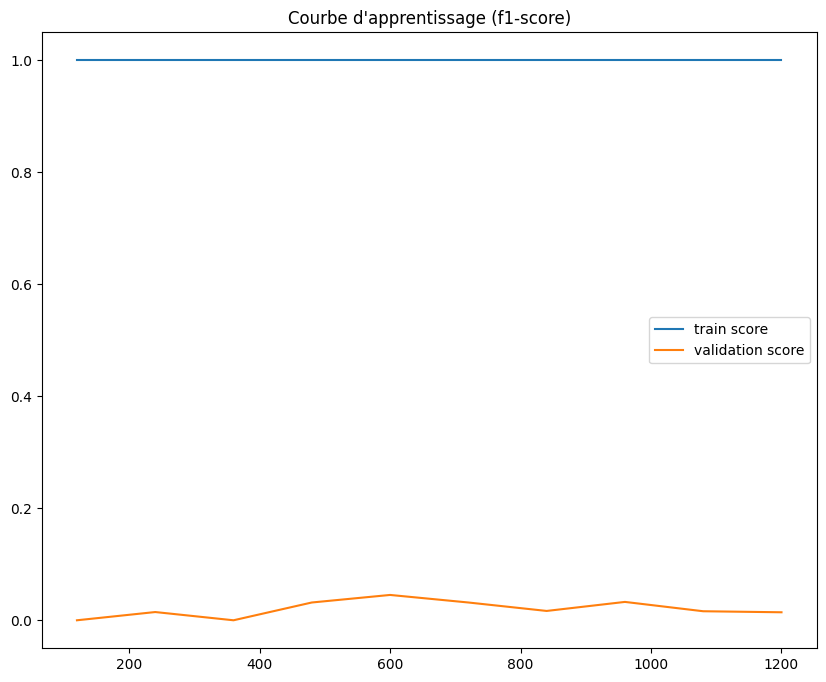

In [282]:
# Evaluation du modèle light_GBM
fct_evaluation(lgbm, X_train, X_test)

In [138]:
# Expériences à tester avec MLFlow Tracking : 
# - Réduire les dimensions parmi les 800 :
#   - option 1 : feature selection avec SelectKBest (ANOVA : basé sur les stat de dépendance avec la target)
# - Equilibrage des classes pour éviter l'overfitting sur la classe majoritaire et l'underfitting sur la classe minoritaire :
#   - option 2 : réglage hyperparamètre class_weight
#   - option 3 : over sampling (SMOTE) / under sampling / combinaison over/under
# - Optimisation des hyper paramètres du classifieur

--------------------------------------------------
Model : Dummy Classifier
f1_score : 0.0
AUC_Roc_score : 0.5


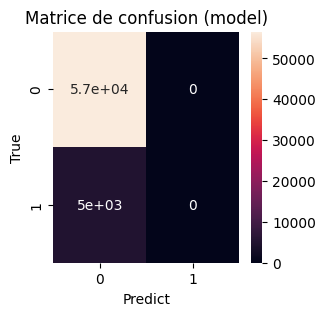

Rapport de classification :
              precision    recall  f1-score   support

         0.0       0.92      1.00      0.96     56530
         1.0       0.00      0.00      0.00      4965

    accuracy                           0.92     61495
   macro avg       0.46      0.50      0.48     61495
weighted avg       0.85      0.92      0.88     61495

--------------------------------------------------
Model : Regression Logistic
f1_score : 0.0
AUC_Roc_score : 0.625


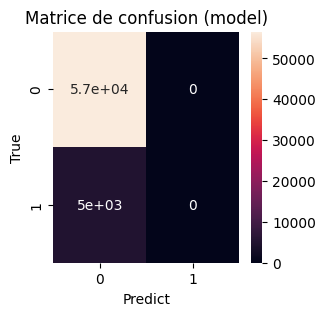

Rapport de classification :
              precision    recall  f1-score   support

         0.0       0.92      1.00      0.96     56530
         1.0       0.00      0.00      0.00      4965

    accuracy                           0.92     61495
   macro avg       0.46      0.50      0.48     61495
weighted avg       0.85      0.92      0.88     61495

--------------------------------------------------
Model : Support Vector


In [19]:
# Option 1 : pipeline pour optimiser la sélection des features (Kbest)

# Pipeline de pre-processing des data : sélection des features
# k = 28 : Racine_carrée(800 features)
# Sélection de 28 variables qui ont les liens les + forts avec la TARGET (en terme de test ANOVA)
preprocessor = make_pipeline(SelectKBest(f_classif, k=28)) # pas de 50 : de 25 à 300

# Pipeline de chaque modèle avec leurs paramètres de bases, incluant l'étape initiale de pre-processing 
pip_baseline = make_pipeline(preprocessor, dummy_clf)
pip_log = make_pipeline(preprocessor, log)
pip_svc = make_pipeline(StandardScaler(), preprocessor, svc)
pip_rfc = make_pipeline(preprocessor, rfc)
pip_lgbm = make_pipeline(preprocessor, lgbm)

# Dictionnaire des pipelines des modèles
pip_models = {'Dummy Classifier' : pip_baseline,
              'Regression Logistic' : pip_log,
              'Support Vector' : pip_svc,
              'Random Forest' : pip_rfc,
              'Light GBM' : pip_lgbm}

for model_name, model in pip_models.items() :
    print('-'*50)
    print(f'Model : {model_name}')
    model.fit(X_train, y_train)
    score_f1, score_auc = fct_eval_metrics(model, X_test, y_test)

## OLD MLflow

In [5]:
# Test le répertoire local courant pour le stockage des logs
mlflow.get_tracking_uri()

'file:///c:/Users/fabri/OneDrive/Documents/Fabrice/Formations/OpenClassRooms_Data_Scientist/3%20Projets/P7/livrables/mlruns'

Experiment_id: 354286291553329892
Artifact Location: mlflow-artifacts:/354286291553329892
Tags: {}
Lifecycle_stage: active
--------------------------------------------------
Model : baseline
f1_score : 0.0
AUC_Roc_score : 0.5


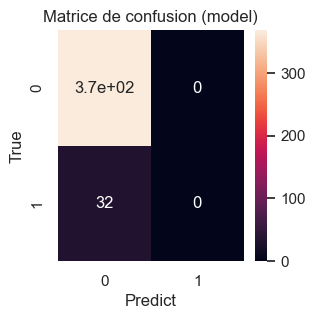

Rapport de classification :
              precision    recall  f1-score   support

         0.0       0.92      1.00      0.96       368
         1.0       0.00      0.00      0.00        32

    accuracy                           0.92       400
   macro avg       0.46      0.50      0.48       400
weighted avg       0.85      0.92      0.88       400

tracking_url_type : http


Registered model 'baseline' already exists. Creating a new version of this model...
2023/03/08 18:14:33 INFO mlflow.tracking._model_registry.client: Waiting up to 300 seconds for model version to finish creation.                     Model name: baseline, version 6
Created version '6' of model 'baseline'.


--------------------------------------------------
Model : log
f1_score : 0.0
AUC_Roc_score : 0.506


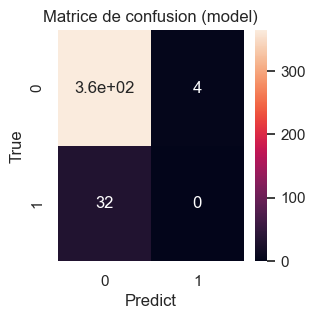

Rapport de classification :
              precision    recall  f1-score   support

         0.0       0.92      0.99      0.95       368
         1.0       0.00      0.00      0.00        32

    accuracy                           0.91       400
   macro avg       0.46      0.49      0.48       400
weighted avg       0.85      0.91      0.88       400

tracking_url_type : http


Registered model 'log' already exists. Creating a new version of this model...
2023/03/08 18:14:36 INFO mlflow.tracking._model_registry.client: Waiting up to 300 seconds for model version to finish creation.                     Model name: log, version 6
Created version '6' of model 'log'.


--------------------------------------------------
Model : svc
f1_score : 0.0
AUC_Roc_score : 0.683


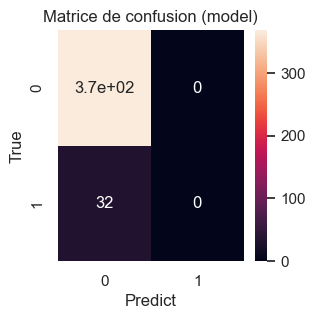

Rapport de classification :
              precision    recall  f1-score   support

         0.0       0.92      1.00      0.96       368
         1.0       0.00      0.00      0.00        32

    accuracy                           0.92       400
   macro avg       0.46      0.50      0.48       400
weighted avg       0.85      0.92      0.88       400

tracking_url_type : http


Registered model 'svc' already exists. Creating a new version of this model...
2023/03/08 18:14:41 INFO mlflow.tracking._model_registry.client: Waiting up to 300 seconds for model version to finish creation.                     Model name: svc, version 6
Created version '6' of model 'svc'.


--------------------------------------------------
Model : rfc
f1_score : 0.0
AUC_Roc_score : 0.654


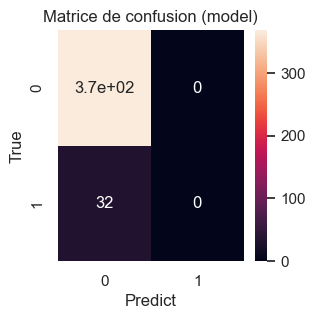

Rapport de classification :
              precision    recall  f1-score   support

         0.0       0.92      1.00      0.96       368
         1.0       0.00      0.00      0.00        32

    accuracy                           0.92       400
   macro avg       0.46      0.50      0.48       400
weighted avg       0.85      0.92      0.88       400

tracking_url_type : http


Registered model 'rfc' already exists. Creating a new version of this model...
2023/03/08 18:14:46 INFO mlflow.tracking._model_registry.client: Waiting up to 300 seconds for model version to finish creation.                     Model name: rfc, version 6
Created version '6' of model 'rfc'.


--------------------------------------------------
Model : lgbm
f1_score : 0.111
AUC_Roc_score : 0.679


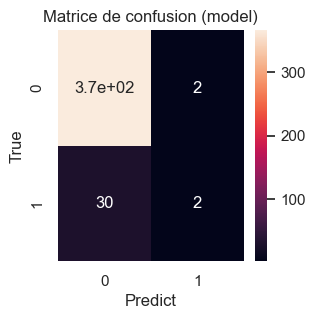

Rapport de classification :
              precision    recall  f1-score   support

         0.0       0.92      0.99      0.96       368
         1.0       0.50      0.06      0.11        32

    accuracy                           0.92       400
   macro avg       0.71      0.53      0.53       400
weighted avg       0.89      0.92      0.89       400



MlflowException: INVALID_PARAMETER_VALUE: Changing param values is not allowed. Param with key='max_depth' was already logged with value='None' for run ID='f67ed32f075744c094597de547bdb8c3'. Attempted logging new value '-1'.

The cause of this error is typically due to repeated calls
to an individual run_id event logging.

Incorrect Example:
---------------------------------------
with mlflow.start_run():
    mlflow.log_param("depth", 3)
    mlflow.log_param("depth", 5)
---------------------------------------

Which will throw an MlflowException for overwriting a
logged parameter.

Correct Example:
---------------------------------------
with mlflow.start_run():
    with mlflow.start_run(nested=True):
        mlflow.log_param("depth", 3)
    with mlflow.start_run(nested=True):
        mlflow.log_param("depth", 5)
---------------------------------------

Which will create a new nested run for each individual
model and prevent parameter key collisions within the
tracking store.'

In [347]:
# OLD MLFLOW TRACKING : 
# Objectif : tracking des 4 modèles avec paramètres par défaut dans 1 seule expérience pour comparaison des performances (803 features)
# Bug car logging de paramètres différents pour les modèles
# --> Solution : supprimer les paramètres et n'afficher que le résultat (métrique f1-score)

"""
# Paramètres des modèles à traquer
params={}
params['baseline']=['strategy']
params['log']=['class_weight', 'C']
params['svc']=['class_weight', 'C', 'gamma']
params['rfc']=['class_weight', 'max_depth', 'min_samples_leaf'] # estimtors = [200, 500]
params['lgbm']=['learning_rate', 'max_depth', 'subsample'] # estimtors = [200, 500], subsample entre 0 et 1 : [0.5,1], max_deph : [2,5,10]
# Kbest : range(20, 300, 20)

# Serveur local du suivi MLflow
#mlflow.set_tracking_uri("http://127.0.0.1:5000")
mlflow.set_tracking_uri("http://localhost:5000") 

# Nom de l'expérience, which must be unique and case-sensitive.
experiment = mlflow.set_experiment("experiment_1")
#experiment_id = mlflow.create_experiment("experiment1")

# Get Experiment Details
print(f"Experiment_id: {experiment.experiment_id}")
print(f"Artifact Location: {experiment.artifact_location}")
print(f"Tags: {experiment.tags}")
print(f"Lifecycle_stage: {experiment.lifecycle_stage}")

# Start logging
with mlflow.start_run():
    for model_name, model in dict_models.items() :
        print('-'*50)
        print(f'Model : {model_name}')
        if model_name == 'svc':
            model.fit(X_train_std, y_train)
            score_f1, score_auc = fct_eval_metrics(model, X_test_std, y_test)
        else:
            model.fit(X_train, y_train)
            score_f1, score_auc = fct_eval_metrics(model, X_test, y_test)
        
        for i in range(len(params[model_name])) :
            param = params[model_name][i] 
            mlflow.log_param(param, model.get_params()[param])
        
        mlflow.log_metric('score_f1', score_f1)
        mlflow.log_metric('score_auc', score_auc)

        tracking_url_type_store = urlparse(mlflow.get_tracking_uri()).scheme
        print(f'tracking_url_type : {tracking_url_type_store}') # "http"

        # Model registry does not work with file store
        if tracking_url_type_store != "file":
            # Register the model
            # There are other ways to use the Model Registry, which depends on the use case,
            # please refer to the doc for more information:
            # https://mlflow.org/docs/latest/model-registry.html#api-workflow
            mlflow.sklearn.log_model(model, 'model', registered_model_name=model_name)
        else:
            mlflow.sklearn.log_model(model, 'model')     
"""

# Optimization (debug : 2000 échantillons)
- Pre-processing : features selection (Kbest)
- SMOTE et under sampling pour le rééquilibrage des classes :
    sur-échantillonnage de la classe minoritaire
    sous échantillonnage de la classe majoritaire
    mixte des 2
- Hyperparamètres du classifier

### MLFlow
- fonctions MLFlow pour tracking des experiences de modèles via GridSearchCV vers URL et File

In [27]:
def log_run(gridsearch, experiment_name, model_name, run_index, tags={}, grid_type='GridSearchCV'):
    """Logging of cross validation results to mlflow tracking server
    
    Args:
        experiment_name (str): experiment name
        model_name (str): Name of the model
        run_index (int): Index of the run (in Gridsearch)
        conda_env (str): A dictionary that describes the conda environment (MLFlow Format)
        tags (dict): Dictionary of extra data and tags (usually features)
        grid_type: Type of the grid (GridSearchCV or RamdomizedSearchCV)
    """
    
    cv_results = gridsearch.cv_results_
    with mlflow.start_run(run_name=str(run_index)) as run:  

        mlflow.log_param("folds", gridsearch.cv)

        print("Logging parameters")
        # GridSearchCV
        if grid_type=='GridSearchCV':
            params = list(gridsearch.param_grid.keys())
        # RandomizedSearchCV
        else:
            params = list(gridsearch.param_distributions)
        for param in params:
            mlflow.log_param(param, cv_results["param_%s" % param][run_index])

        print("Logging metrics")
        for score_name in [score for score in cv_results if "mean_test" in score]:
            mlflow.log_metric(score_name, cv_results[score_name][run_index])
            mlflow.log_metric(score_name.replace("mean","std"), cv_results[score_name.replace("mean","std")][run_index])

        print("Logging model")        
        mlflow.sklearn.log_model(gridsearch.best_estimator_, model_name)

        print("Logging CV results matrix")
        tempdir = tempfile.TemporaryDirectory().name
        os.mkdir(tempdir)
        timestamp = datetime.now().isoformat().split(".")[0].replace(":", ".")
        filename = "%s-%s-cv_results.csv" % (model_name, timestamp)
        csv = os.path.join(tempdir, filename)
        with warnings.catch_warnings():
            warnings.simplefilter("ignore")
            pd.DataFrame(cv_results).to_csv(csv, index=False)
        
        mlflow.log_artifact(csv, "cv_results") 

        print("Logging extra data related to the experiment")
        mlflow.set_tags(tags) 

        run_id = run.info.run_uuid
        experiment_id = run.info.experiment_id
        mlflow.end_run()
        print(mlflow.get_artifact_uri())
        print("runID: %s" % run_id)


def log_results(gridsearch, experiment_name, model_name, tags={}, log_only_best=False, grid_type='GridSearchCV'):
    """Logging of cross validation results to mlflow tracking server
    
    Args:
        experiment_name (str): experiment name
        model_name (str): Name of the model
        tags (dict): Dictionary of extra tags
        log_only_best (bool): Whether to log only the best model in the gridsearch or all the other models as well
        grid_type: Type of the grid (GridSearchCV or RamdomizedSearchCV)
    """
    best = gridsearch.best_index_
    #mlflow.set_tracking_uri("./mlruns")
    mlflow.set_tracking_uri("http://localhost:5000") # suivi MLFlow via UI (serveur local) 
    mlflow.set_experiment(experiment_name)
    if(log_only_best):
        log_run(gridsearch, experiment_name, model_name, best, tags)
    else:
        for i in range(len(gridsearch.cv_results_['params'])):
            log_run(gridsearch, experiment_name, model_name, i, tags, grid_type=grid_type)

In [28]:
# Initialisation du tracking/logging sur le serveur localhost (127.0.0.1) et port 5000 (MLFlow UI)
#mlflow.set_tracking_uri('./mlruns')
mlflow.set_tracking_uri("http://localhost:5000")
mlflow.get_tracking_uri()

'http://localhost:5000'

### SVC

#### Balancing optimization
3 Méthodes de rééquilibrage de la distribution par classe (TARGET) :
- « Poids » : affectation d’1 poids sur la classe minoritaire pour mieux apprendre cette classe
- « SMOTE, Over sampling » : création d’échantillon de la classe minoritaire pour rééquilibrer les 2 classes
- « Sub sampling » : suppression d’échantillon de la classe majoritaire pour rééquilibrer les 2 classes

Meilleurs hyperparamètres : {'classifier__class_weight': {0: 0.08777777777777777, 1: 0.9122222222222223}}
CV f1-score : 0.244
f1_score : 0.263
AUC_Roc_score : 0.651


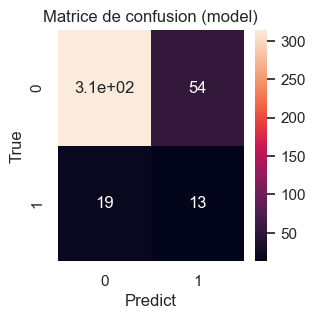

Rapport de classification :
              precision    recall  f1-score   support

         0.0       0.94      0.85      0.90       368
         1.0       0.19      0.41      0.26        32

    accuracy                           0.82       400
   macro avg       0.57      0.63      0.58       400
weighted avg       0.88      0.82      0.85       400



2023/03/09 19:27:04 INFO mlflow.tracking.fluent: Experiment with name 'SVC_01_class_weight' does not exist. Creating a new experiment.


Logging parameters
Logging metrics
Logging model
Logging CV results matrix
Logging extra data related to the experiment
mlflow-artifacts:/884478051083950423/2f7d127d80a847a5abcecaafa0017dc6/artifacts
runID: baf5f94ed87643ffb634b777e416f02e
Logging parameters
Logging metrics
Logging model
Logging CV results matrix
Logging extra data related to the experiment
mlflow-artifacts:/884478051083950423/479b5d286fb74228aad7051f34e2e77a/artifacts
runID: d49affd51e6841b2ab755df952d9e35a
Logging parameters
Logging metrics
Logging model
Logging CV results matrix
Logging extra data related to the experiment
mlflow-artifacts:/884478051083950423/225755ad58bb4a46a82778a7322f8cbd/artifacts
runID: 0a58c3d7f980481ba874a81e18c3219b
Logging parameters
Logging metrics
Logging model
Logging CV results matrix
Logging extra data related to the experiment
mlflow-artifacts:/884478051083950423/f5ffca44fb884db2b06e7ec60574c6ab/artifacts
runID: e038d5f4deb24c1fbe77ad03f705fc2f
Logging parameters
Logging metrics
Loggi

In [62]:
# 1) méthode des poids : hyper paramètre class_weight du classifieur, mesure f1-score
pipeline = Pipeline (steps = [['scaler', StandardScaler()],
                             #['kbest', SelectKBest(f_classif, k=20)],
                             ['classifier', SVC(kernel = 'rbf', 
                                                probability=True,
                                                max_iter=-1,
                                                random_state=10)]
])

# Combinaisons des hyperparamètres
weights = np.linspace(0.080, 0.090, 10) # poids = inversement proportionnel à la distribution / classe
hyper_params = {'classifier__class_weight' : [{0 : x, 1 : 1.0-x} for x in weights]}

# Grille des modèles SVC avec 3 validations croisées
stratified_kfold = StratifiedKFold(n_splits=3, shuffle=True, random_state=10)
grid = GridSearchCV(estimator=pipeline,
                    param_grid=hyper_params,
                    scoring='f1',  # scoring : 'recall'/'f1'/'roc_auc/ fct_metric_business'
                    cv=stratified_kfold,
                    n_jobs=-1)

# Entraînement de la grille
grid.fit(X_train, y_train)

# Evaluation
print(f'Meilleurs hyperparamètres : {grid.best_params_}')
print(f'CV f1-score : {grid.best_score_:.3f}')
score_f1_weight, score_auc_weight = fct_eval_metrics(grid.best_estimator_, X_test, y_test)
#test_score = grid.score(X_test, y_test)

# MLFlow Tracking 
experiment_name = 'SVC_01_class_weight'
log_results(grid, experiment_name, 'SVC')

--------------------------------------------------
Meilleurs hyperparamètres : {'over_sampling__k_neighbors': 7, 'over_sampling__sampling_strategy': 0.5}
CV f1-score : 0.117
f1_score : 0.133
AUC_Roc_score : 0.661


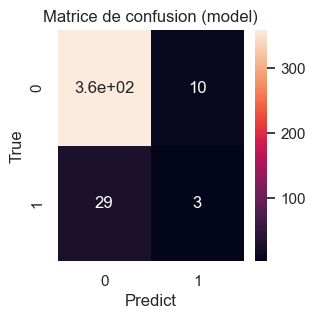

Rapport de classification :
              precision    recall  f1-score   support

         0.0       0.93      0.97      0.95       368
         1.0       0.23      0.09      0.13        32

    accuracy                           0.90       400
   macro avg       0.58      0.53      0.54       400
weighted avg       0.87      0.90      0.88       400



2023/03/09 19:30:24 INFO mlflow.tracking.fluent: Experiment with name 'SVC_02_over_sampling' does not exist. Creating a new experiment.


Logging parameters
Logging metrics
Logging model
Logging CV results matrix
Logging extra data related to the experiment
mlflow-artifacts:/373560261076884778/0ec27c25fdf64de8bb32e56e2271325d/artifacts
runID: 34aac2c10ec6488f9166b571ee5ccf70
Logging parameters
Logging metrics
Logging model
Logging CV results matrix
Logging extra data related to the experiment
mlflow-artifacts:/373560261076884778/a3bc933e430e416fb194747990748342/artifacts
runID: 558bb08eb5c84eee8dbbdecf033d6d80
Logging parameters
Logging metrics
Logging model
Logging CV results matrix
Logging extra data related to the experiment
mlflow-artifacts:/373560261076884778/6cba1171ea334cbf8910e3d8be5dec19/artifacts
runID: b4a0a128810b47c69be9cd24ecc6517f
Logging parameters
Logging metrics
Logging model
Logging CV results matrix
Logging extra data related to the experiment
mlflow-artifacts:/373560261076884778/bf4a38c9adcd41a5908bdf242058999a/artifacts
runID: 8e51186f1b9d468d9485025a8b98a25c
Logging parameters
Logging metrics
Loggi

In [63]:
# 2) Méthode SMOTE avec optimisation des hyper-paramètres SMOTE
# Resample : augmentation du nombre d'échantillon de la classe minoritaire du TRAIN set
# Remarques : 
# - SMOTE intégré à la pipeline
# - pas de sur échantillonnage sur les plis de Cross validation, ni sur le test set 
# - nécessite une mise à l'échelle des data au préalable
pipeline = imbpipeline(steps = [['scaler', StandardScaler()],
                                #['kbest', SelectKBest(f_classif, k=20)],
                                ['over_sampling', SMOTE(random_state=10)],
                                ['classifier', SVC(kernel = 'rbf', 
                                                   probability=True,
                                                   max_iter=-1,
                                                   random_state = 10,)]
])

# Combinaisons des hyperparamètres
hyper_params = {'over_sampling__k_neighbors' : [3, 5, 7],
                'over_sampling__sampling_strategy' : np.linspace(0.1, 0.9, 9)
}

# Grille des modèles avec 3 validations croisées
stratified_kfold = StratifiedKFold(n_splits=3, shuffle=True, random_state=10)
grid = GridSearchCV(estimator=pipeline,
                          param_grid=hyper_params,
                          scoring='f1',
                          cv=stratified_kfold,
                          n_jobs=-1)

# Entraînement de la grille
grid.fit(X_train, y_train) 

# Evaluation
print('-'*50)
print(f'Meilleurs hyperparamètres : {grid.best_params_}')
print(f'CV f1-score : {grid.best_score_:.3f}')
score_f1_over, score_auc_over = fct_eval_metrics(grid.best_estimator_, X_test, y_test)
#test_score = grid.score(X_test, y_test)

# MLFlow Tracking 
experiment_name = 'SVC_02_over_sampling'
log_results(grid, experiment_name, 'SVC')

--------------------------------------------------
Meilleurs hyperparamètres : {'under_sampling__sampling_strategy': 0.7000000000000001}
CV f1-score : 0.237
f1_score : 0.237
AUC_Roc_score : 0.665


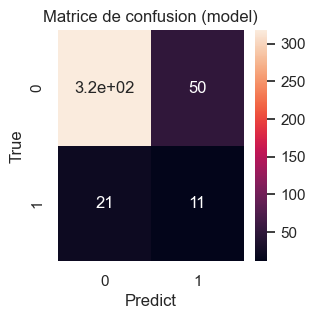

2023/03/09 19:33:07 INFO mlflow.tracking.fluent: Experiment with name 'SVC_03_under_sampling' does not exist. Creating a new experiment.


Rapport de classification :
              precision    recall  f1-score   support

         0.0       0.94      0.86      0.90       368
         1.0       0.18      0.34      0.24        32

    accuracy                           0.82       400
   macro avg       0.56      0.60      0.57       400
weighted avg       0.88      0.82      0.85       400

Logging parameters
Logging metrics
Logging model
Logging CV results matrix
Logging extra data related to the experiment
mlflow-artifacts:/685133757314825431/03cbaf72400e4961b83656271a0e5a11/artifacts
runID: fbd3a7bf26d746719ad5756043f94ffa
Logging parameters
Logging metrics
Logging model
Logging CV results matrix
Logging extra data related to the experiment
mlflow-artifacts:/685133757314825431/b9233d4d42364c68878c79d653b7aaaf/artifacts
runID: 4759ae14c1f542aea02d7359fcad831b
Logging parameters
Logging metrics
Logging model
Logging CV results matrix
Logging extra data related to the experiment
mlflow-artifacts:/685133757314825431/0124065f

In [64]:
# 3) Méthode RandomUnderSampler avec optimisation du taux de Under sampling pour le sous échantillonnage de la classe majoritaire 
pipeline = imbpipeline(steps = [['scaler', StandardScaler()],
                                #['kbest', SelectKBest(f_classif, k=20)],
                                ['under_sampling', RandomUnderSampler(random_state=10)],
                                ['classifier', SVC(kernel = 'rbf', 
                                                   probability=True,
                                                   max_iter=-1,
                                                   random_state = 10,)]
])

# Grille des modèles avec 3 validations croisées 
stratified_kfold = StratifiedKFold(n_splits=3, shuffle=True, random_state=10)
hyper_params = {'under_sampling__sampling_strategy' : np.linspace(0.1, 0.9, 9)}
grid = GridSearchCV(estimator=pipeline,
                    param_grid=hyper_params,
                    scoring='f1', # 'f1'/ 'roc_auc'
                    cv=stratified_kfold,
                    n_jobs=-1)

# Entraînement des modèles
grid.fit(X_train, y_train)

# Evaluation
print('-'*50)
print(f'Meilleurs hyperparamètres : {grid.best_params_}')
print(f'CV f1-score : {grid.best_score_:.3f}')
score_f1_under, score_auc_under = fct_eval_metrics(grid.best_estimator_, X_test, y_test)
#test_score = grid.score(X_test, y_test)

# MLFlow Tracking 
experiment_name = 'SVC_03_under_sampling'
log_results(grid, experiment_name, 'SVC')

--------------------------------------------------
Meilleurs hyperparamètres : {'over_sampling__k_neighbors': 6, 'over_sampling__sampling_strategy': 0.2, 'under_sampling__sampling_strategy': 0.7}
CV f1-score : 0.258
f1_score : 0.145
AUC_Roc_score : 0.655


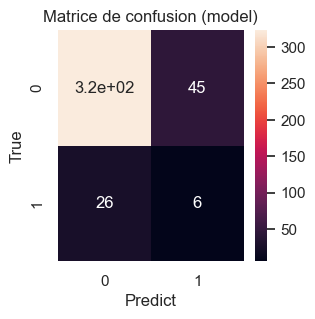

2023/03/09 19:34:28 INFO mlflow.tracking.fluent: Experiment with name 'SVC_04_overunder_sampling' does not exist. Creating a new experiment.


Rapport de classification :
              precision    recall  f1-score   support

         0.0       0.93      0.88      0.90       368
         1.0       0.12      0.19      0.14        32

    accuracy                           0.82       400
   macro avg       0.52      0.53      0.52       400
weighted avg       0.86      0.82      0.84       400

Logging parameters
Logging metrics
Logging model
Logging CV results matrix
Logging extra data related to the experiment
mlflow-artifacts:/273695530799289654/3be3bbda7e8e4688a29c5a3a0acf127a/artifacts
runID: f0f06773e51c41da8e80dbc9ba0776f9
Logging parameters
Logging metrics
Logging model
Logging CV results matrix
Logging extra data related to the experiment
mlflow-artifacts:/273695530799289654/1787002e1b714fe08cc551dba9630d40/artifacts
runID: a6a418707d2b4564ad8e1b190ba53ab3
Logging parameters
Logging metrics
Logging model
Logging CV results matrix
Logging extra data related to the experiment
mlflow-artifacts:/273695530799289654/1641374f

In [65]:
# 4) Méthode combinée SMOTE + RandomUnderSampler avec optimisation des taux Over/Under sampling 
pipeline = imbpipeline(steps = [['scaler', StandardScaler()],
                                #['kbest', SelectKBest(f_classif, k=20)],
                                ['over_sampling', SMOTE(random_state=10)],
                                ['under_sampling', RandomUnderSampler(random_state=10)],
                                ['classifier', SVC(kernel = 'rbf', 
                                                   probability=True,
                                                   max_iter=-1,
                                                   random_state = 10,)]
])

# Grille des modèles avec 3 validations croisées
stratified_kfold = StratifiedKFold(n_splits=3, shuffle=True, random_state=10)
hyper_params = {'over_sampling__k_neighbors' : [5, 6, 7],
                'over_sampling__sampling_strategy' : [0.1, 0.2, 0.3],
                'under_sampling__sampling_strategy' : [0.7, 0.8, 0.9]
}
grid = GridSearchCV(estimator=pipeline,
                    param_grid=hyper_params,
                    scoring='f1', # 'f1'/ 'roc_auc'
                    cv=stratified_kfold,
                    n_jobs=-1)

# Entraînement 
grid.fit(X_train, y_train) 

# Evaluation
print('-'*50)
print(f'Meilleurs hyperparamètres : {grid.best_params_}')
print(f'CV f1-score : {grid.best_score_:.3f}')
score_f1_overunder, score_auc_overunder = fct_eval_metrics(grid.best_estimator_, X_test, y_test)
#test_score = grid.score(X_test, y_test)

# MLFlow Tracking 
experiment_name = 'SVC_04_overunder_sampling'
log_results(grid, experiment_name, 'SVC')

#### Choice of balancing
- over/under sampling : meilleur performance obtenue sur le TEST set

In [38]:
# Comparaison des méthodes d'équilibrage des classes pour un modèle donné
def fct_compare_result(model_name=''):
    df_result = pd.DataFrame(data={'f1-score' : [score_f1_weight, score_f1_over, score_f1_under, score_f1_overunder],
                                   'auc-score' : [score_auc_weight, score_auc_over, score_auc_under, score_auc_overunder]},
                            index=['class_weight', 'over_sampling', 'under_sampling', 'over_under_sampling'])
    
    df_result = df_result.sort_values(by='f1-score', ascending=False)
    print(df_result)
    
    sns.set()
    fig = plt.figure(figsize=(10,2))
    plt.suptitle(f'{model_name} - comparaison des algos d\'équilibrage des classes', fontsize=12)

    # barplot f1-score
    plt.subplot(1,2,1)
    sns.barplot(data=df_result, y=df_result.index, x='f1-score')

    # barplot auc-score
    plt.subplot(1,2,2)
    sns.barplot(data=df_result, y=df_result.index, x='auc-score')
    plt.yticks([])
    plt.show()    

                     f1-score  auc-score
class_weight            0.263      0.651
under_sampling          0.237      0.665
over_under_sampling     0.145      0.655
over_sampling           0.133      0.661


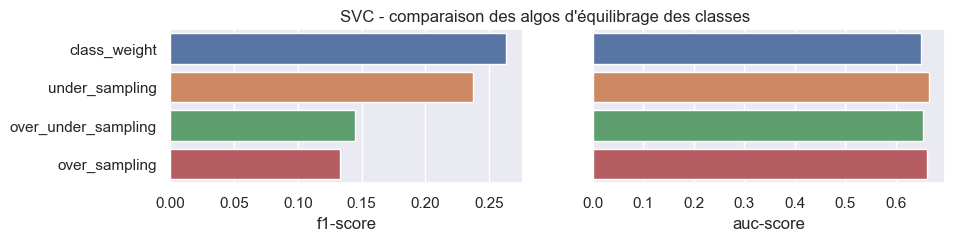

In [67]:
# Comparaison des méthodes d'équilibrage des classes : best = class_weight
fct_compare_result('SVC')

#### KBest
- Choix de l'équilibrage **class_weight ?** + KBest

Meilleurs hyperparamètres : {'kbest__k': 200}
f1_score : 0.212
AUC_Roc_score : 0.642


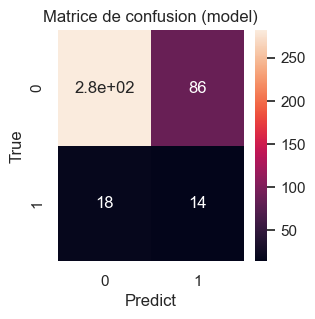

Rapport de classification :
              precision    recall  f1-score   support

         0.0       0.94      0.77      0.84       368
         1.0       0.14      0.44      0.21        32

    accuracy                           0.74       400
   macro avg       0.54      0.60      0.53       400
weighted avg       0.88      0.74      0.79       400

CV f1-score : 0.264


2023/03/09 19:51:31 INFO mlflow.tracking.fluent: Experiment with name 'SVC_05_class_weight_kbest' does not exist. Creating a new experiment.


Logging parameters
Logging metrics
Logging model
Logging CV results matrix
Logging extra data related to the experiment
mlflow-artifacts:/589171639936506529/3ee6ad54a3ad4231b24874a137d124f4/artifacts
runID: 331684622e28481ab6986d855e473f6f
Logging parameters
Logging metrics
Logging model
Logging CV results matrix
Logging extra data related to the experiment
mlflow-artifacts:/589171639936506529/2f5f28bfe8c44da5b49a76242230edb8/artifacts
runID: 7a1cf63bfb934829a38e23509622e66e
Logging parameters
Logging metrics
Logging model
Logging CV results matrix
Logging extra data related to the experiment
mlflow-artifacts:/589171639936506529/0b96304e787e405bb4129b77dc4c988f/artifacts
runID: 23aa593db75942a5988eb4929d961d3d
Logging parameters
Logging metrics
Logging model
Logging CV results matrix
Logging extra data related to the experiment
mlflow-artifacts:/589171639936506529/ff8fa85ffd854fab856520867d08aba7/artifacts
runID: dbc3d1f9fdd147fa8f6918cbe43b3a48
Logging parameters
Logging metrics
Loggi

In [69]:
# SelectKbest pour la sélection du nombre optimal de features, Mesure f1-score 
pipeline = Pipeline (steps = [['scaler', StandardScaler()],
                              ['kbest', SelectKBest(f_classif)],
                              ['classifier', SVC(kernel = 'rbf', 
                                                class_weight = {0 : 0.08777777777777777, 1 : 0.9122222222222223},
                                                probability=True,
                                                max_iter=-1,
                                                random_state = 10)]
])

# Combinaisons des hyperparamètres
hyper_params = {'kbest__k' : range(20, 300, 20)}

# Grille des modèles SVC avec 3 validations croisées
stratified_kfold = StratifiedKFold(n_splits=3, shuffle=True, random_state=10) 
grid = GridSearchCV(estimator=pipeline,
                    param_grid=hyper_params,
                    scoring='f1',  
                    cv=stratified_kfold,
                    n_jobs=-1)

# Entraînement de la grille
grid.fit(X_train, y_train)

# Evaluation
print(f'Meilleurs hyperparamètres : {grid.best_params_}')
print(f'CV f1-score : {grid.best_score_:.3f}')
score_f1_kbest, score_auc_kbest = fct_eval_metrics(grid.best_estimator_, X_test, y_test)
#test_score = grid.score(X_test, y_test)

# MLFlow tracking 
experiment_name = 'SVC_05_class_weight_kbest'
log_results(grid, experiment_name, 'SVC')

#### Hyper-parameters optimization

Meilleurs hyperparamètres : {'kbest__k': 215, 'classifier__gamma': 0.0001, 'classifier__class_weight': {0: 0.08711111111111111, 1: 0.9128888888888889}, 'classifier__C': 10}
CV f1-score : 0.279
f1_score : 0.248
AUC_Roc_score : 0.651


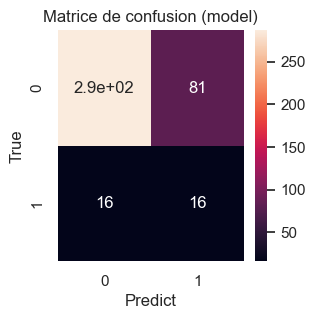

Rapport de classification :
              precision    recall  f1-score   support

         0.0       0.95      0.78      0.86       368
         1.0       0.16      0.50      0.25        32

    accuracy                           0.76       400
   macro avg       0.56      0.64      0.55       400
weighted avg       0.88      0.76      0.81       400



2023/03/10 11:21:22 INFO mlflow.tracking.fluent: Experiment with name 'SVC_06_optimized_random' does not exist. Creating a new experiment.


Logging parameters
Logging metrics
Logging model
Logging CV results matrix
Logging extra data related to the experiment
mlflow-artifacts:/403520141333582797/31df11900b5d4a9ea5d047ce85d5642e/artifacts
runID: 450bfb8442b04a4faed37a491a97258d
Logging parameters
Logging metrics
Logging model
Logging CV results matrix
Logging extra data related to the experiment
mlflow-artifacts:/403520141333582797/3aa5ad6419474e03ba5cc33f3c3e3d37/artifacts
runID: eb1e5fe41aeb41778a557451bb141cf1
Logging parameters
Logging metrics
Logging model
Logging CV results matrix
Logging extra data related to the experiment
mlflow-artifacts:/403520141333582797/3bdfee86649d4eb0b02e3f72371416af/artifacts
runID: b6e29a5a57f4446baff16cf6bf374e5f
Logging parameters
Logging metrics
Logging model
Logging CV results matrix
Logging extra data related to the experiment
mlflow-artifacts:/403520141333582797/e3f2caa230c54258ad93f61cd4c376b8/artifacts
runID: b614e64af87c4da899dfb08918dd0a01
Logging parameters
Logging metrics
Loggi

In [82]:
# On cherche avec RandomizedSearchCV la meilleur combinaison des hyperparamètres :
# - class_weight autour de : {0: 0.0877, 1: 0.912}
# - kbest__k autour de 200 : range (180, 220, 1))
# - classifier__C
# - classifier__gamma 

pipeline = Pipeline(steps = [['scaler', StandardScaler()],
                             ['kbest', SelectKBest(f_classif)],
                             ['classifier', SVC(kernel = 'rbf', 
                                                probability=True,
                                                max_iter=-1,
                                                random_state=10)]
])

# Combinaison des hyperparamètres
weights = np.linspace(0.087, 0.088, 10) 
hyper_params = {'kbest__k' : range(180, 220, 1),
                'classifier__class_weight' : [{0 : x, 1 : 1.0-x} for x in weights],
                'classifier__gamma' : [1e-3, 1e-4],
                'classifier__C' : [0.1, 1, 10, 100, 1000]                
}

# Grilles des modèles
grid = RandomizedSearchCV(pipeline, 
                          hyper_params, 
                          scoring='f1', 
                          cv=3, 
                          n_iter=50
)

# Entraînement
grid.fit(X_train, y_train)

# Evaluation
print(f'Meilleurs hyperparamètres : {grid.best_params_}')
print(f'CV f1-score : {grid.best_score_:.3f}')
score_f1_optimized, score_auc_optimized = fct_eval_metrics(grid.best_estimator_, X_test, y_test)

# MLFlow tracking 
experiment_name = 'SVC_06_optimized_random'
log_results(grid, experiment_name, 'SVC', grid_type='RamdomizedSearchCV')

Meilleurs hyperparamètres : {'classifier__C': 10, 'kbest__k': 217}
CV f1-score : 0.284
f1_score : 0.25
AUC_Roc_score : 0.651


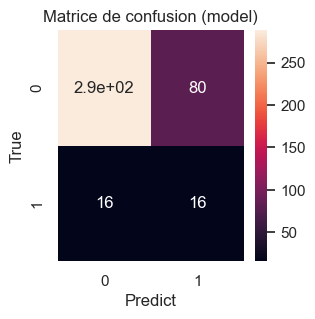

Rapport de classification :
              precision    recall  f1-score   support

         0.0       0.95      0.78      0.86       368
         1.0       0.17      0.50      0.25        32

    accuracy                           0.76       400
   macro avg       0.56      0.64      0.55       400
weighted avg       0.88      0.76      0.81       400



2023/03/10 12:24:57 INFO mlflow.tracking.fluent: Experiment with name 'SVC_07_optimized_final' does not exist. Creating a new experiment.


Logging parameters
Logging metrics
Logging model
Logging CV results matrix
Logging extra data related to the experiment
mlflow-artifacts:/930278178134990905/67d80480db1f4adfa4fde690be0bbd42/artifacts
runID: 3ec329c06ee649cdaae09ca270bd5c69
Logging parameters
Logging metrics
Logging model
Logging CV results matrix
Logging extra data related to the experiment
mlflow-artifacts:/930278178134990905/e9ad1a150a24413c8d934e466eab661e/artifacts
runID: f07c02876ae04cee8fe4b267a564aefc
Logging parameters
Logging metrics
Logging model
Logging CV results matrix
Logging extra data related to the experiment
mlflow-artifacts:/930278178134990905/28f52384052f4faa9ca771ed3978b6d2/artifacts
runID: 4fb8a35b01ca4109907d89a1f1d1f5a3
Logging parameters
Logging metrics
Logging model
Logging CV results matrix
Logging extra data related to the experiment
mlflow-artifacts:/930278178134990905/87d70bcf2ac443c1be88ab624711015e/artifacts
runID: bb75386281294849a1999b8757c2b1e0
Logging parameters
Logging metrics
Loggi

In [93]:
# Modèle optimisé SVC : 
# on affine les valeurs d'hyperparamètre en fonction de la recherche Random précédente
pipeline = Pipeline(steps = [['scaler', StandardScaler()],
                             ['kbest', SelectKBest(f_classif)],
                             ['classifier', SVC(kernel='rbf',
                                                class_weight={0 : 0.08711111111111111, 1 : 0.9128888888888889},
                                                gamma = 1e-4, 
                                                probability=True,
                                                max_iter=-1,
                                                random_state=10)]
])

# Combinaison des hyperparamètres
hyper_params = {'kbest__k' : range(210, 220, 1),
                'classifier__C' : [10, 100]                
}

# Grille des modèles pipeline SVC avec 3 validations croisées
svc_grid = GridSearchCV(pipeline, 
                        hyper_params, 
                        scoring='f1', 
                        cv=3)

# Entraînement de la grille
svc_grid.fit(X_train, y_train)

# Evaluation
print(f'Meilleurs hyperparamètres : {svc_grid.best_params_}')
print(f'CV f1-score : {svc_grid.best_score_:.3f}')
svc_score_f1_optimized, svc_score_auc_optimized = fct_eval_metrics(svc_grid.best_estimator_, X_test, y_test)
#fct_evaluation(svc_grid.best_estimator_, X_train, X_test)

# MLFlow tracking 
experiment_name = 'SVC_07_optimized_final'
log_results(svc_grid, experiment_name, 'SVC_optimized')

#### Threshold optimization
- Precision Recall Curve (pour le modèle optimisé de chaque algo)

In [44]:
# On cherche ici à optimiser visuellement le seuil de prediction (threshold), une fois le modèle optimisé
def fct_thr_optimized(model, model_name):
    #precision, recall, threshold = precision_recall_curve(y_test, grid.best_estimator_.decision_function(X_test))
    precision, recall, threshold = precision_recall_curve(y_test, model.predict_proba(X_test)[:,1])

    # Plot de Precision/Recall en fonction du seuil de classification (threshold)
    # En général, le croisement des courbes se fait au niveau du F1-score
    fig = plt.figure(figsize=(6,4))
    plt.plot(threshold, precision[:-1], label = 'Precision')
    plt.plot(threshold, recall[:-1], label = 'Recall')
    plt.title(f'{model_name} - PR en fonction du seuil de probabilité')
    plt.ylabel('PR')
    plt.xlabel('Threshold')
    plt.legend()
    plt.show()

In [ ]:
fct_thr_optimized(svc_grid.best_estimator_, 'SVC')

In [47]:
# Modèle final optimisé avec le meilleur compromis précision/rappel (F1-score)
def model_final(model, X, thr=0):
    #return model.decision_function(X) > thr
    return model.predict_proba(X)[:,1] > thr

def eval_model_final(model, X, thr):
    y_pred = model_final(model, X, thr=thr)
    y_score_pred = model.predict_proba(X)[:,1]
    # Evaluation
    score_f1 = round(f1_score(y_test, y_pred), 3)
    score_auc = round(roc_auc_score(y_test, y_score_pred), 3)
    print(f"Rapport de classification :\n{classification_report(y_test, y_pred)}")
    print(f'f1_score : {score_f1}')
    print(f'AUC Roc score : {score_auc}')
    return score_f1, score_auc

In [96]:
# Evaluation du modèle final SVC avec meilleur compromis PRECISION/RECALL (f1-score)
# le RECALL est identique avec 0.50 mais on obtient 1 meilleur précision (0.17 --> 0.19)
svc_score_f1_final, svc_score_auc_final = eval_model_final(svc_grid.best_estimator_, X_test, thr=0.13)

Rapport de classification :
              precision    recall  f1-score   support

         0.0       0.95      0.82      0.88       368
         1.0       0.19      0.50      0.28        32

    accuracy                           0.79       400
   macro avg       0.57      0.66      0.58       400
weighted avg       0.89      0.79      0.83       400

f1_score : 0.276
AUC Roc score : 0.651


## Regression Logistic

#### Balancing optimization

Meilleurs hyperparamètres : {'classifier__class_weight': {0: 0.08888888888888888, 1: 0.9111111111111111}}
CV f1-score : 0.252
f1_score : 0.19
AUC_Roc_score : 0.641


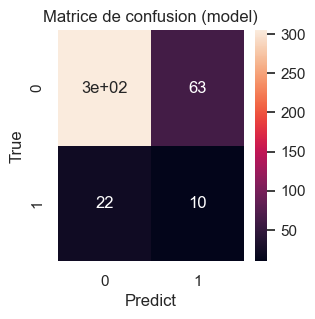

Rapport de classification :
              precision    recall  f1-score   support

         0.0       0.93      0.83      0.88       368
         1.0       0.14      0.31      0.19        32

    accuracy                           0.79       400
   macro avg       0.53      0.57      0.53       400
weighted avg       0.87      0.79      0.82       400



2023/03/10 14:20:36 INFO mlflow.tracking.fluent: Experiment with name 'LOG_01_class_weight' does not exist. Creating a new experiment.


Logging parameters
Logging metrics
Logging model
Logging CV results matrix
Logging extra data related to the experiment
mlflow-artifacts:/812262877416180122/b2c13ae6700347ee802d435bcb47a768/artifacts
runID: aff66b274c4b4f6b9224579449693712
Logging parameters
Logging metrics
Logging model
Logging CV results matrix
Logging extra data related to the experiment
mlflow-artifacts:/812262877416180122/536c25317dda495396a7e45fe9bf323f/artifacts
runID: 0b6771114acc443e8f7527cabf8e4ab1
Logging parameters
Logging metrics
Logging model
Logging CV results matrix
Logging extra data related to the experiment
mlflow-artifacts:/812262877416180122/24c4e072d71a4c938a73bc57c2d6eaa7/artifacts
runID: 5a42095f88c14440a34eab632a0c7ad9
Logging parameters
Logging metrics
Logging model
Logging CV results matrix
Logging extra data related to the experiment
mlflow-artifacts:/812262877416180122/f195e73a8fb94575a5756ede472b289d/artifacts
runID: 522b92d5ac6742c695f65bb34fee8375
Logging parameters
Logging metrics
Loggi

In [97]:
# 1) méthode des poids : hyper paramètre class_weight du classifieur
pipeline = Pipeline (steps = [['scaler', StandardScaler()],
                             #['kbest', SelectKBest(f_classif, k=20)],
                             ['classifier', LogisticRegression(random_state=10)]
])

# Combinaisons des hyperparamètres
weights = np.linspace(0.080, 0.090, 10) # poids = inversement proportionnel à la distribution / classe
hyper_params = {'classifier__class_weight' : [{0 : x, 1 : 1.0-x} for x in weights]}

# Grille des modèles avec 3 validations croisées
stratified_kfold = StratifiedKFold(n_splits=3, shuffle=True, random_state=10)
grid = GridSearchCV(estimator=pipeline,
                    param_grid=hyper_params,
                    scoring='f1',
                    cv=stratified_kfold,
                    n_jobs=-1)

# Entraînement de la grille
grid.fit(X_train, y_train)

# Evaluation
print(f'Meilleurs hyperparamètres : {grid.best_params_}')
print(f'CV f1-score : {grid.best_score_:.3f}')
score_f1_weight, score_auc_weight = fct_eval_metrics(grid.best_estimator_, X_test, y_test)
#test_score = grid.score(X_test, y_test)

# MLFlow Tracking 
experiment_name = 'LOG_01_class_weight'
log_results(grid, experiment_name, 'LOG')

--------------------------------------------------
Meilleurs hyperparamètres : {'over_sampling__k_neighbors': 5, 'over_sampling__sampling_strategy': 0.9}
CV f1-score : 0.224
f1_score : 0.222
AUC_Roc_score : 0.626


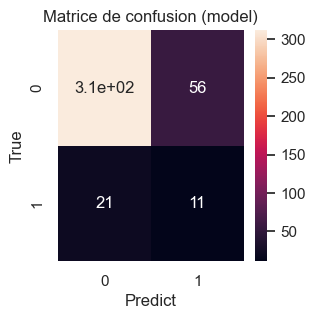

Rapport de classification :
              precision    recall  f1-score   support

         0.0       0.94      0.85      0.89       368
         1.0       0.16      0.34      0.22        32

    accuracy                           0.81       400
   macro avg       0.55      0.60      0.56       400
weighted avg       0.88      0.81      0.84       400



2023/03/10 14:24:22 INFO mlflow.tracking.fluent: Experiment with name 'LOG_02_over_sampling' does not exist. Creating a new experiment.


Logging parameters
Logging metrics
Logging model
Logging CV results matrix
Logging extra data related to the experiment
mlflow-artifacts:/988115818672073467/77d87409b0974e6e952990d1eb50eb53/artifacts
runID: 3605e040ea3a44a8883eefea2a8b9a44
Logging parameters
Logging metrics
Logging model
Logging CV results matrix
Logging extra data related to the experiment
mlflow-artifacts:/988115818672073467/b0163746081941b891a9efa14679c9c5/artifacts
runID: c6085e9abe6d4f44bce13bd087c11b47
Logging parameters
Logging metrics
Logging model
Logging CV results matrix
Logging extra data related to the experiment
mlflow-artifacts:/988115818672073467/45a1a1ea55b3402fa5700c56711a0ee9/artifacts
runID: a01647bde3ca42a9b256f48ebcfc1387
Logging parameters
Logging metrics
Logging model
Logging CV results matrix
Logging extra data related to the experiment
mlflow-artifacts:/988115818672073467/cfbdb563cc79483b959e9d6f393642d4/artifacts
runID: 9eed254ec18a48a9b8c79f74c74d5f84
Logging parameters
Logging metrics
Loggi

In [98]:
# 2) Méthode SMOTE avec optimisation des hyper-paramètres SMOTE
pipeline = imbpipeline(steps = [['scaler', StandardScaler()],
                                #['kbest', SelectKBest(f_classif, k=20)],
                                ['over_sampling', SMOTE(random_state=10)],
                                ['classifier', LogisticRegression(random_state=10)]
])

# Combinaisons des hyperparamètres
hyper_params = {'over_sampling__k_neighbors' : [3, 5, 7],
                'over_sampling__sampling_strategy' : np.linspace(0.1, 0.9, 9)
}

# Grille des modèles avec 3 validations croisées
stratified_kfold = StratifiedKFold(n_splits=3, shuffle=True, random_state=10)
grid = GridSearchCV(estimator=pipeline,
                    param_grid=hyper_params,
                    scoring='f1',
                    cv=stratified_kfold,
                    n_jobs=-1)

# Entraînement de la grille
grid.fit(X_train, y_train) 

# Evaluation
print('-'*50)
print(f'Meilleurs hyperparamètres : {grid.best_params_}')
print(f'CV f1-score : {grid.best_score_:.3f}')
score_f1_over, score_auc_over = fct_eval_metrics(grid.best_estimator_, X_test, y_test)
#test_score = grid.score(X_test, y_test)

# MLFlow Tracking 
experiment_name = 'LOG_02_over_sampling'
log_results(grid, experiment_name, 'LOG')

--------------------------------------------------
Meilleurs hyperparamètres : {'under_sampling__sampling_strategy': 0.5}
CV f1-score : 0.241
f1_score : 0.2
AUC_Roc_score : 0.618


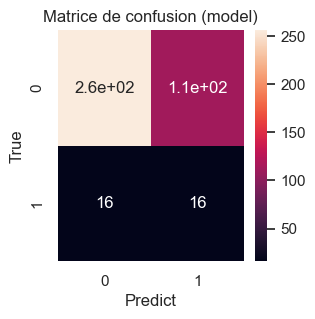

2023/03/10 14:25:58 INFO mlflow.tracking.fluent: Experiment with name 'LOG_03_under_sampling' does not exist. Creating a new experiment.


Rapport de classification :
              precision    recall  f1-score   support

         0.0       0.94      0.70      0.80       368
         1.0       0.12      0.50      0.20        32

    accuracy                           0.68       400
   macro avg       0.53      0.60      0.50       400
weighted avg       0.88      0.68      0.75       400

Logging parameters
Logging metrics
Logging model
Logging CV results matrix
Logging extra data related to the experiment
mlflow-artifacts:/772543412192182921/be475480c28a4891a06716eeaa387300/artifacts
runID: e3ca9a01bebb497a911ae271439b9d79
Logging parameters
Logging metrics
Logging model
Logging CV results matrix
Logging extra data related to the experiment
mlflow-artifacts:/772543412192182921/9f0e0eb7980240f780ecf577b0055161/artifacts
runID: f69db6b7e2564b3f9e1d6eec89e181d2
Logging parameters
Logging metrics
Logging model
Logging CV results matrix
Logging extra data related to the experiment
mlflow-artifacts:/772543412192182921/6f97374e

In [99]:
# 3) Méthode RandomUnderSampler avec optimisation du taux de Under sampling pour le sous échantillonnage de la classe majoritaire 
pipeline = imbpipeline(steps = [['scaler', StandardScaler()],
                                #['kbest', SelectKBest(f_classif, k=20)],
                                ['under_sampling', RandomUnderSampler(random_state=10)],
                                ['classifier', LogisticRegression(random_state=10)]
])

# Grille des modèles avec 3 validations croisées 
stratified_kfold = StratifiedKFold(n_splits=3, shuffle=True, random_state=10)
hyper_params = {'under_sampling__sampling_strategy' : np.linspace(0.1, 0.9, 9)}
grid = GridSearchCV(estimator=pipeline,
                    param_grid=hyper_params,
                    scoring='f1', # 'f1'/ 'roc_auc'
                    cv=stratified_kfold,
                    n_jobs=-1)

# Entraînement des modèles
grid.fit(X_train, y_train)

# Evaluation
print('-'*50)
print(f'Meilleurs hyperparamètres : {grid.best_params_}')
print(f'CV f1-score : {grid.best_score_:.3f}')
score_f1_under, score_auc_under = fct_eval_metrics(grid.best_estimator_, X_test, y_test)
#test_score = grid.score(X_test, y_test)

# MLFlow Tracking 
experiment_name = 'LOG_03_under_sampling'
log_results(grid, experiment_name, 'LOG')

--------------------------------------------------
Meilleurs hyperparamètres : {'over_sampling__k_neighbors': 6, 'over_sampling__sampling_strategy': 0.2, 'under_sampling__sampling_strategy': 0.9}
CV f1-score : 0.239
f1_score : 0.194
AUC_Roc_score : 0.635


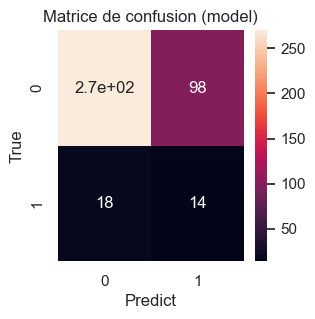

2023/03/10 14:28:26 INFO mlflow.tracking.fluent: Experiment with name 'LOG_04_overunder_sampling' does not exist. Creating a new experiment.


Rapport de classification :
              precision    recall  f1-score   support

         0.0       0.94      0.73      0.82       368
         1.0       0.12      0.44      0.19        32

    accuracy                           0.71       400
   macro avg       0.53      0.59      0.51       400
weighted avg       0.87      0.71      0.77       400

Logging parameters
Logging metrics
Logging model
Logging CV results matrix
Logging extra data related to the experiment
mlflow-artifacts:/437550662670133911/e801d52d01534907a7a0a856a8606a6a/artifacts
runID: c2f3b947ddfa4c2e97f4b4c7e6364791
Logging parameters
Logging metrics
Logging model
Logging CV results matrix
Logging extra data related to the experiment
mlflow-artifacts:/437550662670133911/cde88a1c42644f49ae8b2aa63b2a0190/artifacts
runID: 41728dd90d0847e3b6a279058688209b
Logging parameters
Logging metrics
Logging model
Logging CV results matrix
Logging extra data related to the experiment
mlflow-artifacts:/437550662670133911/1f1c755c

In [100]:
# 4) Méthode combinée SMOTE + RandomUnderSampler avec optimisation des taux Over/Under sampling 
pipeline = imbpipeline(steps = [['scaler', StandardScaler()],
                                #['kbest', SelectKBest(f_classif, k=20)],
                                ['over_sampling', SMOTE(random_state=10)],
                                ['under_sampling', RandomUnderSampler(random_state=10)],
                                ['classifier', LogisticRegression(random_state=10)]
])

# Grille des modèles avec 3 validations croisées
stratified_kfold = StratifiedKFold(n_splits=3, shuffle=True, random_state=10)
hyper_params = {'over_sampling__k_neighbors' : [5, 6, 7],
                'over_sampling__sampling_strategy' : [0.1, 0.2, 0.3],
                'under_sampling__sampling_strategy' : [0.7, 0.8, 0.9]
}
grid = GridSearchCV(estimator=pipeline,
                    param_grid=hyper_params,
                    scoring='f1', # 'f1'/ 'roc_auc'
                    cv=stratified_kfold,
                    n_jobs=-1)

# Entraînement 
grid.fit(X_train, y_train) 

# Evaluation
print('-'*50)
print(f'Meilleurs hyperparamètres : {grid.best_params_}')
print(f'CV f1-score : {grid.best_score_:.3f}')
score_f1_overunder, score_auc_overunder = fct_eval_metrics(grid.best_estimator_, X_test, y_test)
#test_score = grid.score(X_test, y_test)

# MLFlow Tracking 
experiment_name = 'LOG_04_overunder_sampling'
log_results(grid, experiment_name, 'LOG')

#### Choice of balancing
- Class_weight : meilleur modèle obtenu sur la **cross validation mais pas sur le TEST set, quid ???*** 
- faut-il se baser sur la **CV ou sur la TEST set** pour choisir le meilleur modèle ???

                     f1-score  auc-score
over_sampling           0.222      0.626
under_sampling          0.200      0.618
over_under_sampling     0.194      0.635
class_weight            0.190      0.641


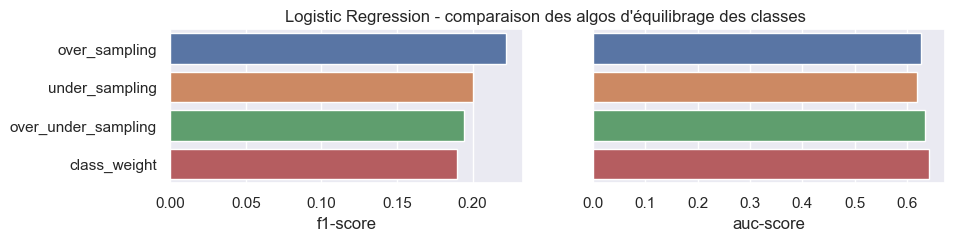

In [101]:
# Comparaison des méthodes d'équilibrage des classes
fct_compare_result('Logistic Regression')

#### KBest
- Choix de l'équilibrage **over sampling (k_neighbors=5, sampling_strategy=0.9) ?** + KBest

--------------------------------------------------
Meilleurs hyperparamètres : {'kbest__k': 60}
CV f1-score : 0.283
f1_score : 0.224
AUC_Roc_score : 0.692


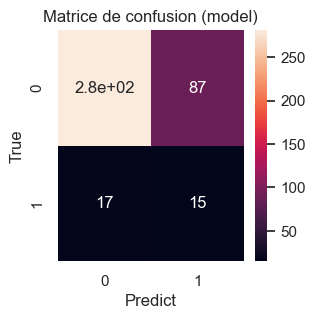

Rapport de classification :
              precision    recall  f1-score   support

         0.0       0.94      0.76      0.84       368
         1.0       0.15      0.47      0.22        32

    accuracy                           0.74       400
   macro avg       0.55      0.62      0.53       400
weighted avg       0.88      0.74      0.79       400



2023/03/10 15:20:29 INFO mlflow.tracking.fluent: Experiment with name 'LOG_05_over_sampling_kbest' does not exist. Creating a new experiment.


Logging parameters
Logging metrics
Logging model
Logging CV results matrix
Logging extra data related to the experiment
mlflow-artifacts:/256398150657461890/8cab23989e754281a8af6796828f013f/artifacts
runID: 5508a06350614d68a8a1a14921ffc8ea
Logging parameters
Logging metrics
Logging model
Logging CV results matrix
Logging extra data related to the experiment
mlflow-artifacts:/256398150657461890/48faa16dfb45401fa0ec2bbf198c27f5/artifacts
runID: ca452fc425fd465f9b19a77666548038
Logging parameters
Logging metrics
Logging model
Logging CV results matrix
Logging extra data related to the experiment
mlflow-artifacts:/256398150657461890/6b681e49820d49daac3f6730e14c761e/artifacts
runID: 7959fcfdecfa4a81bcd27ab8a7be32f0
Logging parameters
Logging metrics
Logging model
Logging CV results matrix
Logging extra data related to the experiment
mlflow-artifacts:/256398150657461890/1ed95d48da2f40c38497620dae978427/artifacts
runID: 0bec0cb0db8a42f3a0e9ef015ad602ac
Logging parameters
Logging metrics
Loggi

In [104]:
# SelectKbest
pipeline = imbpipeline(steps = [['scaler', StandardScaler()],
                                ['kbest', SelectKBest(f_classif)],
                                ['over_sampling', SMOTE(random_state=10, k_neighbors=5, sampling_strategy=0.9)],
                                ['classifier', LogisticRegression(random_state=10)]
])

# Combinaisons des hyperparamètres
hyper_params = {'kbest__k' : range(20, 300, 20)}

# Grille des modèles avec 3 validations croisées
stratified_kfold = StratifiedKFold(n_splits=3, shuffle=True, random_state=10) 
grid = GridSearchCV(estimator=pipeline,
                    param_grid=hyper_params,
                    scoring='f1', 
                    cv=stratified_kfold,
                    n_jobs=-1)

# Entraînement de la grille
grid.fit(X_train, y_train)

# Evaluation
print('-'*50)
print(f'Meilleurs hyperparamètres : {grid.best_params_}')
print(f'CV f1-score : {grid.best_score_:.3f}')
score_f1_kbest, score_auc_kbest = fct_eval_metrics(grid.best_estimator_, X_test, y_test)

# MLFlow Tracking 
experiment_name = 'LOG_05_over_sampling_kbest'
log_results(grid, experiment_name, 'LOG')

#### Hyper-parameters optimization

Meilleurs hyperparamètres : {'over_sampling__sampling_strategy': 0.9, 'over_sampling__k_neighbors': 4, 'kbest__k': 65, 'classifier__C': 0.1}
CV f1-score : 0.286
f1_score : 0.229
AUC_Roc_score : 0.681


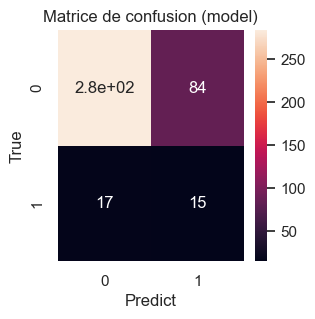

Rapport de classification :
              precision    recall  f1-score   support

         0.0       0.94      0.77      0.85       368
         1.0       0.15      0.47      0.23        32

    accuracy                           0.75       400
   macro avg       0.55      0.62      0.54       400
weighted avg       0.88      0.75      0.80       400



2023/03/10 15:25:42 INFO mlflow.tracking.fluent: Experiment with name 'LOG_06_optimized_random' does not exist. Creating a new experiment.


Logging parameters
Logging metrics
Logging model
Logging CV results matrix
Logging extra data related to the experiment
mlflow-artifacts:/924690229903918047/2e0b26017e594265869bc1540063d364/artifacts
runID: b18f13d8caa04e5baa56a2b16b2f8f81
Logging parameters
Logging metrics
Logging model
Logging CV results matrix
Logging extra data related to the experiment
mlflow-artifacts:/924690229903918047/70814e5c87764d05be56546a0cb2c506/artifacts
runID: bf29f914b79342c680a02ebe88081382
Logging parameters
Logging metrics
Logging model
Logging CV results matrix
Logging extra data related to the experiment
mlflow-artifacts:/924690229903918047/6ce31197620f4a4a90bf3bd5963a93d9/artifacts
runID: 408c591c0937431698537799f962e942
Logging parameters
Logging metrics
Logging model
Logging CV results matrix
Logging extra data related to the experiment
mlflow-artifacts:/924690229903918047/491b727d6afc4dba953e6dbce6811d1a/artifacts
runID: 3e440cb3590b4cdd8ce27d2d894a7ea8
Logging parameters
Logging metrics
Loggi

In [105]:
# On cherche avec RandomizedSearchCV la meilleur combinaison des hyperparamètres :
# - over_sampling__k_neighbors autour de 5 : [4, 5, 6]
# - over_sampling__sampling_strategy autour de 0.90 : [0.85, 0.90, 0.95] 
# - kbest__k autour de 60 : range (50, 70, 5)
# - classifier__C

# Réglage des hyperparamètres avec RandomizedSearchCV
pipeline = imbpipeline(steps = [['scaler', StandardScaler()],
                                ['kbest', SelectKBest(f_classif)],
                                ['over_sampling', SMOTE(random_state=10)],
                                ['classifier', LogisticRegression(random_state=10)]
])

# Combinaison des hyperparamètres
hyper_params = {'kbest__k' : range(50, 70, 5),                    
                'over_sampling__k_neighbors' : [4, 5, 6],             
                'over_sampling__sampling_strategy' : [0.85, 0.90, 0.95],   
                'classifier__C' : [0.1, 1, 10, 100, 1000]            
}

# Grilles des modèles
grid = RandomizedSearchCV(
                        pipeline, 
                        hyper_params, 
                        scoring='f1', 
                        cv=3, 
                        n_iter=50
)

# Entraînement
grid.fit(X_train, y_train)

# Evaluation
print(f'Meilleurs hyperparamètres : {grid.best_params_}')
print(f'CV f1-score : {grid.best_score_:.3f}')
score_f1_optimized, score_auc_optimized = fct_eval_metrics(grid.best_estimator_, X_test, y_test)

# MLFlow tracking 
experiment_name = 'LOG_06_optimized_random'
log_results(grid, experiment_name, 'LOG', grid_type='RamdomizedSearchCV')

Meilleurs hyperparamètres : {'classifier__C': 0.1, 'kbest__k': 60}
CV f1-score : 0.295
f1_score : 0.229
AUC_Roc_score : 0.68


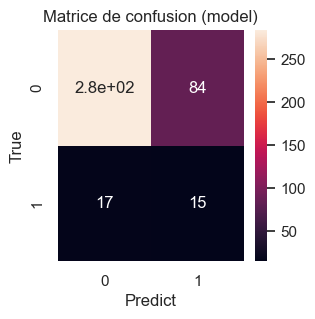

2023/03/10 15:45:57 INFO mlflow.tracking.fluent: Experiment with name 'LOG_07_optimized_final' does not exist. Creating a new experiment.


Rapport de classification :
              precision    recall  f1-score   support

         0.0       0.94      0.77      0.85       368
         1.0       0.15      0.47      0.23        32

    accuracy                           0.75       400
   macro avg       0.55      0.62      0.54       400
weighted avg       0.88      0.75      0.80       400

Logging parameters
Logging metrics
Logging model
Logging CV results matrix
Logging extra data related to the experiment
mlflow-artifacts:/568931668578829123/ee66f9d163cc4330a6d5e1f4d0f946a0/artifacts
runID: 81e3afda449f4f5da2dafee0f95f7b47
Logging parameters
Logging metrics
Logging model
Logging CV results matrix
Logging extra data related to the experiment
mlflow-artifacts:/568931668578829123/f509aa6450e646df823b259e37ec9adf/artifacts
runID: f2e67403c86749368da9f06d56bc1f33
Logging parameters
Logging metrics
Logging model
Logging CV results matrix
Logging extra data related to the experiment
mlflow-artifacts:/568931668578829123/a6b23c3e

In [107]:
# Modèle optimisé Logistic Regression : 
# On affine les valeurs d'hyperparamètre en fonction de la recherche Random précédente
pipeline = imbpipeline(steps = [['scaler', StandardScaler()],
                                ['kbest', SelectKBest(f_classif)],
                                ['over_sampling', SMOTE(random_state=10, k_neighbors=4, sampling_strategy=0.9)],
                                ['classifier', LogisticRegression(random_state=10)]
])

# Combinaison des hyperparamètres
hyper_params = {'kbest__k' : range(60, 70, 1),                                    
                'classifier__C' : [0.1, 1]            
}

# Grilles des modèles
stratified_kfold = StratifiedKFold(n_splits=3, shuffle=True, random_state=10)
log_grid = GridSearchCV(pipeline, 
                    hyper_params, 
                    scoring='f1', 
                    cv=stratified_kfold
)

# Entraînement
log_grid.fit(X_train, y_train)

# Evaluation
print(f'Meilleurs hyperparamètres : {log_grid.best_params_}')
print(f'CV f1-score : {log_grid.best_score_:.3f}')
log_score_f1_optimized, log_score_auc_optimized = fct_eval_metrics(log_grid.best_estimator_, X_test, y_test)

# MLFlow tracking 
experiment_name = 'LOG_07_optimized_final'
log_results(log_grid, experiment_name, 'LOG')

#### Threshold optimization

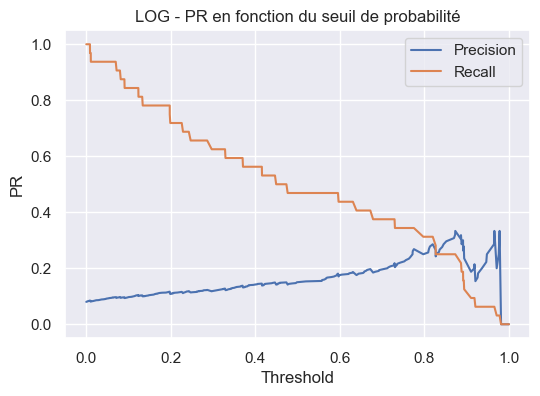

In [108]:
fct_thr_optimized(log_grid.best_estimator_, 'LOG')

In [114]:
# Evaluation du modèle final LOGISTIC REGRESSION :
# le f1-score est meilleur  (0.23 --> 0.252)
log_score_f1_final, log_score_auc_final = eval_model_final(log_grid.best_estimator_, X_test, thr=0.60)

Rapport de classification :
              precision    recall  f1-score   support

         0.0       0.94      0.82      0.88       368
         1.0       0.18      0.44      0.25        32

    accuracy                           0.79       400
   macro avg       0.56      0.63      0.57       400
weighted avg       0.88      0.79      0.83       400

f1_score : 0.252
AUC Roc score : 0.68


## Random Forest

#### Balancing optimization

Meilleurs hyperparamètres : {'classifier__class_weight': {0: 0.08, 1: 0.92}}
CV f1-score : 0.000
f1_score : 0.0
AUC_Roc_score : 0.616


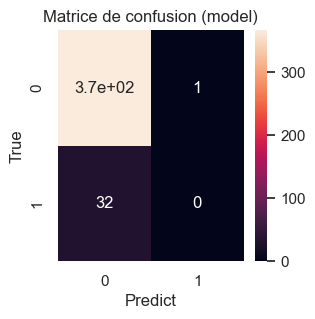

2023/03/13 16:42:24 INFO mlflow.tracking.fluent: Experiment with name 'RFC_01_class_weight' does not exist. Creating a new experiment.


Rapport de classification :
              precision    recall  f1-score   support

         0.0       0.92      1.00      0.96       368
         1.0       0.00      0.00      0.00        32

    accuracy                           0.92       400
   macro avg       0.46      0.50      0.48       400
weighted avg       0.85      0.92      0.88       400

Logging parameters
Logging metrics
Logging model
Logging CV results matrix
Logging extra data related to the experiment
mlflow-artifacts:/125510417787646105/74824a54b1564a9197713e58ab1732b3/artifacts
runID: d23041a07d02493e88abbcb4288582c1
Logging parameters
Logging metrics
Logging model
Logging CV results matrix
Logging extra data related to the experiment
mlflow-artifacts:/125510417787646105/54d86cc86f094b01a5d9d5a45a019cd0/artifacts
runID: b038f21b29004964918b4c381751945d
Logging parameters
Logging metrics
Logging model
Logging CV results matrix
Logging extra data related to the experiment
mlflow-artifacts:/125510417787646105/4175422f

In [137]:
# 1) méthode des poids : hyper paramètre class_weight du classifieur
pipeline = Pipeline (steps = [['classifier', RandomForestClassifier(n_estimators=200, random_state=10)]])

# Combinaisons des hyperparamètres
# 8% de classe 1 <-> poids = 1
# 92 de classe 0 <-> poids = 8/92 = 0.087
weights = np.linspace(0.080, 0.090, 10) # poids = inversement proportionnel à la distribution / classe
hyper_params = {'classifier__class_weight' : [{0 : x, 1 : 1.0-x} for x in weights]}
#hyper_params = {'classifier__class_weight' : [{0 : 0.087, 1 : 1}]} # poids effectifs des classes
#hyper_params = {'classifier__class_weight' : [{0 : 11.5, 1 : 1}]} # poids inversé pour rééquilibrer les classes
#hyper_params = {'classifier__class_weight' : ['balanced', 'balanced_subsample']}

# Grille des modèles SVC avec 3 validations croisées
stratified_kfold = StratifiedKFold(n_splits=3, shuffle=True, random_state=10)
grid = GridSearchCV(estimator=pipeline,
                    param_grid=hyper_params,
                    scoring='f1', 
                    cv=stratified_kfold,
                    n_jobs=-1)

# Entraînement de la grille
grid.fit(X_train, y_train)

# Evaluation
print(f'Meilleurs hyperparamètres : {grid.best_params_}')
print(f'CV f1-score : {grid.best_score_:.3f}')
score_f1_weight, score_auc_weight = fct_eval_metrics(grid.best_estimator_, X_test, y_test)
#test_score = grid.score(X_test, y_test)

# MLFlow Tracking 
experiment_name = 'RFC_01_class_weight'
log_results(grid, experiment_name, 'RFC')

--------------------------------------------------
Meilleurs hyperparamètres : {'over_sampling__k_neighbors': 5, 'over_sampling__sampling_strategy': 0.8}
CV f1-score : 0.073
f1_score : 0.0
AUC_Roc_score : 0.66


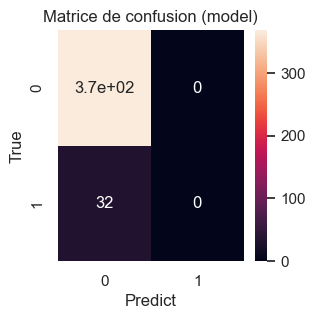

2023/03/10 16:14:51 INFO mlflow.tracking.fluent: Experiment with name 'RFC_02_over_sampling' does not exist. Creating a new experiment.


Rapport de classification :
              precision    recall  f1-score   support

         0.0       0.92      1.00      0.96       368
         1.0       0.00      0.00      0.00        32

    accuracy                           0.92       400
   macro avg       0.46      0.50      0.48       400
weighted avg       0.85      0.92      0.88       400

Logging parameters
Logging metrics
Logging model
Logging CV results matrix
Logging extra data related to the experiment
mlflow-artifacts:/721618202726837159/43d4a94317bd4e2fab0b6c9028c93e0b/artifacts
runID: dc9953c225044ec2b9ce90fb55c4f8e0
Logging parameters
Logging metrics
Logging model
Logging CV results matrix
Logging extra data related to the experiment
mlflow-artifacts:/721618202726837159/df4df8525d58467dbe0b8255d19076ee/artifacts
runID: f5162edf93b9482f954cce5dc8673578
Logging parameters
Logging metrics
Logging model
Logging CV results matrix
Logging extra data related to the experiment
mlflow-artifacts:/721618202726837159/49e3c81e

In [118]:
# 2) Méthode SMOTE avec optimisation des hyper-paramètres SMOTE
pipeline = imbpipeline(steps = [['scaler', StandardScaler()],
                                #['kbest', SelectKBest(f_classif, k=20)],
                                ['over_sampling', SMOTE(random_state=10)],
                                ['classifier', RandomForestClassifier(n_estimators=200, random_state=10)]
])

# Combinaisons des hyperparamètres
hyper_params = {'over_sampling__k_neighbors' : [3, 5, 7],
                'over_sampling__sampling_strategy' : np.linspace(0.1, 0.9, 9)
}

# Grille des modèles avec 3 validations croisées
stratified_kfold = StratifiedKFold(n_splits=3, shuffle=True, random_state=10)
grid = GridSearchCV(estimator=pipeline,
                          param_grid=hyper_params,
                          scoring='f1',
                          cv=stratified_kfold,
                          n_jobs=-1)

# Entraînement de la grille
grid.fit(X_train, y_train) 

# Evaluation
print('-'*50)
print(f'Meilleurs hyperparamètres : {grid.best_params_}')
print(f'CV f1-score : {grid.best_score_:.3f}')
score_f1_over, score_auc_over = fct_eval_metrics(grid.best_estimator_, X_test, y_test)
#test_score = grid.score(X_test, y_test)

# MLFlow Tracking 
experiment_name = 'RFC_02_over_sampling'
log_results(grid, experiment_name, 'RFC')

--------------------------------------------------
Meilleurs hyperparamètres : {'under_sampling__sampling_strategy': 0.8}
CV f1-score : 0.266
f1_score : 0.219
AUC_Roc_score : 0.672


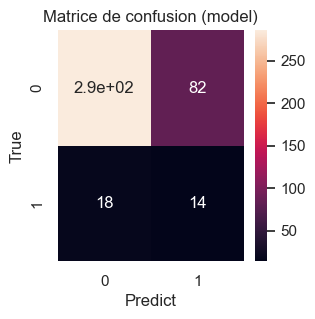

Rapport de classification :
              precision    recall  f1-score   support

         0.0       0.94      0.78      0.85       368
         1.0       0.15      0.44      0.22        32

    accuracy                           0.75       400
   macro avg       0.54      0.61      0.53       400
weighted avg       0.88      0.75      0.80       400



2023/03/10 16:17:11 INFO mlflow.tracking.fluent: Experiment with name 'RFC_03_under_sampling' does not exist. Creating a new experiment.


Logging parameters
Logging metrics
Logging model
Logging CV results matrix
Logging extra data related to the experiment
mlflow-artifacts:/244863115101042986/71c9b03b050f4853a1d513a2da60dbf6/artifacts
runID: 96cd0de08c514f6ab09b8767044b3ebf
Logging parameters
Logging metrics
Logging model
Logging CV results matrix
Logging extra data related to the experiment
mlflow-artifacts:/244863115101042986/85b68e3138dd47d3a6c06f1d561963c0/artifacts
runID: 4edcb2b5864642688896b5e801aceda0
Logging parameters
Logging metrics
Logging model
Logging CV results matrix
Logging extra data related to the experiment
mlflow-artifacts:/244863115101042986/7c40a1448b2743788ae1a61280a48f33/artifacts
runID: fe0539d03707456bba818f3d2f0291ba
Logging parameters
Logging metrics
Logging model
Logging CV results matrix
Logging extra data related to the experiment
mlflow-artifacts:/244863115101042986/37d21e9f54b3457ca975f726e663c4b4/artifacts
runID: 7df9fbff4139474aac9a4247eec81dd0
Logging parameters
Logging metrics
Loggi

In [119]:
# 3) Méthode RandomUnderSampler avec optimisation du taux de Under sampling pour le sous échantillonnage de la classe majoritaire 
pipeline = imbpipeline(steps = [['scaler', StandardScaler()],
                                #['kbest', SelectKBest(f_classif, k=20)],
                                ['under_sampling', RandomUnderSampler(random_state=10)],
                                ['classifier', RandomForestClassifier(n_estimators=200, random_state=10)]
])

# Grille des modèles avec 3 validations croisées 
stratified_kfold = StratifiedKFold(n_splits=3, shuffle=True, random_state=10)
hyper_params = {'under_sampling__sampling_strategy' : np.linspace(0.1, 0.9, 9)}
grid = GridSearchCV(estimator=pipeline,
                    param_grid=hyper_params,
                    scoring='f1', # 'f1'/ 'roc_auc'
                    cv=stratified_kfold,
                    n_jobs=-1)

# Entraînement des modèles
grid.fit(X_train, y_train)

# Evaluation
print('-'*50)
print(f'Meilleurs hyperparamètres : {grid.best_params_}')
print(f'CV f1-score : {grid.best_score_:.3f}')
score_f1_under, score_auc_under = fct_eval_metrics(grid.best_estimator_, X_test, y_test)
#test_score = grid.score(X_test, y_test)

# MLFlow Tracking 
experiment_name = 'RFC_03_under_sampling'
log_results(grid, experiment_name, 'RFC')

--------------------------------------------------
Meilleurs hyperparamètres : {'over_sampling__k_neighbors': 6, 'over_sampling__sampling_strategy': 0.1, 'under_sampling__sampling_strategy': 0.8}
CV f1-score : 0.282
f1_score : 0.167
AUC_Roc_score : 0.647


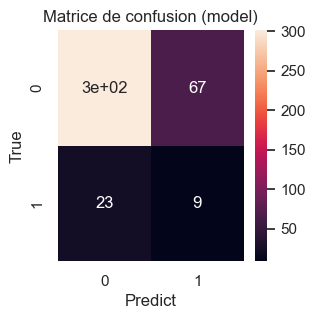

2023/03/10 16:19:35 INFO mlflow.tracking.fluent: Experiment with name 'RFC_04_overunder_sampling' does not exist. Creating a new experiment.


Rapport de classification :
              precision    recall  f1-score   support

         0.0       0.93      0.82      0.87       368
         1.0       0.12      0.28      0.17        32

    accuracy                           0.78       400
   macro avg       0.52      0.55      0.52       400
weighted avg       0.86      0.78      0.81       400

Logging parameters
Logging metrics
Logging model
Logging CV results matrix
Logging extra data related to the experiment
mlflow-artifacts:/701503917284653070/1bcbb6ac755f4872a1cfba8c6a7d4691/artifacts
runID: 7938ce244bbf4a18b1797472aae55caf
Logging parameters
Logging metrics
Logging model
Logging CV results matrix
Logging extra data related to the experiment
mlflow-artifacts:/701503917284653070/cc1e7a6207b3409ebf86283019e91616/artifacts
runID: ff67f194282040bfb6c6599b7a1d762e
Logging parameters
Logging metrics
Logging model
Logging CV results matrix
Logging extra data related to the experiment
mlflow-artifacts:/701503917284653070/2cd8b33c

In [120]:
# 4) Méthode combinée SMOTE + RandomUnderSampler avec optimisation des taux Over/Under sampling 
pipeline = imbpipeline(steps = [['scaler', StandardScaler()],
                                #['kbest', SelectKBest(f_classif, k=20)],
                                ['over_sampling', SMOTE(random_state=10)],
                                ['under_sampling', RandomUnderSampler(random_state=10)],
                                ['classifier', RandomForestClassifier(n_estimators=200, random_state=10)]
])

# Grille des modèles avec 3 validations croisées
stratified_kfold = StratifiedKFold(n_splits=3, shuffle=True, random_state=10)
hyper_params = {'over_sampling__k_neighbors' : [5, 6, 7],
                'over_sampling__sampling_strategy' : [0.1, 0.2, 0.3],
                'under_sampling__sampling_strategy' : [0.7, 0.8, 0.9]
}
grid = GridSearchCV(estimator=pipeline,
                    param_grid=hyper_params,
                    scoring='f1', 
                    cv=stratified_kfold,
                    n_jobs=-1)

# Entraînement 
grid.fit(X_train, y_train) 

# Evaluation
print('-'*50)
print(f'Meilleurs hyperparamètres : {grid.best_params_}')
print(f'CV f1-score : {grid.best_score_:.3f}')
score_f1_overunder, score_auc_overunder = fct_eval_metrics(grid.best_estimator_, X_test, y_test)
#test_score = grid.score(X_test, y_test)

# MLFlow Tracking 
experiment_name = 'RFC_04_overunder_sampling'
log_results(grid, experiment_name, 'RFC')

#### Choice of balancing
- under sampling (sampling_strategy=0.8) : meilleur performance obtenue sur le TEST set

                     f1-score  auc-score
under_sampling          0.219      0.672
over_under_sampling     0.167      0.647
class_weight            0.000      0.616
over_sampling           0.000      0.660


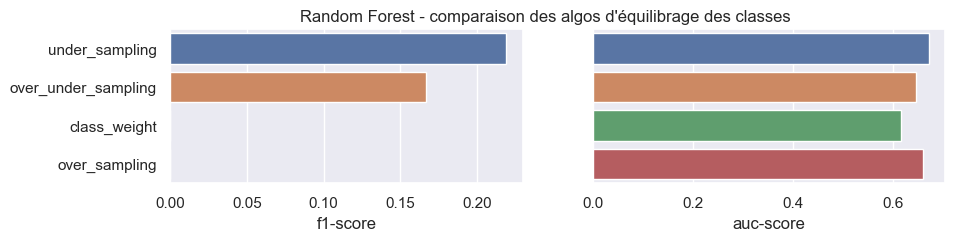

In [139]:
# Comparaison des méthodes d'équilibrage des classes : best = under sampling
fct_compare_result('Random Forest')

#### KBest
- Equilibrage **under sampling=0.8** + recherche des KBest features

Meilleurs hyperparamètres : {'kbest__k': 220}
CV f1-score : 0.280
f1_score : 0.194
AUC_Roc_score : 0.655


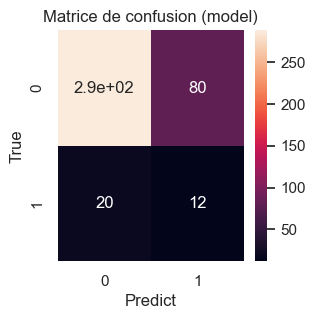

2023/03/13 17:35:12 INFO mlflow.tracking.fluent: Experiment with name 'RFC_05_under_sampling_kbest' does not exist. Creating a new experiment.


Rapport de classification :
              precision    recall  f1-score   support

         0.0       0.94      0.78      0.85       368
         1.0       0.13      0.38      0.19        32

    accuracy                           0.75       400
   macro avg       0.53      0.58      0.52       400
weighted avg       0.87      0.75      0.80       400

Logging parameters
Logging metrics
Logging model
Logging CV results matrix
Logging extra data related to the experiment
mlflow-artifacts:/541915491067047743/ca6392d83b7a4615804d91e687cfb68e/artifacts
runID: 46d3ed2736224d86952162e4d3275dcd
Logging parameters
Logging metrics
Logging model
Logging CV results matrix
Logging extra data related to the experiment
mlflow-artifacts:/541915491067047743/dd3784dcb6564015802e063095d27fb3/artifacts
runID: 3deb8dbd699b45cf952b69df6a92d9c8
Logging parameters
Logging metrics
Logging model
Logging CV results matrix
Logging extra data related to the experiment
mlflow-artifacts:/541915491067047743/5a8b1e2e

In [151]:
# SelectKbest
pipeline = imbpipeline(steps = [['scaler', StandardScaler()],
                                ['kbest', SelectKBest(f_classif)],
                                ['under_sampling', RandomUnderSampler(random_state=10, sampling_strategy=0.8)],
                                ['classifier', RandomForestClassifier(random_state=10)]
])


# Combinaisons des hyperparamètres
hyper_params = {'kbest__k' : range(20, 300, 20)}

# Grille des modèles SVC avec 3 validations croisées
stratified_kfold = StratifiedKFold(n_splits=3, shuffle=True, random_state=10) 
grid = GridSearchCV(estimator=pipeline,
                    param_grid=hyper_params,
                    scoring='f1',  
                    cv=stratified_kfold,
                    n_jobs=-1)

# Entraînement de la grille
grid.fit(X_train, y_train)

# Evaluation
print(f'Meilleurs hyperparamètres : {grid.best_params_}')
print(f'CV f1-score : {grid.best_score_:.3f}')
score_f1_kbest, score_auc_kbest = fct_eval_metrics(grid.best_estimator_, X_test, y_test)
#test_score = grid.score(X_test, y_test)

# MLFlow tracking 
experiment_name = 'RFC_05_under_sampling_kbest'
log_results(grid, experiment_name, 'RFC')

#### Hyper-parameters optimization

Meilleurs hyperparamètres : {'kbest__k': 230, 'classifier__n_estimators': 400, 'classifier__min_samples_leaf': 1, 'classifier__max_depth': 45}
CV f1-score : 0.237
f1_score : 0.237
AUC_Roc_score : 0.659


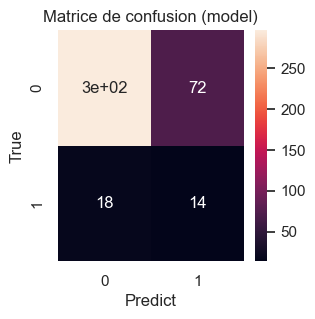

Rapport de classification :
              precision    recall  f1-score   support

         0.0       0.94      0.80      0.87       368
         1.0       0.16      0.44      0.24        32

    accuracy                           0.78       400
   macro avg       0.55      0.62      0.55       400
weighted avg       0.88      0.78      0.82       400



2023/03/13 17:49:46 INFO mlflow.tracking.fluent: Experiment with name 'RFC_06_optimized_random' does not exist. Creating a new experiment.


Logging parameters
Logging metrics
Logging model
Logging CV results matrix
Logging extra data related to the experiment
mlflow-artifacts:/674733951224044808/049aac062ce7430b894e89b5eb6b14cf/artifacts
runID: 0969fa5d0db14c67bd0eadc239e1812e
Logging parameters
Logging metrics
Logging model
Logging CV results matrix
Logging extra data related to the experiment
mlflow-artifacts:/674733951224044808/20824593ecfd4f5cad9aa452e9cd9f6d/artifacts
runID: 25977d1ed07640f8b9735bef77ba69e8
Logging parameters
Logging metrics
Logging model
Logging CV results matrix
Logging extra data related to the experiment
mlflow-artifacts:/674733951224044808/7b20ea5397be44c2a597965448aeec04/artifacts
runID: 828fb4e38ee74a12a6fca50f6d4ab603
Logging parameters
Logging metrics
Logging model
Logging CV results matrix
Logging extra data related to the experiment
mlflow-artifacts:/674733951224044808/faf26958f7654d868918a797b8c973e3/artifacts
runID: 983401d5fc684a68ae9fe6254eb1892f
Logging parameters
Logging metrics
Loggi

In [153]:
# Réglage des hyperparamètres avec RandomizedSearchCV :
# - Kbest autour de 220
# - n_estimators : 200, 500
# - max_depth entre 5 et 50
# - min_sample_leaf entre 1 et 10
pipeline = imbpipeline(steps = [['scaler', StandardScaler()],
                                ['kbest', SelectKBest(f_classif)],
                                #['over_sampling', SMOTE(random_state=10)],
                                ['under_sampling', RandomUnderSampler(sampling_strategy=0.80, random_state=10)],
                                ['classifier', RandomForestClassifier(random_state=10)]
])

# Combinaison des hyperparamètres
hyper_params = {'kbest__k' : range(210, 235, 5),                    
                #'over_sampling__k_neighbors' : [3, 5, 7],             
                #'over_sampling__sampling_strategy' : [0.3, 0.5, 0.7],  
                #'under_sampling__sampling_strategy' : [0.75, 0.80, 0.85], 
                'classifier__n_estimators' : range(200, 600, 100),
                'classifier__max_depth': [int(x) for x in np.linspace(5, 50, num=10)],       
                'classifier__min_samples_leaf' : [1, 2, 4, 8, 10]
}

# Grilles des modèles
grid = RandomizedSearchCV(pipeline, 
                          hyper_params, 
                          scoring='f1', 
                          cv=3, 
                          n_iter=50
)

# Entraînement
grid.fit(X_train, y_train)

# Evaluation
print(f'Meilleurs hyperparamètres : {grid.best_params_}')
print(f'CV f1-score : {grid.best_score_:.3f}')
score_f1_optimized, score_auc_optimized = fct_eval_metrics(grid.best_estimator_, X_test, y_test)

# MLFlow tracking 
experiment_name = 'RFC_06_optimized_random'
log_results(grid, experiment_name, 'RFC', grid_type='RamdomizedSearchCV')

Meilleurs hyperparamètres : {'classifier__max_depth': 20, 'classifier__min_samples_leaf': 1, 'classifier__n_estimators': 400}
CV f1-score : 0.274
f1_score : 0.237
AUC_Roc_score : 0.659


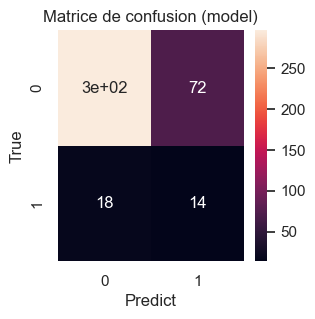

Rapport de classification :
              precision    recall  f1-score   support

         0.0       0.94      0.80      0.87       368
         1.0       0.16      0.44      0.24        32

    accuracy                           0.78       400
   macro avg       0.55      0.62      0.55       400
weighted avg       0.88      0.78      0.82       400



2023/03/13 18:18:43 INFO mlflow.tracking.fluent: Experiment with name 'RFC_07_optimized_final' does not exist. Creating a new experiment.


Logging parameters
Logging metrics
Logging model
Logging CV results matrix
Logging extra data related to the experiment
mlflow-artifacts:/167326045307349001/74fa906f4bdc4a67913cecabdd005694/artifacts
runID: 86f706c2cf04417dbe390e5efe90ca4a
Logging parameters
Logging metrics
Logging model
Logging CV results matrix
Logging extra data related to the experiment
mlflow-artifacts:/167326045307349001/a8553c52f1654c04a0f8437717c176e5/artifacts
runID: c4b80300a5844eba855ad281bd589254
Logging parameters
Logging metrics
Logging model
Logging CV results matrix
Logging extra data related to the experiment
mlflow-artifacts:/167326045307349001/2168a6a0bea34a279164a5ffc993d313/artifacts
runID: 4b3ee62fe1f54e31aaf7ccbc4fc8e374
Logging parameters
Logging metrics
Logging model
Logging CV results matrix
Logging extra data related to the experiment
mlflow-artifacts:/167326045307349001/6b335baa2824477ba144a7c0f983c91b/artifacts
runID: b2bffbbb0feb4bbfac13e2508a83bc58
Logging parameters
Logging metrics
Loggi

In [156]:
# Modèle optimisé RFC avec KBest=230 et UNDER sampling_strategy=0.8 
# On affine les valeurs d'hyperparamètre en fonction de la recherche Random précédente
pipeline = imbpipeline(steps = [['scaler', StandardScaler()],
                                ['kbest', SelectKBest(f_classif, k=230)],
                                #['over_sampling', SMOTE(random_state=10)],
                                ['under_sampling', RandomUnderSampler(sampling_strategy=0.8, random_state=10)],
                                ['classifier', RandomForestClassifier(random_state=10)]
])

# Combinaison des hyperparamètres
hyper_params = {'classifier__n_estimators' : [200, 400],                 
                'classifier__max_depth' : [20,25,30],           
                'classifier__min_samples_leaf' : [1,2,4]
}
            

# Grilles des modèles
stratified_kfold = StratifiedKFold(n_splits=3, shuffle=True, random_state=10)
rfc_grid = GridSearchCV(pipeline, 
                    hyper_params, 
                    scoring='f1', 
                    cv=stratified_kfold
)

# Entraînement
rfc_grid.fit(X_train, y_train)

# Evaluation
print(f'Meilleurs hyperparamètres : {rfc_grid.best_params_}')
print(f'CV f1-score : {rfc_grid.best_score_:.3f}')
rfc_score_f1_optimized, rfc_score_auc_optimized = fct_eval_metrics(rfc_grid.best_estimator_, X_test, y_test)

# MLFlow tracking 
experiment_name = 'RFC_07_optimized_final'
log_results(rfc_grid, experiment_name, 'RFC')

#### Threshold optimization

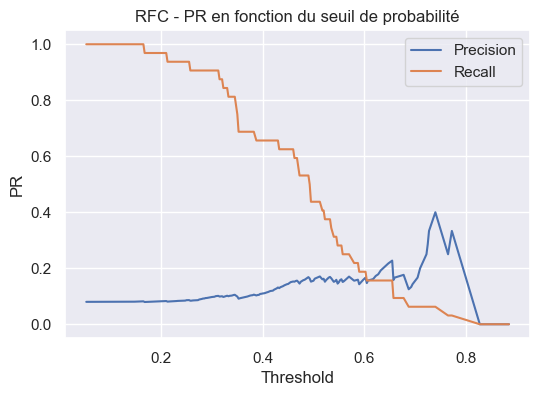

In [157]:
fct_thr_optimized(rfc_grid.best_estimator_, 'RFC')

In [199]:
# Evaluation du modèle final RFC avec meilleur compromis PRECISION/RECALL (f1-score)
# On obtient 1 meilleur f1-score (0.240 --> 0.245)
rfc_score_f1_final, rfc_score_auc_final = eval_model_final(rfc_grid.best_estimator_, X_test, thr=0.48)

Rapport de classification :
              precision    recall  f1-score   support

         0.0       0.95      0.76      0.84       368
         1.0       0.16      0.53      0.24        32

    accuracy                           0.74       400
   macro avg       0.55      0.64      0.54       400
weighted avg       0.89      0.74      0.79       400

f1_score : 0.245
AUC Roc score : 0.659


## Light GBM

#### Balancing optimization

Fitting 3 folds for each of 2 candidates, totalling 6 fits
--------------------------------------------------
Meilleurs hyperparamètres : {'classifier__is_unbalance': False}
CV f1-score : 0.203
f1_score : 0.111
AUC_Roc_score : 0.679


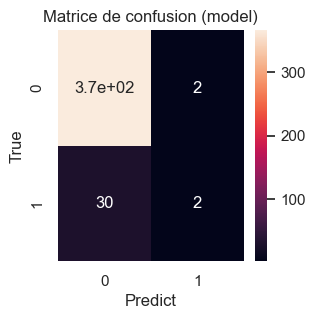

Rapport de classification :
              precision    recall  f1-score   support

         0.0       0.92      0.99      0.96       368
         1.0       0.50      0.06      0.11        32

    accuracy                           0.92       400
   macro avg       0.71      0.53      0.53       400
weighted avg       0.89      0.92      0.89       400



2023/03/14 09:09:36 INFO mlflow.tracking.fluent: Experiment with name 'LGBM_01_unbalance' does not exist. Creating a new experiment.


Logging parameters
Logging metrics
Logging model
Logging CV results matrix
Logging extra data related to the experiment
mlflow-artifacts:/900028815029637700/8bb8275bbe0b40f7a6f8aaf9d78d6bb3/artifacts
runID: 4be16bcce5a14fac90c608ff079925c6
Logging parameters
Logging metrics
Logging model
Logging CV results matrix
Logging extra data related to the experiment
mlflow-artifacts:/900028815029637700/a89239b4c690406cbab08a90a4441810/artifacts
runID: 9ef63787bf034b19b5a3e30d58ac7fc6


In [180]:
# 1) méthode des poids : hyper paramètre is_unbalance or scale_pos_weight du classifieur
pipeline = Pipeline (steps = [['classifier', LGBMClassifier(#objective = 'binary', 
                                                            #early_stopping_rounds= 200,
                                                            #metric = 'auc', # ou f1 ???
                                                            random_state=10)]
])

# Combinaisons des hyperparamètres
hyper_params = {'classifier__is_unbalance' : [True, False]} 

# Grille des modèles avec 3 validations croisées
stratified_kfold = StratifiedKFold(n_splits=3, shuffle=True, random_state=10)
grid = GridSearchCV(estimator=pipeline,
                    param_grid=hyper_params,
                    scoring='f1',  
                    cv=stratified_kfold,
                    verbose=2, # + d'infos lors du run
                    n_jobs=-1)

# Entraînement de la grille
grid.fit(X_train, y_train)

# Evaluation
print('-'*50)
print(f'Meilleurs hyperparamètres : {grid.best_params_}')
print(f'CV f1-score : {grid.best_score_:.3f}')
score_f1_weight, score_auc_weight = fct_eval_metrics(grid.best_estimator_, X_test, y_test)

# MLFlow Tracking 
experiment_name = 'LGBM_01_unbalance'
log_results(grid, experiment_name, 'LGBM')

Fitting 3 folds for each of 27 candidates, totalling 81 fits
--------------------------------------------------
Meilleurs hyperparamètres : {'over_sampling__k_neighbors': 5, 'over_sampling__sampling_strategy': 0.1}
CV f1-score : 0.194
f1_score : 0.108
AUC_Roc_score : 0.7


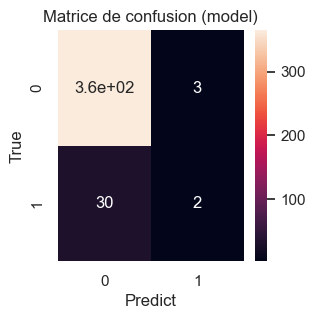

2023/03/14 09:11:35 INFO mlflow.tracking.fluent: Experiment with name 'LGBM_02_over_sampling' does not exist. Creating a new experiment.


Rapport de classification :
              precision    recall  f1-score   support

         0.0       0.92      0.99      0.96       368
         1.0       0.40      0.06      0.11        32

    accuracy                           0.92       400
   macro avg       0.66      0.53      0.53       400
weighted avg       0.88      0.92      0.89       400

Logging parameters
Logging metrics
Logging model
Logging CV results matrix
Logging extra data related to the experiment
mlflow-artifacts:/414396472423033642/4e0d711d0e9d4e9fa5a1572c6b659d87/artifacts
runID: ef4969d6b0964199b241ee77dbe96e27
Logging parameters
Logging metrics
Logging model
Logging CV results matrix
Logging extra data related to the experiment
mlflow-artifacts:/414396472423033642/0c3183c65cf54c65874f62f374d5ec2e/artifacts
runID: 803d0706508a458ab63692f90d2247ed
Logging parameters
Logging metrics
Logging model
Logging CV results matrix
Logging extra data related to the experiment
mlflow-artifacts:/414396472423033642/8fc226f7

In [181]:
# 2) Méthode SMOTE avec optimisation des hyper-paramètres SMOTE
pipeline = imbpipeline(steps = [['scaler', StandardScaler()],
                                ['over_sampling', SMOTE(random_state=10)],
                                ['classifier', LGBMClassifier(random_state=10)]
])

# Combinaisons des hyperparamètres
hyper_params = {'over_sampling__k_neighbors' : [3, 5, 7],
                'over_sampling__sampling_strategy' : np.linspace(0.1, 0.9, 9)
}

# Grille des modèles avec 3 validations croisées
stratified_kfold = StratifiedKFold(n_splits=3, shuffle=True, random_state=10)
grid = GridSearchCV(estimator=pipeline,
                    param_grid=hyper_params,
                    scoring='f1',
                    cv=stratified_kfold,
                    verbose=2,
                    n_jobs=-1)

# Entraînement de la grille
grid.fit(X_train, y_train) 

# Evaluation
print('-'*50)
print(f'Meilleurs hyperparamètres : {grid.best_params_}')
print(f'CV f1-score : {grid.best_score_:.3f}')
score_f1_over, score_auc_over = fct_eval_metrics(grid.best_estimator_, X_test, y_test)

# MLFlow Tracking 
experiment_name = 'LGBM_02_over_sampling'
log_results(grid, experiment_name, 'LGBM')

Fitting 3 folds for each of 9 candidates, totalling 27 fits
--------------------------------------------------
Meilleurs hyperparamètres : {'under_sampling__sampling_strategy': 0.30000000000000004}
CV f1-score : 0.303
f1_score : 0.303
AUC_Roc_score : 0.72


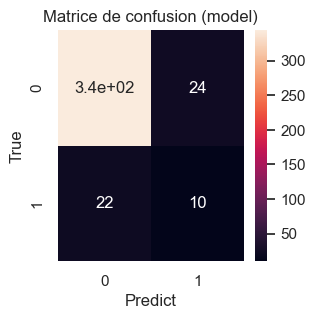

2023/03/14 09:13:14 INFO mlflow.tracking.fluent: Experiment with name 'LGBM_03_under_sampling' does not exist. Creating a new experiment.


Rapport de classification :
              precision    recall  f1-score   support

         0.0       0.94      0.93      0.94       368
         1.0       0.29      0.31      0.30        32

    accuracy                           0.89       400
   macro avg       0.62      0.62      0.62       400
weighted avg       0.89      0.89      0.89       400

Logging parameters
Logging metrics
Logging model
Logging CV results matrix
Logging extra data related to the experiment
mlflow-artifacts:/374622883592595883/0ec9e4675b0440b49bfeee56d4de0ccb/artifacts
runID: 4373a0130d7644f0a388438ebc9dbe1d
Logging parameters
Logging metrics
Logging model
Logging CV results matrix
Logging extra data related to the experiment
mlflow-artifacts:/374622883592595883/afeaefbd8532423ba3e6aaee18000a84/artifacts
runID: 93349490c7dd4fa59a7b1ceb40788335
Logging parameters
Logging metrics
Logging model
Logging CV results matrix
Logging extra data related to the experiment
mlflow-artifacts:/374622883592595883/1dbadd04

In [182]:
# 3) Méthode RandomUnderSampler avec optimisation du taux de Under sampling pour le sous échantillonnage de la classe majoritaire 
pipeline = imbpipeline(steps = [['scaler', StandardScaler()],
                                ['under_sampling', RandomUnderSampler(random_state=10)],
                                ['classifier', LGBMClassifier(random_state=10)]
])

# Combinaison des hyperparamètres
hyper_params = {'under_sampling__sampling_strategy' : np.linspace(0.1, 0.9, 9)}

# Grille des modèles avec 3 validations croisées
stratified_kfold = StratifiedKFold(n_splits=3, shuffle=True, random_state=10)
grid = GridSearchCV(estimator=pipeline,
                    param_grid=hyper_params,
                    scoring='f1',
                    cv=stratified_kfold,
                    verbose=2,
                    n_jobs=-1)

# Entraînement de la grille
grid.fit(X_train, y_train) 

# Evaluation
print('-'*50)
print(f'Meilleurs hyperparamètres : {grid.best_params_}')
print(f'CV f1-score : {grid.best_score_:.3f}')
score_f1_under, score_auc_under = fct_eval_metrics(grid.best_estimator_, X_test, y_test)

# MLFlow Tracking 
experiment_name = 'LGBM_03_under_sampling'
log_results(grid, experiment_name, 'LGBM')

Fitting 3 folds for each of 27 candidates, totalling 81 fits
--------------------------------------------------
Meilleurs hyperparamètres : {'over_sampling__k_neighbors': 7, 'over_sampling__sampling_strategy': 0.1, 'under_sampling__sampling_strategy': 0.4}
CV f1-score : 0.290
f1_score : 0.188
AUC_Roc_score : 0.693


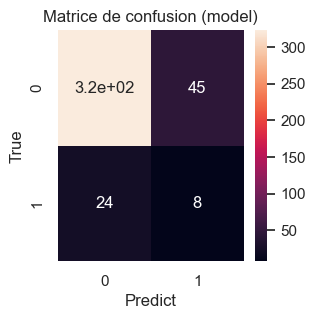

Rapport de classification :
              precision    recall  f1-score   support

         0.0       0.93      0.88      0.90       368
         1.0       0.15      0.25      0.19        32

    accuracy                           0.83       400
   macro avg       0.54      0.56      0.55       400
weighted avg       0.87      0.83      0.85       400



2023/03/14 09:17:10 INFO mlflow.tracking.fluent: Experiment with name 'LGBM_04_overunder_sampling' does not exist. Creating a new experiment.


Logging parameters
Logging metrics
Logging model
Logging CV results matrix
Logging extra data related to the experiment
mlflow-artifacts:/698201083077224240/0d684798dc7840c791a5c3bae0567a41/artifacts
runID: 60362fb4edd14fdaac2bb007e29bdeda
Logging parameters
Logging metrics
Logging model
Logging CV results matrix
Logging extra data related to the experiment
mlflow-artifacts:/698201083077224240/21e77053b5f7459e889fd43b1b3e6eab/artifacts
runID: 00d0bbc3ee184abd9d223bd1d16b9cd0
Logging parameters
Logging metrics
Logging model
Logging CV results matrix
Logging extra data related to the experiment
mlflow-artifacts:/698201083077224240/379f0c57c0364301a497353a8986918e/artifacts
runID: 6ee443814ebc4d70aa4bb780ca9435c7
Logging parameters
Logging metrics
Logging model
Logging CV results matrix
Logging extra data related to the experiment
mlflow-artifacts:/698201083077224240/5deb10e2537a4f50bdbb1ea525b466fa/artifacts
runID: 0888bb5f787a47b8b42bea9969924445
Logging parameters
Logging metrics
Loggi

In [183]:
# 4) Méthode combinée SMOTE + RandomUnderSampler avec optimisation des taux Over/Under sampling 
pipeline = imbpipeline(steps = [['scaler', StandardScaler()],
                                ['over_sampling', SMOTE(random_state=10)],
                                ['under_sampling', RandomUnderSampler(random_state=10)],
                                ['classifier', LGBMClassifier(random_state=10)]
])

# Grille des modèles avec 3 validations croisées
stratified_kfold = StratifiedKFold(n_splits=3, shuffle=True, random_state=10)
hyper_params = {'over_sampling__k_neighbors' : [5, 6, 7],
                'over_sampling__sampling_strategy' : [0.1, 0.2, 0.3],
                'under_sampling__sampling_strategy' : [0.2, 0.3, 0.4]
}
grid = GridSearchCV(estimator=pipeline,
                    param_grid=hyper_params,
                    scoring='f1', # 'f1'/ 'roc_auc'
                    cv=stratified_kfold,
                    verbose=2,
                    n_jobs=-1)

# Entraînement 
grid.fit(X_train, y_train) 

# Evaluation
print('-'*50)
print(f'Meilleurs hyperparamètres : {grid.best_params_}')
print(f'CV f1-score : {grid.best_score_:.3f}')
score_f1_overunder, score_auc_overunder = fct_eval_metrics(grid.best_estimator_, X_test, y_test)

# MLFlow Tracking 
experiment_name = 'LGBM_04_overunder_sampling'
log_results(grid, experiment_name, 'LGBM')

#### Choice of balancing
- under sampling : meilleur performance obtenue sur le TEST set

                     f1-score  auc-score
under_sampling          0.303      0.720
over_under_sampling     0.188      0.693
class_weight            0.111      0.679
over_sampling           0.108      0.700


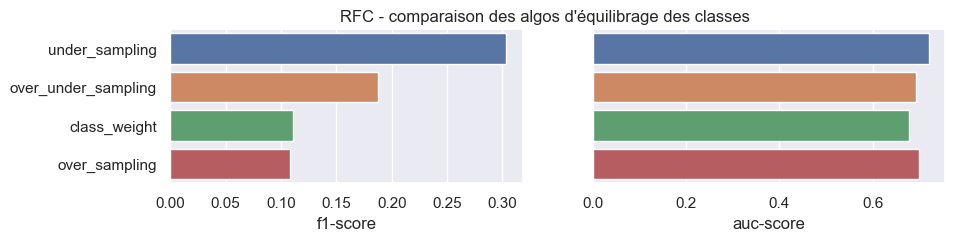

In [184]:
# Comparaison des méthodes d'équilibrage des classes : best = class_weight
fct_compare_result('RFC') # il fallait mettre LGBM pour l'intitulé du titre à la place de 'RFC' 

#### KBest
- Equilibrage **under sampling=0.3** + recherche des KBest features

Fitting 3 folds for each of 14 candidates, totalling 42 fits
--------------------------------------------------
Meilleurs hyperparamètres : {'kbest__k': 260}
CV f1-score : 0.329
f1_score : 0.179
AUC_Roc_score : 0.704


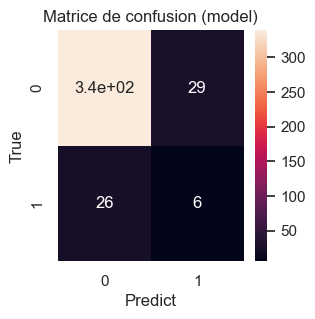

Rapport de classification :
              precision    recall  f1-score   support

         0.0       0.93      0.92      0.92       368
         1.0       0.17      0.19      0.18        32

    accuracy                           0.86       400
   macro avg       0.55      0.55      0.55       400
weighted avg       0.87      0.86      0.87       400



2023/03/14 09:25:18 INFO mlflow.tracking.fluent: Experiment with name 'LGBM_05_under_sampling_kbest' does not exist. Creating a new experiment.


Logging parameters
Logging metrics
Logging model
Logging CV results matrix
Logging extra data related to the experiment
mlflow-artifacts:/571294766861576145/a9a3b015c1d04901bb79048c813573fa/artifacts
runID: ef22d199b8154ba7bc143a618e502230
Logging parameters
Logging metrics
Logging model
Logging CV results matrix
Logging extra data related to the experiment
mlflow-artifacts:/571294766861576145/d4f6627a4fe14fcf8e7df0ca8d0a711e/artifacts
runID: c733327270dd4a87a52ff8236cfec270
Logging parameters
Logging metrics
Logging model
Logging CV results matrix
Logging extra data related to the experiment
mlflow-artifacts:/571294766861576145/d85c36763a894400a5a6e3809251677a/artifacts
runID: 0464affffbb44ca1b24a02eb4bbf78a1
Logging parameters
Logging metrics
Logging model
Logging CV results matrix
Logging extra data related to the experiment
mlflow-artifacts:/571294766861576145/9ccdca82dc7e48f7837040377595dde4/artifacts
runID: 895b3bcdb85143c5a07084ff8795dc27
Logging parameters
Logging metrics
Loggi

In [185]:
# SelectKbest
pipeline = imbpipeline(steps = [['scaler', StandardScaler()],
                                ['kbest', SelectKBest(f_classif)],
                                ['under_sampling', RandomUnderSampler(random_state=10, sampling_strategy=0.3)],
                                ['classifier', LGBMClassifier(random_state=10)]
                                
])

# Combinaisons des hyperparamètres
hyper_params = {'kbest__k' : range(20, 300, 20)}

# Grille des modèles avec 3 validations croisées
stratified_kfold = StratifiedKFold(n_splits=3, shuffle=True, random_state=10) 
grid = GridSearchCV(estimator=pipeline,
                    param_grid=hyper_params,
                    scoring='f1',  # scoring : 'recall'/'f1'/'roc_auc/ fct_metric_business'
                    cv=stratified_kfold,
                    verbose=2,
                    n_jobs=-1)

# Entraînement de la grille
grid.fit(X_train, y_train)

# Evaluation
print('-'*50)
print(f'Meilleurs hyperparamètres : {grid.best_params_}')
print(f'CV f1-score : {grid.best_score_:.3f}')
score_f1_overunder, score_auc_overunder = fct_eval_metrics(grid.best_estimator_, X_test, y_test)

# MLFlow Tracking 
experiment_name = 'LGBM_05_under_sampling_kbest'
log_results(grid, experiment_name, 'LGBM')

#### Hyper-parameters optimization

Fitting 3 folds for each of 50 candidates, totalling 150 fits
Meilleurs hyperparamètres : {'classifier__subsample': 0.1, 'classifier__num_leaves': 60, 'classifier__n_estimators': 100, 'classifier__max_depth': 10, 'classifier__learning_rate': 0.1}
CV f1-score : 0.279
f1_score : 0.209
AUC_Roc_score : 0.698


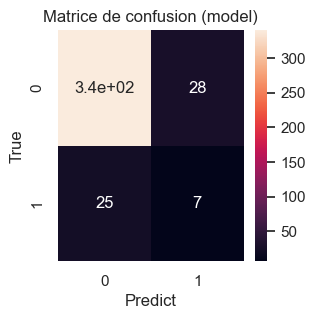

Rapport de classification :
              precision    recall  f1-score   support

         0.0       0.93      0.92      0.93       368
         1.0       0.20      0.22      0.21        32

    accuracy                           0.87       400
   macro avg       0.57      0.57      0.57       400
weighted avg       0.87      0.87      0.87       400



2023/03/14 11:38:32 INFO mlflow.tracking.fluent: Experiment with name 'LGBM_06_optimized_random' does not exist. Creating a new experiment.


Logging parameters
Logging metrics
Logging model
Logging CV results matrix
Logging extra data related to the experiment
mlflow-artifacts:/862936025072295838/f0d4a5c756f5496294f270e09d7a6c0a/artifacts
runID: 9c9f84e5c8614464bf85b4dc7ada0bef
Logging parameters
Logging metrics
Logging model
Logging CV results matrix
Logging extra data related to the experiment
mlflow-artifacts:/862936025072295838/38ae6d6f73db4b729b6a20b25937a55c/artifacts
runID: 717518d7c5fc40e8bee7c10d0910d75d
Logging parameters
Logging metrics
Logging model
Logging CV results matrix
Logging extra data related to the experiment
mlflow-artifacts:/862936025072295838/47921f3af0874432b4a6deb59877ff39/artifacts
runID: fb9f324f9c424d96a69418293a56f05b
Logging parameters
Logging metrics
Logging model
Logging CV results matrix
Logging extra data related to the experiment
mlflow-artifacts:/862936025072295838/7088e61c21ac4dccbaa7b4f88b203be0/artifacts
runID: 6c6bbca6d4d043418dde8754f9b8fa01
Logging parameters
Logging metrics
Loggi

In [190]:
# Réglage des hyperparamètres avec RandomizedSearchCV :
# - Kbest = 260
# - learning_rate,
# - n_estimators : entre 100 et 500 
# - max_depth : entre 5 et 50
# - subsample : entre 0.1 et 1

# SelectKbest
pipeline = imbpipeline(steps = [['scaler', StandardScaler()],
                                ['kbest', SelectKBest(f_classif, k=260)],
                                ['under_sampling', RandomUnderSampler(random_state=10, sampling_strategy=0.3)],
                                ['classifier', LGBMClassifier(metric='auc', random_state=10)] 
                                
])

# Combinaison des hyperparamètres
hyper_params = {'classifier__n_estimators' : [int(x) for x in np.linspace(100, 500, num=5)],
                'classifier__learning_rate' : [0.0001, 0.001, 0.01, 0.1, 0.2, 0.3],
                'classifier__max_depth' : [int(x) for x in np.linspace(5, 50, num=10)], 
                'classifier__num_leaves' : [int(x) for x in np.linspace(20, 200, num=10)],
                'classifier__subsample' : [0.1, 0.3, 0.6, 1.0]
}

# Grilles des modèles
grid = RandomizedSearchCV(estimator=pipeline,
                          param_distributions=hyper_params, 
                          scoring='f1', 
                          cv=3,
                          verbose=2,
                          n_iter=50,
                          n_jobs=-1
)

# Entraînement
grid.fit(X_train, y_train)

# Evaluation
print(f'Meilleurs hyperparamètres : {grid.best_params_}')
print(f'CV f1-score : {grid.best_score_:.3f}')
score_f1_optimized, score_auc_optimized = fct_eval_metrics(grid.best_estimator_, X_test, y_test)

# MLFlow tracking 
experiment_name = 'LGBM_06_optimized_random'
log_results(grid, experiment_name, 'LGBM', grid_type='RamdomizedSearchCV')

Fitting 3 folds for each of 36 candidates, totalling 108 fits
Meilleurs hyperparamètres : {'classifier__learning_rate': 0.1, 'classifier__max_depth': 8, 'classifier__n_estimators': 200, 'classifier__num_leaves': 180, 'classifier__subsample': 0.8}
CV f1-score : 0.311
f1_score : 0.171
AUC_Roc_score : 0.682


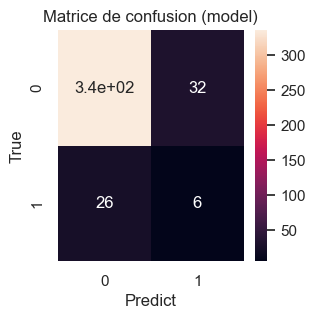

2023/03/14 12:11:40 INFO mlflow.tracking.fluent: Experiment with name 'LGBM_07_optimized_final' does not exist. Creating a new experiment.


Rapport de classification :
              precision    recall  f1-score   support

         0.0       0.93      0.91      0.92       368
         1.0       0.16      0.19      0.17        32

    accuracy                           0.85       400
   macro avg       0.54      0.55      0.55       400
weighted avg       0.87      0.85      0.86       400

Logging parameters
Logging metrics
Logging model
Logging CV results matrix
Logging extra data related to the experiment
mlflow-artifacts:/780015948036003963/55c7ebbab83a43bea73c6340422a7873/artifacts
runID: 1d314d4d233048ac90eb06efcaf0e749
Logging parameters
Logging metrics
Logging model
Logging CV results matrix
Logging extra data related to the experiment
mlflow-artifacts:/780015948036003963/b53f8a3c2f924d5da73733017492e1e2/artifacts
runID: 720ed62be50640738ba4019c13c7202f
Logging parameters
Logging metrics
Logging model
Logging CV results matrix
Logging extra data related to the experiment
mlflow-artifacts:/780015948036003963/7e933e96

In [192]:
# Modèle optimisé LGBM avec KBest=260 et UNDER sampling_strategy=0.3 
# On affine les valeurs d'hyperparamètre en fonction de la recherche Random précédente
pipeline = imbpipeline(steps = [['scaler', StandardScaler()],
                                ['kbest', SelectKBest(f_classif, k=260)],
                                ['under_sampling', RandomUnderSampler(random_state=10, sampling_strategy=0.3)],
                                ['classifier', LGBMClassifier(random_state=10)] # ??? metric='auc' or 'f1' ???
                                
])

# Combinaison des hyperparamètres
hyper_params = {'classifier__n_estimators' : [200],
                'classifier__learning_rate' : [0.1, 0.2],
                'classifier__max_depth' : [8, 10, 12],
                'classifier__num_leaves' : [180, 200, 220],
                'classifier__subsample' : [0.8, 1.0]
}           

# Grilles des modèles
stratified_kfold = StratifiedKFold(n_splits=3, shuffle=True, random_state=10)
lgbm_grid = GridSearchCV(pipeline, 
                         hyper_params, 
                         scoring='f1', 
                         cv=stratified_kfold,
                         verbose=2,
                         n_jobs=-1
)

# Entraînement
lgbm_grid.fit(X_train, y_train)

# Evaluation
print(f'Meilleurs hyperparamètres : {lgbm_grid.best_params_}')
print(f'CV f1-score : {lgbm_grid.best_score_:.3f}')
lgbm_score_f1_optimized, lgbm_score_auc_optimized = fct_eval_metrics(lgbm_grid.best_estimator_, X_test, y_test)

# MLFlow tracking 
experiment_name = 'LGBM_07_optimized_final'
log_results(lgbm_grid, experiment_name, 'LGBM')

#### Threshold optimization

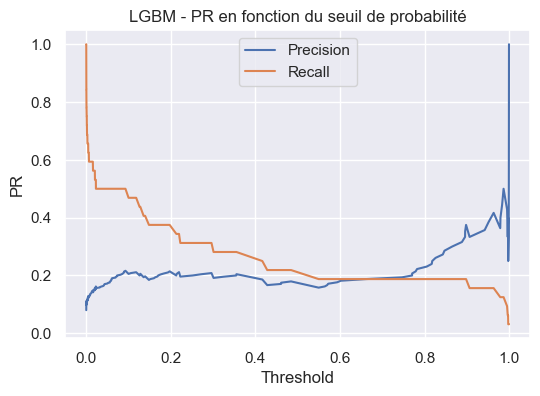

In [193]:
fct_thr_optimized(lgbm_grid.best_estimator_, 'LGBM')

In [197]:
# Evaluation du modèle final LGBM avec meilleur compromis PRECISION/RECALL (f1-score)
# On obtient 1 meilleur f1-score (0.171 --> 0.302)
lgbm_score_f1_final, lgbm_score_auc_final = eval_model_final(lgbm_grid.best_estimator_, X_test, thr=0.09)

Rapport de classification :
              precision    recall  f1-score   support

         0.0       0.95      0.84      0.89       368
         1.0       0.22      0.50      0.30        32

    accuracy                           0.81       400
   macro avg       0.58      0.67      0.60       400
weighted avg       0.89      0.81      0.85       400

f1_score : 0.302
AUC Roc score : 0.682


## Results

In [83]:
# Résultats
# Comparaison de la performance des modèles optimisés finaux avec seuil optimal de classification
def fct_compare_result_final(svc=False):
    if svc:
        df_result = pd.DataFrame(data={'f1-score' : [base_score_f1, svc_score_f1_final, log_score_f1_final, rfc_score_f1_final, lgbm_score_f1_final],
                                       'auc-score' : [base_score_auc, svc_score_auc_final, log_score_auc_final, rfc_score_auc_final, lgbm_score_auc_final]},
                                       index=['BASE', 'SVC', 'LOG', 'RFC', 'LGBM'])
    
    else:
        df_result = pd.DataFrame(data={'f1-score' : [log_score_f1_final, rfc_score_f1_final, lgbm_score_f1_final],
                                       'auc-score' : [log_score_auc_final, rfc_score_auc_final, lgbm_score_auc_final]},
                                       index=['LOG', 'RFC', 'LGBM'])
    """
    else:
        df_result = pd.DataFrame(data={'f1-score' : [base_score_f1, log_score_f1_final, rfc_score_f1_final, lgbm_score_f1_final],
                                       'auc-score' : [base_score_auc, log_score_auc_final, rfc_score_auc_final, lgbm_score_auc_final]},
                                       index=['BASE', 'LOG', 'RFC', 'LGBM'])
    """
    
    df_result = df_result.sort_values(by='f1-score', ascending=False)
    print(df_result)
    
    sns.set()
    fig = plt.figure(figsize=(10,2))
    plt.suptitle(f'Performance des modèles finaux optimisés (seuil de classif optimal)', fontsize=12)

    # barplot f1-score
    plt.subplot(1,2,1)
    sns.barplot(data=df_result, y=df_result.index, x='f1-score')

    # barplot auc-score
    plt.subplot(1,2,2)
    sns.barplot(data=df_result, y=df_result.index, x='auc-score')
    plt.yticks([])
    plt.show()    

In [84]:
fct_compare_result_final()

NameError: name 'log_score_f1_final' is not defined

Fitting 3 folds for each of 36 candidates, totalling 108 fits
Meilleurs hyperparamètres : {'classifier__learning_rate': 0.1, 'classifier__max_depth': 8, 'classifier__n_estimators': 200, 'classifier__num_leaves': 180, 'classifier__subsample': 0.8}
CV custom-score : -0.479
Custom-score : 0.595
f1_score : 0.171
AUC_Roc_score : 0.682


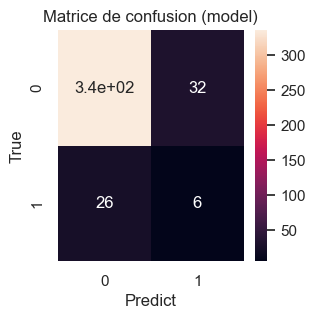

Rapport de classification :
              precision    recall  f1-score   support

         0.0       0.93      0.91      0.92       368
         1.0       0.16      0.19      0.17        32

    accuracy                           0.85       400
   macro avg       0.54      0.55      0.55       400
weighted avg       0.87      0.85      0.86       400

Logging parameters
Logging metrics
Logging model
Logging CV results matrix
Logging extra data related to the experiment
mlflow-artifacts:/444498891241789047/784c64f172024c34bd61606532d4713d/artifacts
runID: 91ec5e7bb1aa4707842f77ec1af14a42
Logging parameters
Logging metrics
Logging model
Logging CV results matrix
Logging extra data related to the experiment
mlflow-artifacts:/444498891241789047/52d5366834e04e238d737e73d57ec4f9/artifacts
runID: 20f3934c202a42cca8783c9ca7a375fc
Logging parameters
Logging metrics
Logging model
Logging CV results matrix
Logging extra data related to the experiment
mlflow-artifacts:/444498891241789047/5590a72f

In [298]:
# Application de la métrique métier (custom_score) sur le Modèle optimisé LGBM avec KBest=260 et UNDER sampling_strategy=0.3 
# On affine les valeurs d'hyperparamètre en fonction de la recherche Random précédente
pipeline = imbpipeline(steps = [['scaler', StandardScaler()],
                                ['kbest', SelectKBest(f_classif, k=260)],
                                ['under_sampling', RandomUnderSampler(random_state=10, sampling_strategy=0.3)],
                                ['classifier', LGBMClassifier(random_state=10)]
                                
])

# Combinaison des hyperparamètres
hyper_params = {'classifier__n_estimators' : [200],
                'classifier__learning_rate' : [0.1, 0.2],
                'classifier__max_depth' : [8, 10, 12],
                'classifier__num_leaves' : [180, 200, 220],
                'classifier__subsample' : [0.8, 1.0]
}           

# Grilles des modèles avec évaluation de la métrique métier "custom_score"
stratified_kfold = StratifiedKFold(n_splits=3, shuffle=True, random_state=10)
lgbm_grid = GridSearchCV(pipeline, 
                         hyper_params, 
                         scoring=custom_score, 
                         cv=stratified_kfold,
                         verbose=2,
                         n_jobs=-1
)

# Entraînement
lgbm_grid.fit(X_train, y_train)

# Evaluation
print(f'Meilleurs hyperparamètres : {lgbm_grid.best_params_}')
# Custom score
print(f'CV custom-score : {lgbm_grid.best_score_:.3f}')
y_pred = lgbm_grid.best_estimator_.predict(X_test)
print(f'Custom-score : {fct_custom_metric(y_test, y_pred):.3f}')
# f1 score, auc score
lgbm_score_f1_optimized, lgbm_score_auc_optimized = fct_eval_metrics(lgbm_grid.best_estimator_, X_test, y_test)

# MLFlow tracking 
experiment_name = 'LGBM_08_optimized_metric'
log_results(lgbm_grid, experiment_name, 'LGBM')

In [293]:
y_pred = lgbm_grid.best_estimator_.predict(X_test)
#print(f'Custom-score : {fct_custom_metric(y_test, y_pred):.3f}')
FNFPR_score = fct_custom_metric(y_test, y_pred)
print(f'FNFPR={FNFPR_score:.3f}')

FNFPR=0.450


# Optimization (All samples)
On a optimisé et évalué 4 modèles de classification sur un échantillon de 2000 individus pour avoir une idée des performances et des réglages des hyperparamètres.

On choisit maintenant d'optimiser et d'évaluer 3 modèles (LOG, LGBM, RFC) sur l'échantillon complet du dataset (> 300 000 individus) : 
- LOG (Regression Logistique) : modèle simple, rapide à optimiser et prenant moins d'espace disque pour le déploiement en production
- LGBM (Light Gradient Boosting) : modèle le plus performant sur l'échantillon de 2000 individus
- RFC (Random Forest Classifier)

Remarques : 
- SVC (Support Vector Classifier) n'est pas adapté à un échantillon important et ne sera donc pas modélisé
- On choisit d'équilibrer les classes avec la méthode de sous échantillonnage qui a recueilli le meilleur score pour 2 des 3 modèles (LGBM et RFC)

In [7]:
# Lecture du fichier des data
df = pd.read_csv('df_scenario_0.csv')
df.drop('Unnamed: 0', axis=1, inplace=True)
print(f'Dimensions : {df.shape}')

Dimensions : (356251, 803)


In [8]:
# Nettoyage des data
df_all = df.copy()
df_all = df_all[~df_all['TARGET'].isna()] # TARGET = 0/1
df_all = fct_clean_data(df_all)

In [9]:
# Distribution par TARGET
print(df_all.shape)
print(df_all['TARGET'].value_counts())

(307507, 803)
0.0    282682
1.0     24825
Name: TARGET, dtype: int64


In [10]:
# Split du TRAIN set en TRAIN/TEST sets
df_train, df_test = train_test_split(df_all, test_size=0.20, stratify=df_all['TARGET'], random_state=0)
print(f'Dimension Train set : {df_train.shape}')
print(f'Dimension Test set : {df_test.shape}')

Dimension Train set : (246005, 803)
Dimension Test set : (61502, 803)


In [20]:
X_train, y_train = fct_preprocessing(df_train, 'TRAIN')
print('-'*50)
X_test, y_test = fct_preprocessing(df_test, 'TEST')

# Normalisation standard (PAS BESOIN pour LOG, LGBM ni RANDOM FOREST) 
#scaler = StandardScaler()
#X_train_std = scaler.fit_transform(X_train)
#X_test_std = scaler.transform(X_test) 

print('-'*50)
print(f'Dimension Train set : {X_train.shape}')
print(f'Dimension Test set : {X_test.shape}')

TRAIN set : Fill NaN par 0...
Nb de lignes NaN : 0
TRAIN set - distribution par classe :
0.0    226135
1.0     19858
Name: TARGET, dtype: int64
--------------------------------------------------
TEST set : Fill NaN par 0...
Nb de lignes NaN : 0
TEST set - distribution par classe :
0.0    56530
1.0     4965
Name: TARGET, dtype: int64
--------------------------------------------------
Dimension Train set : (245993, 802)
Dimension Test set : (61495, 802)


## Baseline

f1_score : 0.0
custom_score : 0.1
AUC_Roc_score : 0.5


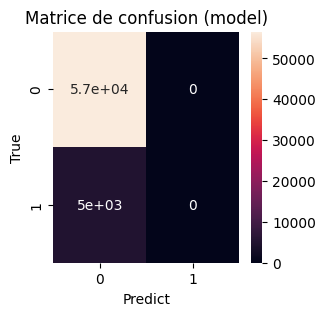

Rapport de classification :
              precision    recall  f1-score   support

         0.0       0.92      1.00      0.96     56530
         1.0       0.00      0.00      0.00      4965

    accuracy                           0.92     61495
   macro avg       0.46      0.50      0.48     61495
weighted avg       0.85      0.92      0.88     61495



In [21]:
# Modèle de classification baseline 
dummy_clf = DummyClassifier(strategy='most_frequent', random_state=0) # prédit toujours la classe la + fréquente indépendamment de X
dummy_clf.fit(X_train, y_train)
base_score_f1, base_score_auc = fct_eval_metrics(dummy_clf, X_test, y_test)

In [22]:
# Fonction générale de traitement d'une pipeline de classification avec tracking MLFlow
def fct_pipeline(pipeline, hyper_params, kfold, scoring, experiment_name, classifier_name, gridsearchcv=True, tracking=True):
    if gridsearchcv:
        grid = GridSearchCV(estimator=pipeline, param_grid=hyper_params, scoring=scoring, cv=kfold, verbose=2)
    else:
        grid = RandomizedSearchCV(estimator=pipeline, param_distributions=hyper_params, scoring=scoring, cv=3, n_iter=30)
    grid.fit(X_train, y_train)
    # Estimation
    print('-'*50)
    print(f'Meilleurs hyperparamètres : {grid.best_params_}')
    print(f'CV {scoring}-score : {grid.best_score_:.3f}')
    best_model = grid.best_estimator_
    score_f1, score_auc = fct_eval_metrics(grid.best_estimator_, X_test, y_test)
    # MLFlow Tracking
    if tracking: 
        log_results(grid, experiment_name, classifier_name, grid_type='GridSearchCV' if gridsearchcv else 'RamdomizedSearchCV')
    # Retourne le meilleur model et les scores
    return best_model, score_f1, score_auc

## Regression Logistic

### Base
- paramètres de base

f1_score : 0.049
custom_score : 0.1
AUC_Roc_score : 0.771


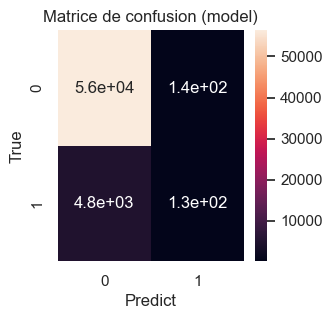

Rapport de classification :
              precision    recall  f1-score   support

         0.0       0.92      1.00      0.96     56530
         1.0       0.48      0.03      0.05      4965

    accuracy                           0.92     61495
   macro avg       0.70      0.51      0.50     61495
weighted avg       0.89      0.92      0.88     61495



In [114]:
# Evaluation de la Régression Logistique avec les paramètres de base
log_model_base = Pipeline (steps = [['scaler', StandardScaler()],
                              ['classifier', LogisticRegression(random_state=10)]
])
log_model_base.fit(X_train, y_train)
# Evaluation
log_score_f1_base, log_score_auc_base = fct_eval_metrics(log_model_base, X_test, y_test)
# MLFlow Tracking 
#experiment_name = 'All_LOG_01_class_weight'
#log_results(grid, experiment_name, 'LOG')

### Balancing optimization

Fitting 3 folds for each of 10 candidates, totalling 30 fits
[CV] END ........classifier__class_weight={0: 0.08, 1: 0.92}; total time=  14.9s
[CV] END ........classifier__class_weight={0: 0.08, 1: 0.92}; total time=  23.8s
[CV] END ........classifier__class_weight={0: 0.08, 1: 0.92}; total time=  22.9s
[CV] END classifier__class_weight={0: 0.0811111111111111, 1: 0.9188888888888889}; total time=  22.9s
[CV] END classifier__class_weight={0: 0.0811111111111111, 1: 0.9188888888888889}; total time=  23.0s
[CV] END classifier__class_weight={0: 0.0811111111111111, 1: 0.9188888888888889}; total time=  25.8s
[CV] END classifier__class_weight={0: 0.08222222222222222, 1: 0.9177777777777778}; total time=  24.8s
[CV] END classifier__class_weight={0: 0.08222222222222222, 1: 0.9177777777777778}; total time=  23.9s
[CV] END classifier__class_weight={0: 0.08222222222222222, 1: 0.9177777777777778}; total time=  25.3s
[CV] END classifier__class_weight={0: 0.08333333333333333, 1: 0.9166666666666666}; tota

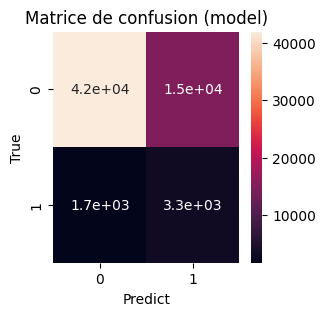

Rapport de classification :
              precision    recall  f1-score   support

         0.0       0.96      0.74      0.84     56530
         1.0       0.18      0.66      0.29      4965

    accuracy                           0.73     61495
   macro avg       0.57      0.70      0.56     61495
weighted avg       0.90      0.73      0.79     61495



2023/03/16 00:34:26 INFO mlflow.tracking.fluent: Experiment with name 'All_LOG_01_class_weight' does not exist. Creating a new experiment.


Logging parameters
Logging metrics
Logging model
Logging CV results matrix
Logging extra data related to the experiment
mlflow-artifacts:/610881525616955134/cc79743ada244bceb53000c077969198/artifacts
runID: a6369cf6eabe4f48840b77026793e6cc
Logging parameters
Logging metrics
Logging model
Logging CV results matrix
Logging extra data related to the experiment
mlflow-artifacts:/610881525616955134/d6706efe2e4a432fac676501974621ac/artifacts
runID: 7972236a7ad442009a19175fb0204377
Logging parameters
Logging metrics
Logging model
Logging CV results matrix
Logging extra data related to the experiment
mlflow-artifacts:/610881525616955134/74082698aae341339731f4881925d75c/artifacts
runID: 44045a5f72f14e5e9502977975f16702
Logging parameters
Logging metrics
Logging model
Logging CV results matrix
Logging extra data related to the experiment
mlflow-artifacts:/610881525616955134/75fa1ae82de94de4bc5da5502b201341/artifacts
runID: 0cff3463102b4cee91ac1238c7270b0a
Logging parameters
Logging metrics
Loggi

In [21]:
# 1) Méthode des poids : hyper paramètre class_weight du classifieur
pipeline = Pipeline (steps = [['scaler', StandardScaler()],
                              ['classifier', LogisticRegression(random_state=10)]
])

# Combinaisons des hyperparamètres
weights = np.linspace(0.080, 0.090, 10) # poids = inversement proportionnel à la distribution / classe
hyper_params = {'classifier__class_weight' : [{0 : x, 1 : 1.0-x} for x in weights]}

# Grille des modèles avec 3 validations croisées
stratified_kfold = StratifiedKFold(n_splits=3, shuffle=True, random_state=10)

# Pipeline de classification
best_model, score_f1_weight, score_auc_weight = fct_pipeline(pipeline, hyper_params, stratified_kfold, 'f1', 'All_LOG_01_class_weight', 'LOG')

Fitting 3 folds for each of 27 candidates, totalling 81 fits
[CV] END over_sampling__k_neighbors=3, over_sampling__sampling_strategy=0.1; total time=  17.8s
[CV] END over_sampling__k_neighbors=3, over_sampling__sampling_strategy=0.1; total time=  22.3s
[CV] END over_sampling__k_neighbors=3, over_sampling__sampling_strategy=0.1; total time=  31.0s
[CV] END over_sampling__k_neighbors=3, over_sampling__sampling_strategy=0.2; total time=  33.5s
[CV] END over_sampling__k_neighbors=3, over_sampling__sampling_strategy=0.2; total time=  32.0s
[CV] END over_sampling__k_neighbors=3, over_sampling__sampling_strategy=0.2; total time=  33.0s
[CV] END over_sampling__k_neighbors=3, over_sampling__sampling_strategy=0.30000000000000004; total time=  34.3s
[CV] END over_sampling__k_neighbors=3, over_sampling__sampling_strategy=0.30000000000000004; total time=  36.8s
[CV] END over_sampling__k_neighbors=3, over_sampling__sampling_strategy=0.30000000000000004; total time=  26.5s
[CV] END over_sampling__k_n

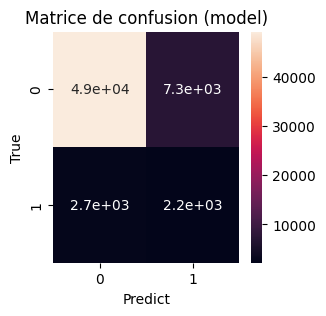

Rapport de classification :
              precision    recall  f1-score   support

         0.0       0.95      0.87      0.91     56530
         1.0       0.23      0.45      0.31      4965

    accuracy                           0.84     61495
   macro avg       0.59      0.66      0.61     61495
weighted avg       0.89      0.84      0.86     61495



2023/03/16 01:13:30 INFO mlflow.tracking.fluent: Experiment with name 'All_LOG_02_over_sampling' does not exist. Creating a new experiment.


Logging parameters
Logging metrics
Logging model
Logging CV results matrix
Logging extra data related to the experiment
mlflow-artifacts:/284739499554007220/76e67c2d719347c99eed7a46dc3c6a4d/artifacts
runID: 5063dc73446946578137c37a646e6f5f
Logging parameters
Logging metrics
Logging model
Logging CV results matrix
Logging extra data related to the experiment
mlflow-artifacts:/284739499554007220/af0b7844a0624007a6bd48b81f5959fb/artifacts
runID: e7b68f0dc6c04594acfd5f8b3a77da66
Logging parameters
Logging metrics
Logging model
Logging CV results matrix
Logging extra data related to the experiment
mlflow-artifacts:/284739499554007220/0f450de0e3e941d7b22811f09658ae02/artifacts
runID: 6dd72066c41c4abca0e00395a5821826
Logging parameters
Logging metrics
Logging model
Logging CV results matrix
Logging extra data related to the experiment
mlflow-artifacts:/284739499554007220/95d52a94f1d847169557c388373ea7a5/artifacts
runID: 35769a0431674112b71eb5a232e73427
Logging parameters
Logging metrics
Loggi

In [22]:
# 2) Méthode SMOTE avec optimisation des hyper-paramètres SMOTE
pipeline = imbpipeline(steps = [['scaler', StandardScaler()],
                                ['over_sampling', SMOTE(random_state=10)],
                                ['classifier', LogisticRegression(random_state=10)]
])

# Combinaisons des hyperparamètres
hyper_params = {'over_sampling__k_neighbors' : [3, 5, 7],
                'over_sampling__sampling_strategy' : np.linspace(0.1, 0.9, 9)
}

# Grille des modèles avec 3 validations croisées
stratified_kfold = StratifiedKFold(n_splits=3, shuffle=True, random_state=10)

# Pipeline de classification
best_model, score_f1_over, score_auc_over = fct_pipeline(pipeline, hyper_params, stratified_kfold, 'f1', 'All_LOG_02_over_sampling', 'LOG')

Fitting 3 folds for each of 9 candidates, totalling 27 fits
[CV] END ..............under_sampling__sampling_strategy=0.1; total time=  23.9s
[CV] END ..............under_sampling__sampling_strategy=0.1; total time=  28.8s
[CV] END ..............under_sampling__sampling_strategy=0.1; total time=  27.1s
[CV] END ..............under_sampling__sampling_strategy=0.2; total time=  17.3s
[CV] END ..............under_sampling__sampling_strategy=0.2; total time=  18.8s
[CV] END ..............under_sampling__sampling_strategy=0.2; total time=  23.2s
[CV] END under_sampling__sampling_strategy=0.30000000000000004; total time=  17.9s
[CV] END under_sampling__sampling_strategy=0.30000000000000004; total time=  18.2s
[CV] END under_sampling__sampling_strategy=0.30000000000000004; total time=  17.1s
[CV] END ..............under_sampling__sampling_strategy=0.4; total time=  16.8s
[CV] END ..............under_sampling__sampling_strategy=0.4; total time=  14.1s
[CV] END ..............under_sampling__samp

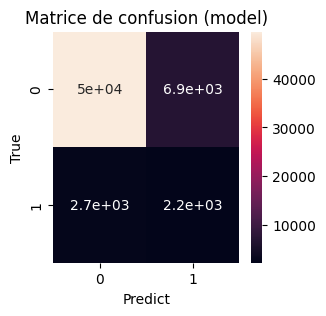

Rapport de classification :
              precision    recall  f1-score   support

         0.0       0.95      0.88      0.91     56530
         1.0       0.25      0.45      0.32      4965

    accuracy                           0.84     61495
   macro avg       0.60      0.67      0.62     61495
weighted avg       0.89      0.84      0.86     61495



2023/03/16 01:25:46 INFO mlflow.tracking.fluent: Experiment with name 'All_LOG_03_under_sampling' does not exist. Creating a new experiment.


Logging parameters
Logging metrics
Logging model
Logging CV results matrix
Logging extra data related to the experiment
mlflow-artifacts:/945809366531534457/324e1ea1aedb455ba4a6a8a859d03f0f/artifacts
runID: 54e62c9f8f0246f59d7fac18d42b8ae2
Logging parameters
Logging metrics
Logging model
Logging CV results matrix
Logging extra data related to the experiment
mlflow-artifacts:/945809366531534457/d9a9717373a8410c8a3d9052144479a7/artifacts
runID: eea157d600414f79960a214b55f08105
Logging parameters
Logging metrics
Logging model
Logging CV results matrix
Logging extra data related to the experiment
mlflow-artifacts:/945809366531534457/9332b833402447688c7dff9b03c58842/artifacts
runID: ae60422d99614702ad8022ac67be22de
Logging parameters
Logging metrics
Logging model
Logging CV results matrix
Logging extra data related to the experiment
mlflow-artifacts:/945809366531534457/63532a98c37f4d8b8adc80341780fe16/artifacts
runID: b5b74a437263495baa930de3e01b4027
Logging parameters
Logging metrics
Loggi

In [23]:
# 3) Méthode RandomUnderSampler avec optimisation du taux de Under sampling pour le sous échantillonnage de la classe majoritaire 
pipeline = imbpipeline(steps = [['scaler', StandardScaler()],
                                ['under_sampling', RandomUnderSampler(random_state=10)],
                                ['classifier', LogisticRegression(random_state=10)]
])

# Grille des modèles avec 3 validations croisées 
stratified_kfold = StratifiedKFold(n_splits=3, shuffle=True, random_state=10)
hyper_params = {'under_sampling__sampling_strategy' : np.linspace(0.1, 0.9, 9)}

# Pipeline de classification
best_model, score_f1_under, score_auc_under = fct_pipeline(pipeline, hyper_params, stratified_kfold, 'f1', 'All_LOG_03_under_sampling', 'LOG')

Fitting 3 folds for each of 27 candidates, totalling 81 fits
[CV] END over_sampling__k_neighbors=2, over_sampling__sampling_strategy=0.4, under_sampling__sampling_strategy=0.4; total time= 1.2min
[CV] END over_sampling__k_neighbors=2, over_sampling__sampling_strategy=0.4, under_sampling__sampling_strategy=0.4; total time= 1.4min
[CV] END over_sampling__k_neighbors=2, over_sampling__sampling_strategy=0.4, under_sampling__sampling_strategy=0.4; total time= 1.4min
[CV] END over_sampling__k_neighbors=2, over_sampling__sampling_strategy=0.4, under_sampling__sampling_strategy=0.5; total time= 1.3min
[CV] END over_sampling__k_neighbors=2, over_sampling__sampling_strategy=0.4, under_sampling__sampling_strategy=0.5; total time= 1.4min
[CV] END over_sampling__k_neighbors=2, over_sampling__sampling_strategy=0.4, under_sampling__sampling_strategy=0.5; total time= 1.3min
[CV] END over_sampling__k_neighbors=2, over_sampling__sampling_strategy=0.4, under_sampling__sampling_strategy=0.6; total time= 1

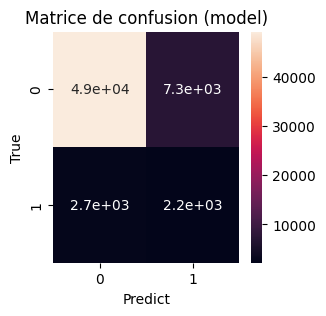

Rapport de classification :
              precision    recall  f1-score   support

         0.0       0.95      0.87      0.91     56530
         1.0       0.23      0.45      0.31      4965

    accuracy                           0.84     61495
   macro avg       0.59      0.66      0.61     61495
weighted avg       0.89      0.84      0.86     61495



2023/03/16 02:01:29 INFO mlflow.tracking.fluent: Experiment with name 'All_LOG_04_overunder_sampling' does not exist. Creating a new experiment.


Logging parameters
Logging metrics
Logging model
Logging CV results matrix
Logging extra data related to the experiment
mlflow-artifacts:/947187047178384715/29f2e1749a284dcfbc550ac9df0f2b12/artifacts
runID: a2696eb12c2d40718f025e3f7b9eadfb
Logging parameters
Logging metrics
Logging model
Logging CV results matrix
Logging extra data related to the experiment
mlflow-artifacts:/947187047178384715/a5741a0b32d841748f7e2b6d29d4dd5e/artifacts
runID: ec2cc625b3df4a8db36448a753e14007
Logging parameters
Logging metrics
Logging model
Logging CV results matrix
Logging extra data related to the experiment
mlflow-artifacts:/947187047178384715/25564659c3184fd0897c47928a219633/artifacts
runID: 381ef288314c4f26b8788e97c0f91cee
Logging parameters
Logging metrics
Logging model
Logging CV results matrix
Logging extra data related to the experiment
mlflow-artifacts:/947187047178384715/da42c31b15ec4e00821d6c90fa791a21/artifacts
runID: 2feb0e2e942848bc9bd1a941cb66b7b8
Logging parameters
Logging metrics
Loggi

In [24]:
# 4) Méthode combinée SMOTE + RandomUnderSampler avec optimisation des taux Over/Under sampling 
pipeline = imbpipeline(steps = [['scaler', StandardScaler()],
                                ['over_sampling', SMOTE(random_state=10)],
                                ['under_sampling', RandomUnderSampler(random_state=10)],
                                ['classifier', LogisticRegression(random_state=10)]
])

# Grille des modèles avec 3 validations croisées
stratified_kfold = StratifiedKFold(n_splits=3, shuffle=True, random_state=10)
hyper_params = {'over_sampling__k_neighbors' : [2, 3, 4],
                'over_sampling__sampling_strategy' : [0.4, 0.5, 0.6],
                'under_sampling__sampling_strategy' : [0.4, 0.5, 0.6]
}

# Pipeline de classification
best_model, score_f1_overunder, score_auc_overunder = fct_pipeline(pipeline, hyper_params, stratified_kfold, 'f1', 'All_LOG_04_overunder_sampling', 'LOG')

Choice of balancing
- Méthode under sampling (strategy=0.5) : meilleur **score f1** obtenu sur la **CV**(Cf. log MLFlow) ET sur le **TEST set** 

                     f1-score  auc-score
under_sampling          0.319      0.771
over_sampling           0.307      0.760
over_under_sampling     0.306      0.761
class_weight            0.287      0.772


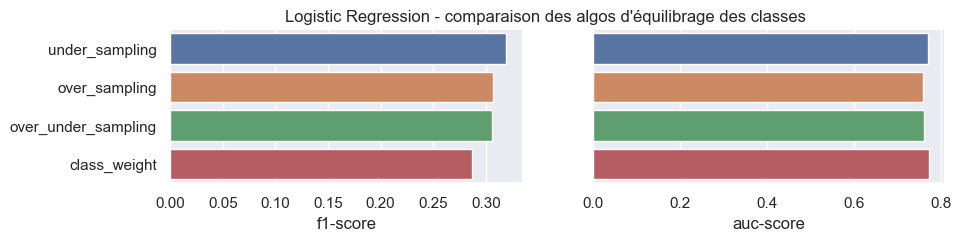

In [27]:
# Comparaison de l'évaluation des méthodes d'équilibrage des classes sur le TEST set
fct_compare_result('Logistic Regression')

### Kbest features

Fitting 3 folds for each of 15 candidates, totalling 45 fits
[CV] END ........................................kbest__k=20; total time=   3.3s
[CV] END ........................................kbest__k=20; total time=   3.0s
[CV] END ........................................kbest__k=20; total time=   3.4s
[CV] END ........................................kbest__k=40; total time=   3.7s
[CV] END ........................................kbest__k=40; total time=   3.7s
[CV] END ........................................kbest__k=40; total time=   3.5s
[CV] END ........................................kbest__k=60; total time=   4.8s
[CV] END ........................................kbest__k=60; total time=   5.1s
[CV] END ........................................kbest__k=60; total time=   5.3s
[CV] END ........................................kbest__k=80; total time=   5.3s
[CV] END ........................................kbest__k=80; total time=   5.0s
[CV] END .......................................

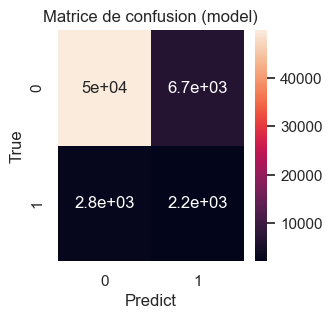

Rapport de classification :
              precision    recall  f1-score   support

         0.0       0.95      0.88      0.91     56530
         1.0       0.25      0.44      0.31      4965

    accuracy                           0.85     61495
   macro avg       0.60      0.66      0.61     61495
weighted avg       0.89      0.85      0.86     61495



2023/03/16 02:32:20 INFO mlflow.tracking.fluent: Experiment with name 'All_LOG_05_under_sampling_kbest' does not exist. Creating a new experiment.


Logging parameters
Logging metrics
Logging model
Logging CV results matrix
Logging extra data related to the experiment
mlflow-artifacts:/299145055842965183/e8c3ca4ca9e3499f8655613cf35ffa78/artifacts
runID: 2b019d0ad62542b6a6430f2c84e6e428
Logging parameters
Logging metrics
Logging model
Logging CV results matrix
Logging extra data related to the experiment
mlflow-artifacts:/299145055842965183/4ef53e8588ed430caca811e5281f7299/artifacts
runID: 87d40ebc6edc4eeeb4ea60ae2dfcbc69
Logging parameters
Logging metrics
Logging model
Logging CV results matrix
Logging extra data related to the experiment
mlflow-artifacts:/299145055842965183/d3e2e70a98974b9085a844fc06cb91b0/artifacts
runID: 62d1e98c72c44f569d3a61970396bf15
Logging parameters
Logging metrics
Logging model
Logging CV results matrix
Logging extra data related to the experiment
mlflow-artifacts:/299145055842965183/9b743a652d40411489df4a9dccf407f6/artifacts
runID: dba5616b0c9248888d56f23927ef1462
Logging parameters
Logging metrics
Loggi

In [28]:
# 5) SelectKbest
pipeline = imbpipeline(steps = [['scaler', StandardScaler()],
                                ['under_sampling', RandomUnderSampler(sampling_strategy=0.5, random_state=10)],
                                ['kbest', SelectKBest(f_classif)],
                                ['classifier', LogisticRegression(random_state=10)]
])

# Combinaisons des hyperparamètres (K entre 20 et 300 par pas de 20)
hyper_params = {'kbest__k' : range(20, 320, 20)}

# Grille des modèles avec 3 validations croisées
stratified_kfold = StratifiedKFold(n_splits=3, shuffle=True, random_state=10) 

# Pipeline de classification
best_model, score_f1_kbest, score_auc_kbest = fct_pipeline(pipeline, hyper_params, stratified_kfold, 'f1', 'All_LOG_05_under_sampling_kbest', 'LOG')

### Hyper-parameters optimization

Meilleurs hyperparamètres : {'under_sampling__sampling_strategy': 0.5, 'kbest__k': 200, 'classifier__C': 1000}
CV f1-score : 0.302
f1_score : 0.305
AUC_Roc_score : 0.763


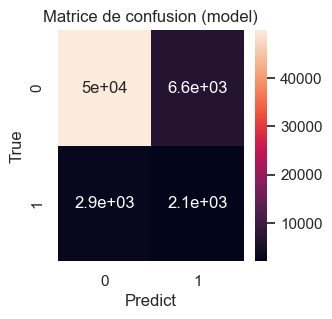

Rapport de classification :
              precision    recall  f1-score   support

         0.0       0.95      0.88      0.91     56530
         1.0       0.24      0.42      0.31      4965

    accuracy                           0.85     61495
   macro avg       0.59      0.65      0.61     61495
weighted avg       0.89      0.85      0.86     61495



2023/03/16 03:22:40 INFO mlflow.tracking.fluent: Experiment with name 'All_LOG_06_optimized_random' does not exist. Creating a new experiment.


Logging parameters
Logging metrics
Logging model
Logging CV results matrix
Logging extra data related to the experiment
mlflow-artifacts:/312621852782069815/d729c357126f408c8f5cb107277e6981/artifacts
runID: 0bef989a9afe42d4bdd389ca7bf3e12e
Logging parameters
Logging metrics
Logging model
Logging CV results matrix
Logging extra data related to the experiment
mlflow-artifacts:/312621852782069815/c247c85bef634f74aca0c5163182396f/artifacts
runID: 34e9e593c5a24397931570e13087ebe5
Logging parameters
Logging metrics
Logging model
Logging CV results matrix
Logging extra data related to the experiment
mlflow-artifacts:/312621852782069815/7f59e0cc1d7643e29e6c3bb12444b62a/artifacts
runID: 0ad54faea08d4b138ad330e3ffbcf01c
Logging parameters
Logging metrics
Logging model
Logging CV results matrix
Logging extra data related to the experiment
mlflow-artifacts:/312621852782069815/218f6d8135f14a608fe7d3b4eb129182/artifacts
runID: 4bdc0af533634d99ab8f67cfc7104fde
Logging parameters
Logging metrics
Loggi

In [30]:
# 6) Optimisation avec RandomizedSearchCV
# - under_sampling__sampling_strategy autour de 0.5 
# - kbest__k autour de 180 (au delà le score n'augmente quasi plus) 
# - classifier__C entre 0.1 et 1000

# Réglage des hyperparamètres avec RandomizedSearchCV
pipeline = imbpipeline(steps = [['scaler', StandardScaler()],
                                ['under_sampling', RandomUnderSampler(random_state=10)],
                                ['kbest', SelectKBest(f_classif)],
                                ['classifier', LogisticRegression(random_state=10)]
])

# Combinaison des hyperparamètres
hyper_params = {'under_sampling__sampling_strategy' : [0.4, 0.5, 0.6],
                'kbest__k' : range(160, 210, 10),                      
                'classifier__C' : [0.1, 1, 10, 100, 1000]            
}

# Pipeline de classification
best_model, score_f1_optimized, score_auc_optimized = fct_pipeline(pipeline, hyper_params, stratified_kfold, 'f1', 
                                                       'All_LOG_06_optimized_random', 'LOG', gridsearchcv=False
)

Fitting 3 folds for each of 15 candidates, totalling 45 fits
[CV] END ........classifier__C=0.1, classifier__solver=lbfgs; total time=   6.7s
[CV] END ........classifier__C=0.1, classifier__solver=lbfgs; total time=   4.3s
[CV] END ........classifier__C=0.1, classifier__solver=lbfgs; total time=   4.2s
[CV] END ....classifier__C=0.1, classifier__solver=liblinear; total time=   8.7s
[CV] END ....classifier__C=0.1, classifier__solver=liblinear; total time=   9.0s
[CV] END ....classifier__C=0.1, classifier__solver=liblinear; total time=   8.7s
[CV] END ..........classifier__C=0.1, classifier__solver=sag; total time=  10.6s
[CV] END ..........classifier__C=0.1, classifier__solver=sag; total time=  11.5s
[CV] END ..........classifier__C=0.1, classifier__solver=sag; total time=  11.3s
[CV] END ..........classifier__C=1, classifier__solver=lbfgs; total time=   4.2s
[CV] END ..........classifier__C=1, classifier__solver=lbfgs; total time=   4.2s
[CV] END ..........classifier__C=1, classifier__

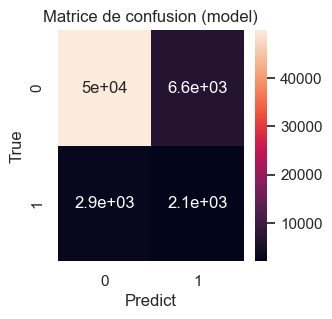

Rapport de classification :
              precision    recall  f1-score   support

         0.0       0.95      0.88      0.91     56530
         1.0       0.24      0.42      0.31      4965

    accuracy                           0.85     61495
   macro avg       0.59      0.65      0.61     61495
weighted avg       0.89      0.85      0.86     61495



In [90]:
# 7) Optimisation finale avec GridSearchCV et scoring = f1
# On affine les valeurs de paramètres en fonction des résultats précédents avec RandomizedSearchCV
pipeline = imbpipeline(steps = [['scaler', StandardScaler()],
                                ['under_sampling', RandomUnderSampler(sampling_strategy=0.5, random_state=10)],
                                ['kbest', SelectKBest(f_classif, k=200)],
                                ['classifier', LogisticRegression(random_state=10)]
])

# Combinaison des hyperparamètres
hyper_params = {'classifier__C' : [0.1, 1, 10, 100, 1000],
                'classifier__solver' : ['lbfgs', 'liblinear', 'sag']
}

# Grille des modèles avec 3 validations croisées
stratified_kfold = StratifiedKFold(n_splits=3, shuffle=True, random_state=10) 

# Pipeline de classification
log_optimized, log_score_f1_optimized, log_score_auc_optimized = fct_pipeline(pipeline, hyper_params, stratified_kfold, 
                                                                              'f1', 'All_LOG_07_optimized_f1', 'LOG', tracking=False)

Fitting 3 folds for each of 15 candidates, totalling 45 fits
[CV] END ........classifier__C=0.1, classifier__solver=lbfgs; total time=  15.3s
[CV] END ........classifier__C=0.1, classifier__solver=lbfgs; total time=  13.5s
[CV] END ........classifier__C=0.1, classifier__solver=lbfgs; total time=   7.5s
[CV] END ....classifier__C=0.1, classifier__solver=liblinear; total time=   8.6s
[CV] END ....classifier__C=0.1, classifier__solver=liblinear; total time=   8.8s
[CV] END ....classifier__C=0.1, classifier__solver=liblinear; total time=   8.7s
[CV] END ..........classifier__C=0.1, classifier__solver=sag; total time=  10.5s
[CV] END ..........classifier__C=0.1, classifier__solver=sag; total time=  10.3s
[CV] END ..........classifier__C=0.1, classifier__solver=sag; total time=  10.3s
[CV] END ..........classifier__C=1, classifier__solver=lbfgs; total time=   3.8s
[CV] END ..........classifier__C=1, classifier__solver=lbfgs; total time=   3.9s
[CV] END ..........classifier__C=1, classifier__

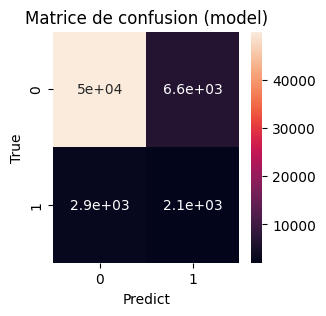

Rapport de classification :
              precision    recall  f1-score   support

         0.0       0.95      0.88      0.91     56530
         1.0       0.24      0.42      0.31      4965

    accuracy                           0.85     61495
   macro avg       0.59      0.65      0.61     61495
weighted avg       0.89      0.85      0.86     61495



2023/03/18 19:04:07 INFO mlflow.tracking.fluent: Experiment with name 'All_LOG_09_optimized_custom' does not exist. Creating a new experiment.


Logging parameters
Logging metrics
Logging model
Logging CV results matrix
Logging extra data related to the experiment
mlflow-artifacts:/684918490553052362/bf01bfc34f914375b4133e929f0037e7/artifacts
runID: 7781943e139f4d548a033eeef30a9e85
Logging parameters
Logging metrics
Logging model
Logging CV results matrix
Logging extra data related to the experiment
mlflow-artifacts:/684918490553052362/5e4015403ec24043a7a955c135551cc7/artifacts
runID: ae27bc5157d24011a80cb43bf2cf1f2e
Logging parameters
Logging metrics
Logging model
Logging CV results matrix
Logging extra data related to the experiment
mlflow-artifacts:/684918490553052362/02f03213af3f44cd92037825bac8f07a/artifacts
runID: 0f1dc710694845d4a29becd71703a69e
Logging parameters
Logging metrics
Logging model
Logging CV results matrix
Logging extra data related to the experiment
mlflow-artifacts:/684918490553052362/efc6d47a01b546e2aceb6cc4f7091580/artifacts
runID: 4ad92c2644cc4ac0af5e8f6f4f1f5419
Logging parameters
Logging metrics
Loggi

In [27]:
# 8) Optimisation finale avec GridSearchCV et scoring = custom_score
# Pipeline de classification
log_optimized_cust, log_score_f1_optimized_cust, log_score_auc_optimized_cust = fct_pipeline(pipeline, hyper_params, stratified_kfold, 
                                                                                             custom_score, 'All_LOG_08_optimized_custom', 'LOG'
)

### Threshold optimization

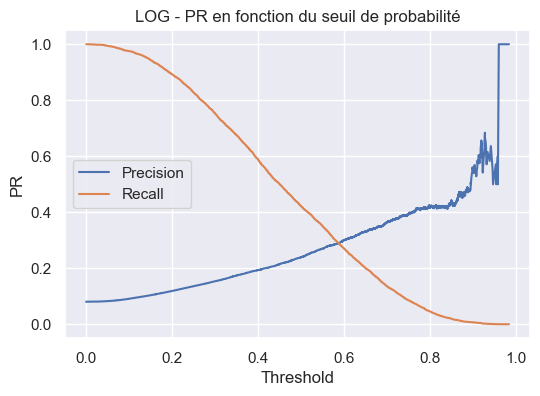

In [91]:
# Optimisation du seuil de probabilité/classification
log_model_final = log_optimized
fct_thr_optimized(log_model_final, 'LOG')

In [92]:
# Evaluation du modèle final LOGISTIC REGRESSION :
# Peu d'amélioration possible avec le seuil de classification : le f1-score passe de 0.305 à 0.307 avec thr=0.54 mais le recall baisse un peu.
log_score_f1_final, log_score_auc_final = eval_model_final(log_model_final, X_test, thr=0.54)

Rapport de classification :
              precision    recall  f1-score   support

         0.0       0.94      0.91      0.93     56530
         1.0       0.27      0.37      0.31      4965

    accuracy                           0.87     61495
   macro avg       0.60      0.64      0.62     61495
weighted avg       0.89      0.87      0.88     61495

f1_score : 0.307
AUC Roc score : 0.763


In [117]:
# Save du model final optimisé
log_param_final = ['under_sampling__sampling_strategy',
                   'kbest__k',
                   'classifier__C',
                   'classifier__solver'
]
print ('Meilleurs paramètres optimisés (Regr Logistic) :')
print ('Seuil de classification : 0.54')
print ('-'*50)
log_param_final = [f'{k}={v}' for k, v in log_model_final.get_params().items() if k in log_param_final]
print(log_param_final)

# Save du modèle de base
log_model_base = log_model_base # inchangé
log_param_base = [f'{k}={v}' for k, v in log_model_base.get_params().items() if k == 'classifier__C']

Meilleurs paramètres optimisés (Regr Logistic) :
Seuil de classification : 0.54
--------------------------------------------------
['under_sampling__sampling_strategy=0.5', 'kbest__k=200', 'classifier__C=1', 'classifier__solver=liblinear']


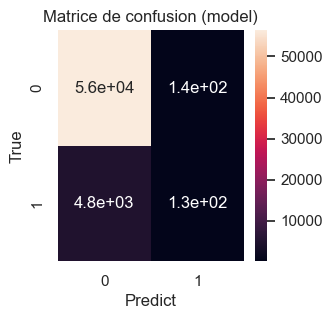

Rapport de classification :
              precision    recall  f1-score   support

         0.0       0.92      1.00      0.96     56530
         1.0       0.48      0.03      0.05      4965

    accuracy                           0.92     61495
   macro avg       0.70      0.51      0.50     61495
weighted avg       0.89      0.92      0.88     61495

f1_score : 0.049
AUC Roc score : 0.771


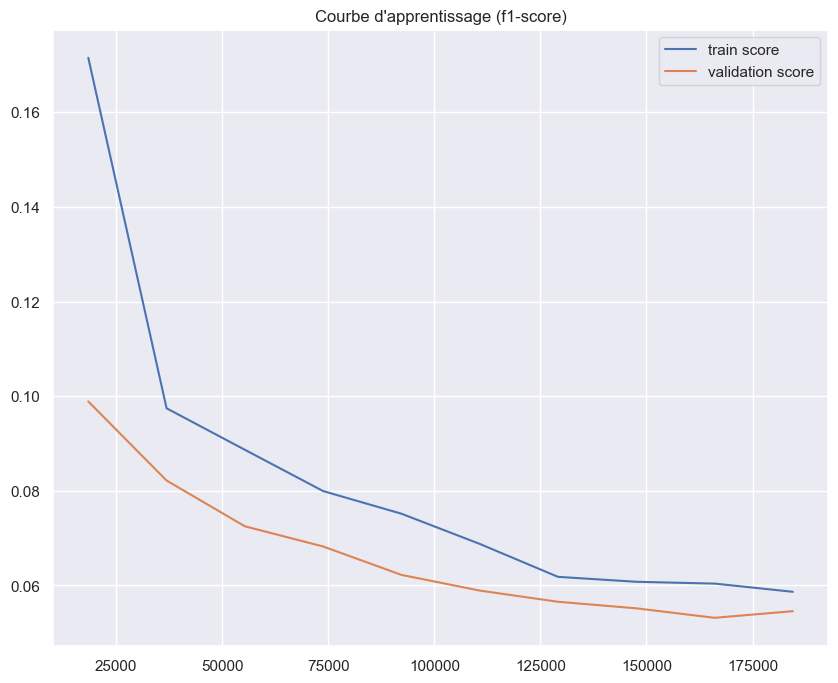

In [100]:
# Comparaison des métriques des modèles de base /Vs modèle optimisé
fct_evaluation(log_model_base, X_train, X_test)
fct_evaluation(log_model_final, X_train, X_test)

In [118]:
# Courbe ROC des modèles de base /Vs modèle optimisé
def fct_roc_curve(model_base, param_base, model_final, param_final, model_name):
    
    # Courbe ROC et aire sous la courbe pour le modèle de base (paramètres par défaut) 
    fpr, tpr, thr = roc_curve(y_test, model_base.predict_proba(X_test)[:,1])
    auc_base = auc(fpr, tpr)
    
    # Courbe ROC et aire sous la courbe pour le modèle optimisé (meilleurs hyper paramètres) 
    fpr_optimized, tpr_optimized, thr_optimized = roc_curve(y_test, model_final.predict_proba(X_test)[:,1])
    auc_optimized = auc(fpr_optimized, tpr_optimized)
    
    # Affichage des courbes ROC
    fig, ax = plt.subplots()
    #plt.figure(figsize=(7, 7))
    ax.plot(fpr, tpr, '-', color='b', lw=2, label = f"Base : {param_base}, AUC_Roc = {auc_base:.3f}")
    ax.plot(fpr_optimized, tpr_optimized, '-', color='g', lw=2, label = f"Optimisé : {param_final}, AUC_Roc = {auc_optimized:.3f}")
    plt.title(f'Courbes ROC du modèle {model_name}')
    plt.xlabel('Faux Positifs')
    plt.ylabel('Vrais Positifs')
    plt.legend(loc='best')
    ax.legend(bbox_to_anchor=(1,1))
    plt.show()

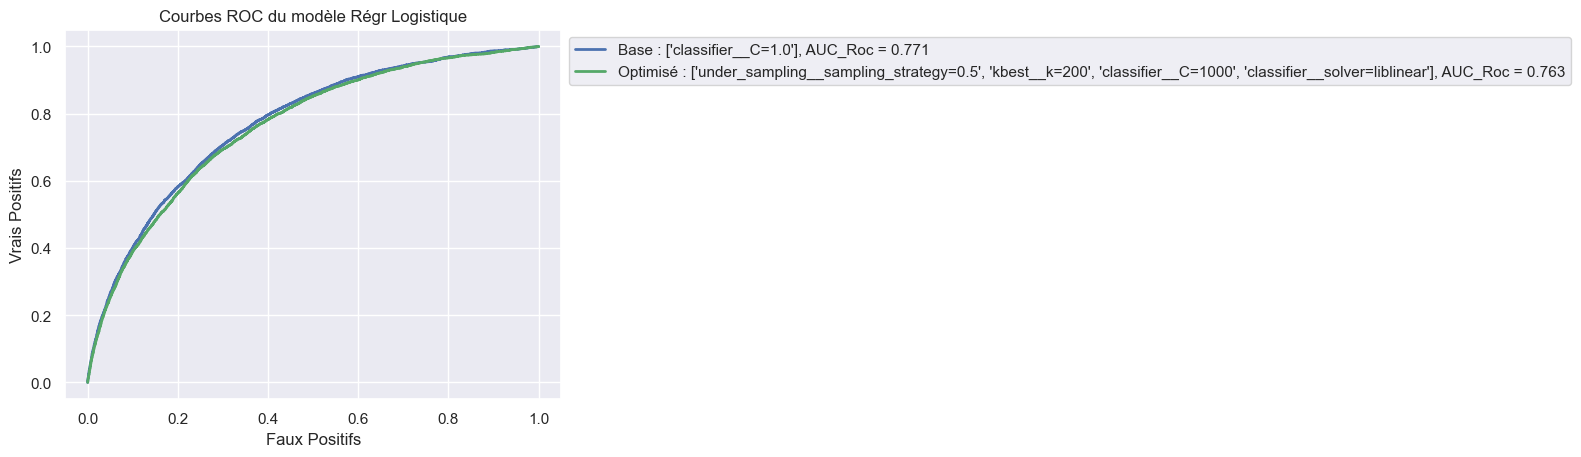

In [97]:
fct_roc_curve(log_model_base, log_param_base, log_model_final, log_param_final, 'Régr Logistique')

## Light GBM

### Base

f1_score : 0.079
custom_score : 0.098
AUC_Roc_score : 0.785


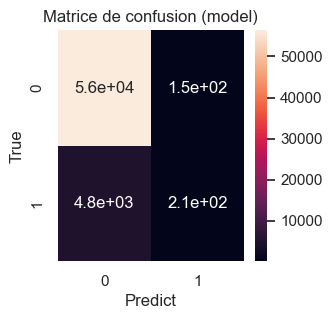

Rapport de classification :
              precision    recall  f1-score   support

         0.0       0.92      1.00      0.96     56530
         1.0       0.58      0.04      0.08      4965

    accuracy                           0.92     61495
   macro avg       0.75      0.52      0.52     61495
weighted avg       0.89      0.92      0.89     61495



In [97]:
# Evaluation de LGBM avec les paramètres de base
lgbm_model_base = LGBMClassifier(random_state=10)
lgbm_model_base.fit(X_train, y_train)
lgbm_score_f1_base, lgbm_score_auc_base = fct_eval_metrics(lgbm_model_base, X_test, y_test)

### Unbalanced

Fitting 3 folds for each of 4 candidates, totalling 12 fits
[LightGBM] [Warning] Unknown parameter: sample_pos_weight
[CV] END classifier__is_unbalance=True, classifier__sample_pos_weight=1; total time=  14.3s
[LightGBM] [Warning] Unknown parameter: sample_pos_weight
[CV] END classifier__is_unbalance=True, classifier__sample_pos_weight=1; total time=  16.4s
[LightGBM] [Warning] Unknown parameter: sample_pos_weight
[CV] END classifier__is_unbalance=True, classifier__sample_pos_weight=1; total time=  19.1s
[LightGBM] [Warning] Unknown parameter: sample_pos_weight
[CV] END classifier__is_unbalance=True, classifier__sample_pos_weight=0.08781976165734375; total time=  18.7s
[LightGBM] [Warning] Unknown parameter: sample_pos_weight
[CV] END classifier__is_unbalance=True, classifier__sample_pos_weight=0.08781976165734375; total time=  18.7s
[LightGBM] [Warning] Unknown parameter: sample_pos_weight
[CV] END classifier__is_unbalance=True, classifier__sample_pos_weight=0.08781976165734375; total

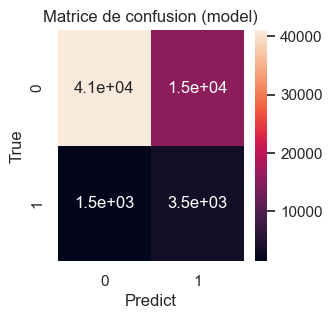

Rapport de classification :
              precision    recall  f1-score   support

         0.0       0.97      0.73      0.83     56530
         1.0       0.18      0.70      0.29      4965

    accuracy                           0.72     61495
   macro avg       0.57      0.71      0.56     61495
weighted avg       0.90      0.72      0.79     61495



2023/03/20 15:44:22 INFO mlflow.tracking.fluent: Experiment with name 'All_LGBM_01_unbalance' does not exist. Creating a new experiment.


Logging parameters
Logging metrics
Logging model
Logging CV results matrix
Logging extra data related to the experiment
mlflow-artifacts:/673707580663784531/8ea1d1deb0f348fca4dd821e730061c9/artifacts
runID: a5d26418b78e4a3b91546f0a916a3aa7
Logging parameters
Logging metrics
Logging model
Logging CV results matrix
Logging extra data related to the experiment
mlflow-artifacts:/673707580663784531/d8f802bc16974fa5ad266918d5c061c0/artifacts
runID: 36a9a210686548e79ee48167d3f65f9a
Logging parameters
Logging metrics
Logging model
Logging CV results matrix
Logging extra data related to the experiment
mlflow-artifacts:/673707580663784531/e7c7f0bcaf0440acb9cdd98decbed85e/artifacts
runID: d0b9f5f2fc554230a102c2e36bd891de
Logging parameters
Logging metrics
Logging model
Logging CV results matrix
Logging extra data related to the experiment
mlflow-artifacts:/673707580663784531/ef3327ee9791432ea12795a37c941ad7/artifacts
runID: 5c712993f7bf4b33af8fb904694e1d19


"\ngrid = GridSearchCV(estimator=pipeline, param_grid=hyper_params, scoring='f1', cv=stratified_kfold, verbose=2)\ngrid.fit(X_train, y_train)\n# Estimation\nprint('-'*50)\nprint(f'Meilleurs hyperparamètres : {grid.best_params_}')\nprint(f'CV f1-score : {grid.best_score_:.3f}')\nscore_f1_weight, score_auc_weight = fct_eval_metrics(grid.best_estimator_, X_test, y_test)\n# MLFlow Tracking \nexperiment_name = 'All_LGBM_01_unbalance'\nlog_results(grid, experiment_name, )\n"

In [64]:
# 1) Méthode des poids : hyper paramètre is_unbalance ou sample_pos_weight du classifieur
pipeline = Pipeline (steps = [['classifier', LGBMClassifier(objective='binary', random_state=10)]])
sample_pos_weight = df_train['TARGET'].value_counts().min() / df_train['TARGET'].value_counts().max()
hyper_params = {'classifier__is_unbalance' : [True, False],
                'classifier__sample_pos_weight' : [1, sample_pos_weight]
} 
stratified_kfold = StratifiedKFold(n_splits=3, shuffle=True, random_state=10)
best_model, score_f1_weight, score_auc_weight = fct_pipeline(pipeline, hyper_params, stratified_kfold, 
                                                             'f1', experiment_name='All_LGBM_01_unbalance', classifier_name='LGBM'
)

### Over sampling

Fitting 3 folds for each of 27 candidates, totalling 81 fits
[CV] END over_sampling__k_neighbors=3, over_sampling__sampling_strategy=0.1; total time=  28.7s
[CV] END over_sampling__k_neighbors=3, over_sampling__sampling_strategy=0.1; total time=  30.5s
[CV] END over_sampling__k_neighbors=3, over_sampling__sampling_strategy=0.1; total time=  29.4s
[CV] END over_sampling__k_neighbors=3, over_sampling__sampling_strategy=0.2; total time=  33.7s
[CV] END over_sampling__k_neighbors=3, over_sampling__sampling_strategy=0.2; total time=  33.6s
[CV] END over_sampling__k_neighbors=3, over_sampling__sampling_strategy=0.2; total time=  33.3s
[CV] END over_sampling__k_neighbors=3, over_sampling__sampling_strategy=0.30000000000000004; total time=  36.9s
[CV] END over_sampling__k_neighbors=3, over_sampling__sampling_strategy=0.30000000000000004; total time=  37.4s
[CV] END over_sampling__k_neighbors=3, over_sampling__sampling_strategy=0.30000000000000004; total time=  38.1s
[CV] END over_sampling__k_n

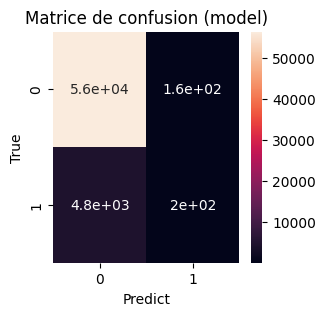

Rapport de classification :
              precision    recall  f1-score   support

         0.0       0.92      1.00      0.96     56530
         1.0       0.56      0.04      0.08      4965

    accuracy                           0.92     61495
   macro avg       0.74      0.52      0.52     61495
weighted avg       0.89      0.92      0.89     61495



2023/03/19 18:47:31 INFO mlflow.tracking.fluent: Experiment with name 'All_LGBM_02_over_sampling' does not exist. Creating a new experiment.


Logging parameters
Logging metrics
Logging model
Logging CV results matrix
Logging extra data related to the experiment
mlflow-artifacts:/730871618149504963/22beaf51a39c463aa23a3b883b3cf9e5/artifacts
runID: 33e2df56a4bb46c6b4fbff458f6473b0
Logging parameters
Logging metrics
Logging model
Logging CV results matrix
Logging extra data related to the experiment
mlflow-artifacts:/730871618149504963/df08adb436b048f9b86533da01f9088b/artifacts
runID: c3214b0b1e4845009f7035811124b026
Logging parameters
Logging metrics
Logging model
Logging CV results matrix
Logging extra data related to the experiment
mlflow-artifacts:/730871618149504963/9d31482ff0ba4933abecf2d9fcb2ba3e/artifacts
runID: 4c71b6ffb8e4463ba9582122fa53aded
Logging parameters
Logging metrics
Logging model
Logging CV results matrix
Logging extra data related to the experiment
mlflow-artifacts:/730871618149504963/c4aa8541a2624e449438479eeb4cd905/artifacts
runID: 21bca84b2f564e39bf7d90978be09c74
Logging parameters
Logging metrics
Loggi

In [29]:
# 2) Méthode SMOTE avec optimisation des hyper-paramètres SMOTE
pipeline = imbpipeline(steps = [['scaler', StandardScaler()],
                                ['over_sampling', SMOTE(random_state=10)],
                                ['classifier', LGBMClassifier(random_state=10)]
])
hyper_params = {'over_sampling__k_neighbors' : [3, 5, 7],
                'over_sampling__sampling_strategy' : np.linspace(0.1, 0.9, 9)
}
stratified_kfold = StratifiedKFold(n_splits=3, shuffle=True, random_state=10)
best_model, score_f1_over, score_auc_over = fct_pipeline(pipeline, hyper_params, stratified_kfold, 
                                                         'f1', experiment_name='All_LGBM_02_over_sampling', classifier_name='LGBM'
)

### Under sampling
- méthode optimale

Fitting 3 folds for each of 9 candidates, totalling 27 fits
[CV] END ..............under_sampling__sampling_strategy=0.1; total time=  20.8s
[CV] END ..............under_sampling__sampling_strategy=0.1; total time=  23.5s
[CV] END ..............under_sampling__sampling_strategy=0.1; total time=  21.9s
[CV] END ..............under_sampling__sampling_strategy=0.2; total time=  23.6s
[CV] END ..............under_sampling__sampling_strategy=0.2; total time=  25.3s
[CV] END ..............under_sampling__sampling_strategy=0.2; total time=  24.7s
[CV] END under_sampling__sampling_strategy=0.30000000000000004; total time=  17.0s
[CV] END under_sampling__sampling_strategy=0.30000000000000004; total time=  14.9s
[CV] END under_sampling__sampling_strategy=0.30000000000000004; total time=  12.7s
[CV] END ..............under_sampling__sampling_strategy=0.4; total time=  11.5s
[CV] END ..............under_sampling__sampling_strategy=0.4; total time=  10.8s
[CV] END ..............under_sampling__samp

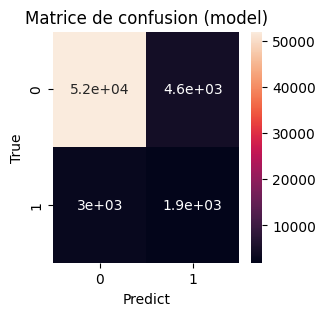

Rapport de classification :
              precision    recall  f1-score   support

         0.0       0.94      0.92      0.93     56530
         1.0       0.29      0.39      0.33      4965

    accuracy                           0.88     61495
   macro avg       0.62      0.65      0.63     61495
weighted avg       0.89      0.88      0.88     61495



2023/03/19 19:39:04 INFO mlflow.tracking.fluent: Experiment with name 'All_LGBM_03_under_sampling' does not exist. Creating a new experiment.


Logging parameters
Logging metrics
Logging model
Logging CV results matrix
Logging extra data related to the experiment
mlflow-artifacts:/269366411420772934/a4cc29e2b4e34f18b6b78867d2d68a90/artifacts
runID: 6367620c3a784c2984751e451297ab67
Logging parameters
Logging metrics
Logging model
Logging CV results matrix
Logging extra data related to the experiment
mlflow-artifacts:/269366411420772934/a7e461d1fa5a4b02bf91a5c22c89980f/artifacts
runID: 691fafd0dd3a44e19f2207727c107d02
Logging parameters
Logging metrics
Logging model
Logging CV results matrix
Logging extra data related to the experiment
mlflow-artifacts:/269366411420772934/5a27cf06719e45789233b9bccdb97d12/artifacts
runID: 4301692f12e84934a86a944a2abb215f
Logging parameters
Logging metrics
Logging model
Logging CV results matrix
Logging extra data related to the experiment
mlflow-artifacts:/269366411420772934/7ffc26daa776482cac27240b356e2766/artifacts
runID: 9cd58d9aab404a54a2cf943aaec2300f
Logging parameters
Logging metrics
Loggi

In [30]:
# 3) Méthode RandomUnderSampler avec optimisation du taux de Under sampling pour le sous échantillonnage de la classe majoritaire 
pipeline = imbpipeline(steps = [['scaler', StandardScaler()],
                                ['under_sampling', RandomUnderSampler(random_state=10)],
                                ['classifier', LGBMClassifier(random_state=10)]
])
hyper_params = {'under_sampling__sampling_strategy' : np.linspace(0.1, 0.9, 9)}
stratified_kfold = StratifiedKFold(n_splits=3, shuffle=True, random_state=10)
best_model, score_f1_under, score_auc_under = fct_pipeline(pipeline, hyper_params, stratified_kfold, 
                                                           'f1', experiment_name='All_LGBM_03_under_sampling', classifier_name='LGBM'
)

### Over/under sampling

Fitting 3 folds for each of 9 candidates, totalling 27 fits
[CV] END over_sampling__k_neighbors=7, over_sampling__sampling_strategy=0.1, under_sampling__sampling_strategy=0.3; total time=  17.6s
[CV] END over_sampling__k_neighbors=7, over_sampling__sampling_strategy=0.1, under_sampling__sampling_strategy=0.3; total time=  19.5s
[CV] END over_sampling__k_neighbors=7, over_sampling__sampling_strategy=0.1, under_sampling__sampling_strategy=0.3; total time=  15.6s
[CV] END over_sampling__k_neighbors=7, over_sampling__sampling_strategy=0.1, under_sampling__sampling_strategy=0.4; total time=  14.2s
[CV] END over_sampling__k_neighbors=7, over_sampling__sampling_strategy=0.1, under_sampling__sampling_strategy=0.4; total time=  16.1s
[CV] END over_sampling__k_neighbors=7, over_sampling__sampling_strategy=0.1, under_sampling__sampling_strategy=0.4; total time=  16.9s
[CV] END over_sampling__k_neighbors=7, over_sampling__sampling_strategy=0.1, under_sampling__sampling_strategy=0.5; total time=  1

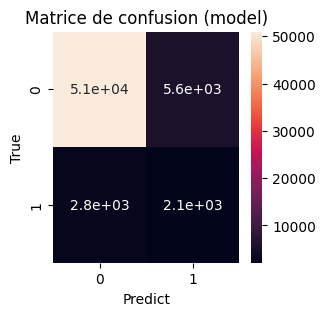

Rapport de classification :
              precision    recall  f1-score   support

         0.0       0.95      0.90      0.92     56530
         1.0       0.28      0.43      0.34      4965

    accuracy                           0.86     61495
   macro avg       0.61      0.67      0.63     61495
weighted avg       0.89      0.86      0.88     61495



2023/03/19 19:59:59 INFO mlflow.tracking.fluent: Experiment with name 'All_LGBM_04_overunder_sampling' does not exist. Creating a new experiment.


Logging parameters
Logging metrics
Logging model
Logging CV results matrix
Logging extra data related to the experiment
mlflow-artifacts:/898743930692735527/c4bdc7d80c6c4ad9904c32084297c7f6/artifacts
runID: 5ce8a4f030834a75a107a7e08a8313a8
Logging parameters
Logging metrics
Logging model
Logging CV results matrix
Logging extra data related to the experiment
mlflow-artifacts:/898743930692735527/2faffd8d545d4bd69d7ea37fdf90e165/artifacts
runID: f10a464146a440c4a501416884157fef
Logging parameters
Logging metrics
Logging model
Logging CV results matrix
Logging extra data related to the experiment
mlflow-artifacts:/898743930692735527/0e66e866fb0c4e09b14f3020e6afcd5b/artifacts
runID: 7cf00ad7044e47ec85855aa5c1d2a56c
Logging parameters
Logging metrics
Logging model
Logging CV results matrix
Logging extra data related to the experiment
mlflow-artifacts:/898743930692735527/5726774883b34636941f49268d79ac9d/artifacts
runID: 9665ab3632d74cf98025791689317ac2
Logging parameters
Logging metrics
Loggi

In [31]:
# 4) Méthode combinée SMOTE + RandomUnderSampler avec optimisation des taux Over/Under sampling 
pipeline = imbpipeline(steps = [['scaler', StandardScaler()],
                                ['over_sampling', SMOTE(random_state=10)],
                                ['under_sampling', RandomUnderSampler(random_state=10)],
                                ['classifier', LGBMClassifier(random_state=10)]
])
stratified_kfold = StratifiedKFold(n_splits=3, shuffle=True, random_state=10)
hyper_params = {'over_sampling__k_neighbors' : [7],
                'over_sampling__sampling_strategy' : [0.1, 0.3, 0.5],
                'under_sampling__sampling_strategy' : [0.3, 0.4, 0.5]
}
best_model, score_f1_overunder, score_auc_overunder = fct_pipeline(pipeline, hyper_params, stratified_kfold, 
                                                                   'f1', experiment_name='All_LGBM_04_overunder_sampling', classifier_name='LGBM'
)

                     f1-score  auc-score
over_under_sampling     0.336      0.785
under_sampling          0.334      0.785
class_weight            0.292      0.787
over_sampling           0.076      0.787


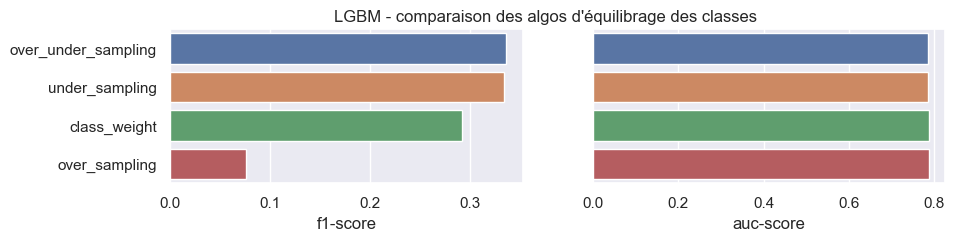

In [66]:
# Comparaison de l'évaluation des méthodes d'équilibrage des classes sur le TEST set
fct_compare_result('LGBM')

### Hyper parameters optimization
- balancing : under sampling strategy = 0.4

Fitting 3 folds for each of 40 candidates, totalling 120 fits
[CV] END classifier__learning_rate=0.1, classifier__max_depth=25, classifier__n_estimators=300, classifier__num_leaves=140, classifier__subsample=0.6, kbest__k=20; total time=   8.0s
[CV] END classifier__learning_rate=0.1, classifier__max_depth=25, classifier__n_estimators=300, classifier__num_leaves=140, classifier__subsample=0.6, kbest__k=20; total time=   7.5s
[CV] END classifier__learning_rate=0.1, classifier__max_depth=25, classifier__n_estimators=300, classifier__num_leaves=140, classifier__subsample=0.6, kbest__k=20; total time=   7.3s
[CV] END classifier__learning_rate=0.0001, classifier__max_depth=10, classifier__n_estimators=500, classifier__num_leaves=140, classifier__subsample=1.0, kbest__k=20; total time=  10.3s
[CV] END classifier__learning_rate=0.0001, classifier__max_depth=10, classifier__n_estimators=500, classifier__num_leaves=140, classifier__subsample=1.0, kbest__k=20; total time=  10.3s
[CV] END classifi

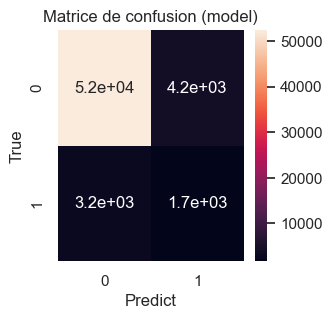

Rapport de classification :
              precision    recall  f1-score   support

         0.0       0.94      0.93      0.93     56530
         1.0       0.29      0.35      0.32      4965

    accuracy                           0.88     61495
   macro avg       0.62      0.64      0.63     61495
weighted avg       0.89      0.88      0.88     61495



2023/03/20 09:17:14 INFO mlflow.tracking.fluent: Experiment with name 'All_LGBM_05_optimized_random' does not exist. Creating a new experiment.


Logging parameters
Logging metrics
Logging model
Logging CV results matrix
Logging extra data related to the experiment
mlflow-artifacts:/978701042094956751/88bff982a5904edda44dffef289c0da0/artifacts
runID: 00c7cc8b30734d95bf6f6c773a5511af
Logging parameters
Logging metrics
Logging model
Logging CV results matrix
Logging extra data related to the experiment
mlflow-artifacts:/978701042094956751/2b0945c699f14517a70eb59fde512316/artifacts
runID: 8b0480e8fb8d4337b8735801ce45d0b2
Logging parameters
Logging metrics
Logging model
Logging CV results matrix
Logging extra data related to the experiment
mlflow-artifacts:/978701042094956751/521d3a665eed4580be16f685e2f0ebf6/artifacts
runID: 207ff6e0d9364c0b88cc990f7c845ffe
Logging parameters
Logging metrics
Logging model
Logging CV results matrix
Logging extra data related to the experiment
mlflow-artifacts:/978701042094956751/5243bb568b7242d0803aa38199a019f4/artifacts
runID: 072fc37c52f94828b5ea77bde25bea0b
Logging parameters
Logging metrics
Loggi

In [39]:
# Réglage des hyperparamètres avec RandomizedSearchCV :
# - Kbest
# - learning_rate,
# - n_estimators : entre 100 et 500 
# - max_depth : entre 5 et 50
# - subsample : entre 0.1 et 1
pipeline = imbpipeline(steps = [['scaler', StandardScaler()],
                                ['kbest', SelectKBest(f_classif)],
                                ['under_sampling', RandomUnderSampler(random_state=10, sampling_strategy=0.4)],
                                ['classifier', LGBMClassifier(random_state=10)] 
                                
])
hyper_params = {'kbest__k' : range(20, 320, 20), 
                'classifier__n_estimators' : [int(x) for x in np.linspace(100, 500, num=5)],
                'classifier__learning_rate' : [0.0001, 0.001, 0.01, 0.1, 0.2, 0.3],
                'classifier__max_depth' : [int(x) for x in np.linspace(5, 50, num=10)], 
                'classifier__num_leaves' : [int(x) for x in np.linspace(20, 200, num=10)],
                'classifier__subsample' : [0.1, 0.3, 0.6, 1.0]
}
best_model, score_f1_optimized, score_auc_optimized = fct_pipeline(pipeline, hyper_params, stratified_kfold, 
                                                                   'f1', experiment_name='All_LGBM_05_optimized_random', classifier_name='LGBM',
                                                                   gridsearchcv=False
)

Fitting 3 folds for each of 27 candidates, totalling 81 fits
[CV] END classifier__learning_rate=0.01, classifier__max_depth=15, classifier__n_estimators=500, classifier__num_leaves=50, classifier__subsample=0.1; total time=  20.8s
[CV] END classifier__learning_rate=0.01, classifier__max_depth=15, classifier__n_estimators=500, classifier__num_leaves=50, classifier__subsample=0.1; total time=  21.7s
[CV] END classifier__learning_rate=0.01, classifier__max_depth=15, classifier__n_estimators=500, classifier__num_leaves=50, classifier__subsample=0.1; total time=  22.3s
[CV] END classifier__learning_rate=0.01, classifier__max_depth=15, classifier__n_estimators=500, classifier__num_leaves=50, classifier__subsample=0.5; total time=  26.4s
[CV] END classifier__learning_rate=0.01, classifier__max_depth=15, classifier__n_estimators=500, classifier__num_leaves=50, classifier__subsample=0.5; total time=  28.5s
[CV] END classifier__learning_rate=0.01, classifier__max_depth=15, classifier__n_estimato

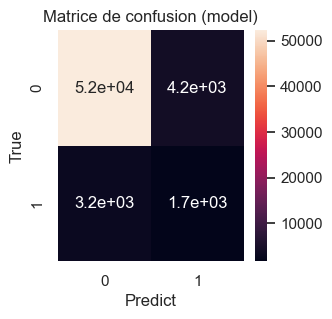

Rapport de classification :
              precision    recall  f1-score   support

         0.0       0.94      0.92      0.93     56530
         1.0       0.29      0.35      0.32      4965

    accuracy                           0.88     61495
   macro avg       0.62      0.64      0.62     61495
weighted avg       0.89      0.88      0.88     61495



In [93]:
# Optimisation finale avec GridSearchCV et scoring = f1-score:
# - KBest=260
# - UNDER sampling_strategy=0.4
# - On affine les valeurs d'hyperparamètre du classifier en fonction de la recherche Random précédente
pipeline = imbpipeline(steps = [['scaler', StandardScaler()],
                                ['kbest', SelectKBest(f_classif, k=260)],
                                ['under_sampling', RandomUnderSampler(random_state=10, sampling_strategy=0.4)],
                                ['classifier', LGBMClassifier(random_state=10)]                              
])
hyper_params = {'classifier__n_estimators' : [500],
                'classifier__learning_rate' : [0.01],
                'classifier__max_depth' : [15, 20, 25],
                'classifier__num_leaves' : [50, 60, 70],
                'classifier__subsample' : [0.1, 0.5, 0.8]
}           
stratified_kfold = StratifiedKFold(n_splits=3, shuffle=True, random_state=10)
lgbm_optimized, lgbm_score_f1_optimized, lgbm_score_auc_optimized = fct_pipeline(pipeline, hyper_params, stratified_kfold, 
                                                                                 'f1', experiment_name='All_LGBM_06_optimized_f1', 
                                                                                 classifier_name='LGBM',
                                                                                 gridsearchcv=True,
                                                                                 tracking=False
)

In [248]:
# Optimisation finale avec GridSearchCV et scoring = custom_score
pipeline = imbpipeline(steps = [['scaler', StandardScaler()],
                                ['kbest', SelectKBest(f_classif, k=260)],
                                ['under_sampling', RandomUnderSampler(random_state=10, sampling_strategy=0.4)],
                                ['classifier', LGBMClassifier(random_state=10)]                              
])
hyper_params = {'classifier__n_estimators' : [500],
                'classifier__learning_rate' : [0.01],
                'classifier__max_depth' : [15, 20, 25],
                'classifier__num_leaves' : [50, 60, 70],
                'classifier__subsample' : [0.1, 0.5, 0.8]
}           
stratified_kfold = StratifiedKFold(n_splits=3, shuffle=True, random_state=10)
lgbm_optimized_custom, lgbm_score_f1_custom, lgbm_score_auc_custom = fct_pipeline(pipeline, hyper_params, stratified_kfold, 
                                                                                  custom_score, experiment_name='All_LGBM_07_optimized_custom', 
                                                                                  classifier_name='LGBM',
                                                                                  gridsearchcv=True,
                                                                                  tracking=False
)

Fitting 3 folds for each of 27 candidates, totalling 81 fits
[CV] END classifier__learning_rate=0.01, classifier__max_depth=15, classifier__n_estimators=500, classifier__num_leaves=50, classifier__subsample=0.1; total time=  25.1s
[CV] END classifier__learning_rate=0.01, classifier__max_depth=15, classifier__n_estimators=500, classifier__num_leaves=50, classifier__subsample=0.1; total time=  23.5s
[CV] END classifier__learning_rate=0.01, classifier__max_depth=15, classifier__n_estimators=500, classifier__num_leaves=50, classifier__subsample=0.1; total time=  21.8s


KeyboardInterrupt: 

### Threshold optimization

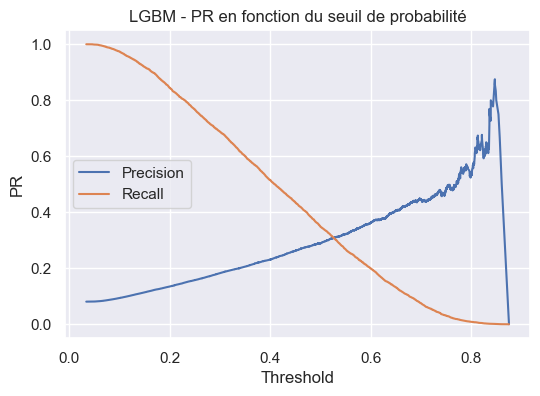

In [94]:
# Optimisation du seuil de probabilité/classification
lgbm_model_final = lgbm_optimized
fct_thr_optimized(lgbm_model_final, 'LGBM')

In [95]:
# Recherche du seuil de classification optimal
lgbm_score_f1_final, lgbm_score_auc_final = eval_model_final(lgbm_model_final, X_test, thr=0.45)

Rapport de classification :
              precision    recall  f1-score   support

         0.0       0.95      0.89      0.92     56530
         1.0       0.26      0.44      0.33      4965

    accuracy                           0.86     61495
   macro avg       0.60      0.66      0.62     61495
weighted avg       0.89      0.86      0.87     61495

f1_score : 0.327
AUC Roc score : 0.776


In [262]:
lgbm_model_final.get_params()

{'memory': None,
 'steps': [('scaler', StandardScaler()),
  ('kbest', SelectKBest(k=260)),
  ('under_sampling',
   RandomUnderSampler(random_state=10, sampling_strategy=0.4)),
  ['classifier',
   LGBMClassifier(learning_rate=0.01, max_depth=20, n_estimators=500,
                  num_leaves=70, random_state=10, subsample=0.1)]],
 'verbose': False,
 'scaler': StandardScaler(),
 'kbest': SelectKBest(k=260),
 'under_sampling': RandomUnderSampler(random_state=10, sampling_strategy=0.4),
 'classifier': LGBMClassifier(learning_rate=0.01, max_depth=20, n_estimators=500,
                num_leaves=70, random_state=10, subsample=0.1),
 'scaler__copy': True,
 'scaler__with_mean': True,
 'scaler__with_std': True,
 'kbest__k': 260,
 'kbest__score_func': <function sklearn.feature_selection._univariate_selection.f_classif(X, y)>,
 'under_sampling__random_state': 10,
 'under_sampling__replacement': False,
 'under_sampling__sampling_strategy': 0.4,
 'classifier__boosting_type': 'gbdt',
 'classifier__c

In [110]:
# Save du model LGBM final optimisé
lgbm_param_final = ['estimator__under_sampling__sampling_strategy',
                   'estimator__kbest__k',
                   'estimator__classifier__n_estimators',
                   'estimator__classifier__learning_rate'
                   'estimator__classifier__max_depth',
                   'estimator__classifier__num_leaves',
                   'estimator__classifier__subsample' 
]
print ('Meilleurs paramètres optimisés (LGBM) :')
print ('Seuil de classification : 0.45')
print ('-'*50)
lgbm_param_final = [f'{k}={v}' for k, v in lgbm_model_final.get_params().items() if k in lgbm_param_final]
print(lgbm_param_final)

# Save du modèle de base
lgbm_model_base = lgbm_model_base # inchangé
lgbm_param_base = [f'{k}={v}' for k, v in lgbm_model_base.get_params().items() 
                   if k in lgbm_param_final 
                   and k not in ['under_sampling__sampling_strategy', 'kbest__k']
]

Meilleurs paramètres optimisés (LGBM) :
Seuil de classification : 0.45
--------------------------------------------------
['estimator__kbest__k=260', 'estimator__under_sampling__sampling_strategy=0.4', 'estimator__classifier__n_estimators=100', 'estimator__classifier__num_leaves=31', 'estimator__classifier__subsample=1.0']


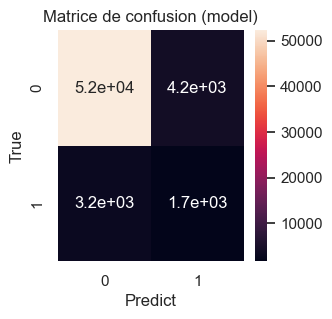

Rapport de classification :
              precision    recall  f1-score   support

         0.0       0.94      0.92      0.93     56530
         1.0       0.29      0.35      0.32      4965

    accuracy                           0.88     61495
   macro avg       0.62      0.64      0.62     61495
weighted avg       0.89      0.88      0.88     61495

f1_score : 0.316
AUC Roc score : 0.776


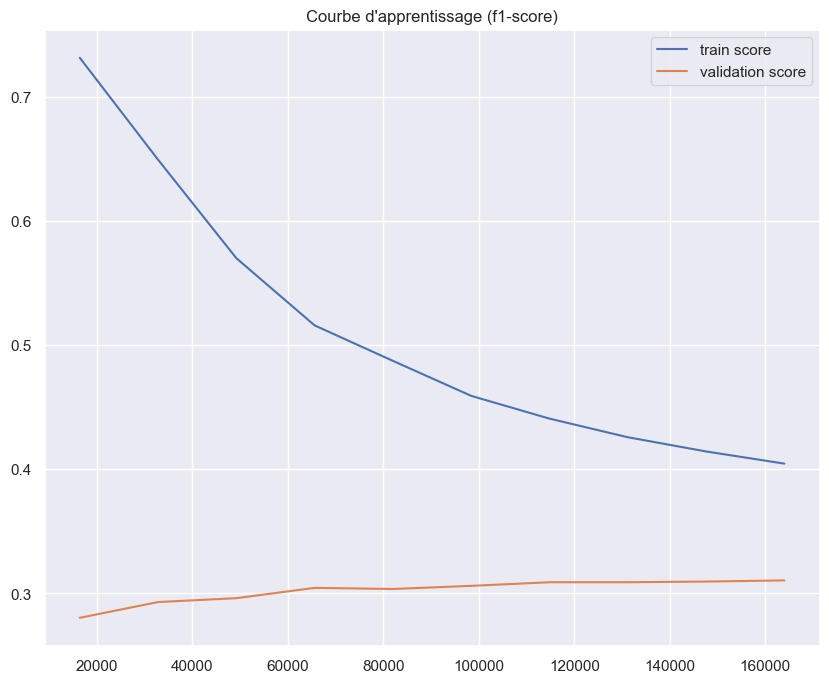

In [98]:
# Comparaison des métriques des modèles de base /Vs modèle optimisé
#fct_evaluation(lgbm_model_base, X_train, X_test)
fct_evaluation(lgbm_model_final, X_train, X_test)

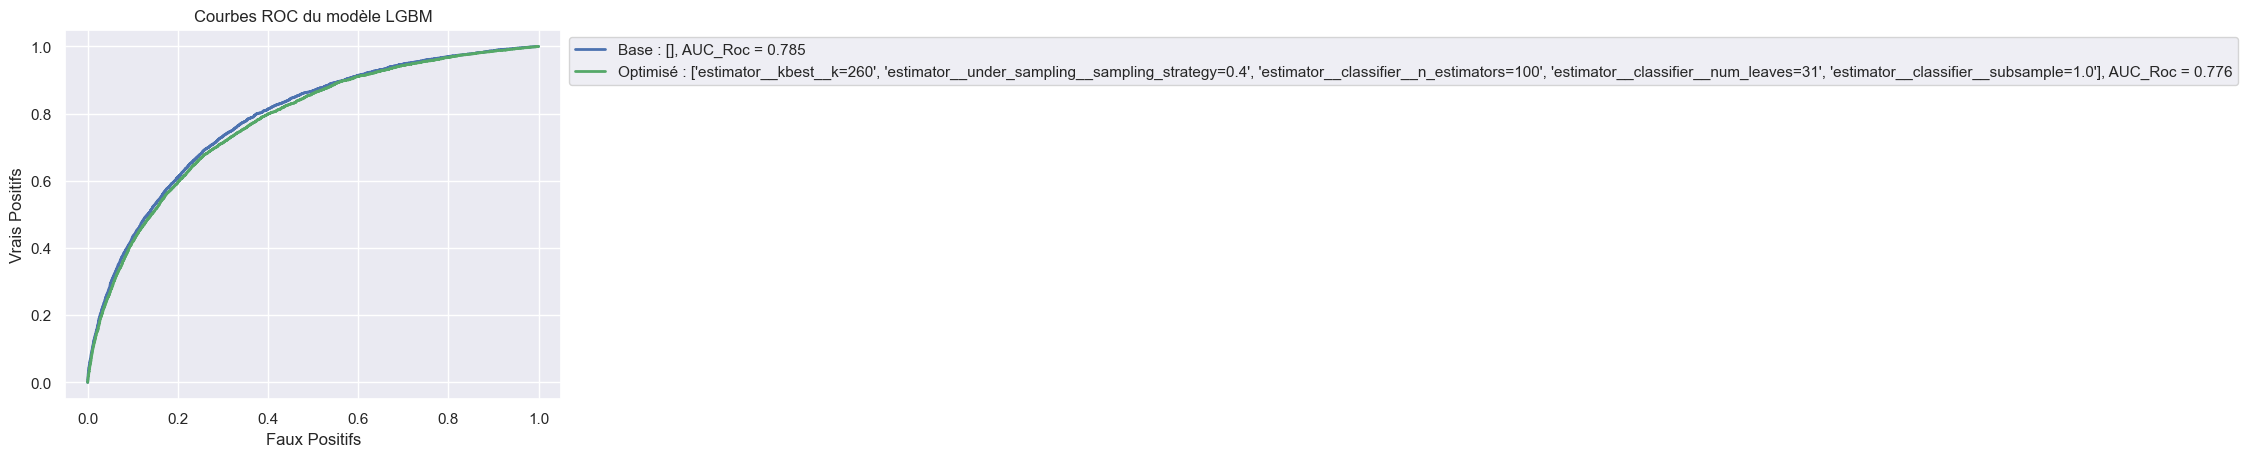

In [125]:
# Courbe ROC des modèles LGBM de base et optimisé
fct_roc_curve(lgbm_model_base, lgbm_param_base, lgbm_model_final, lgbm_param_final, 'LGBM')

## Random Forest

### Base

f1_score : 0.003
custom_score : 0.1
AUC_Roc_score : 0.714


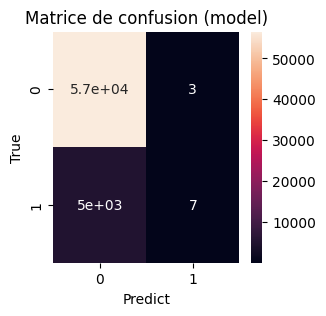

Rapport de classification :
              precision    recall  f1-score   support

         0.0       0.92      1.00      0.96     56530
         1.0       0.70      0.00      0.00      4965

    accuracy                           0.92     61495
   macro avg       0.81      0.50      0.48     61495
weighted avg       0.90      0.92      0.88     61495



In [23]:
# Evaluation de Random Forest avec les paramètres de base
rfc_model_base = RandomForestClassifier(random_state=10)
rfc_model_base.fit(X_train, y_train)
rfc_score_f1_base, rfc_score_auc_base = fct_eval_metrics(rfc_model_base, X_test, y_test)

### Balancing optimization

Fitting 3 folds for each of 10 candidates, totalling 30 fits
[CV] END ........classifier__class_weight={0: 0.08, 1: 0.92}; total time= 4.1min
[CV] END ........classifier__class_weight={0: 0.08, 1: 0.92}; total time= 3.6min
[CV] END ........classifier__class_weight={0: 0.08, 1: 0.92}; total time= 3.7min
[CV] END classifier__class_weight={0: 0.0811111111111111, 1: 0.9188888888888889}; total time= 3.7min
[CV] END classifier__class_weight={0: 0.0811111111111111, 1: 0.9188888888888889}; total time= 3.8min
[CV] END classifier__class_weight={0: 0.0811111111111111, 1: 0.9188888888888889}; total time= 3.6min
[CV] END classifier__class_weight={0: 0.08222222222222222, 1: 0.9177777777777778}; total time= 3.7min
[CV] END classifier__class_weight={0: 0.08222222222222222, 1: 0.9177777777777778}; total time= 3.7min
[CV] END classifier__class_weight={0: 0.08222222222222222, 1: 0.9177777777777778}; total time= 3.8min
[CV] END classifier__class_weight={0: 0.08333333333333333, 1: 0.9166666666666666}; tota

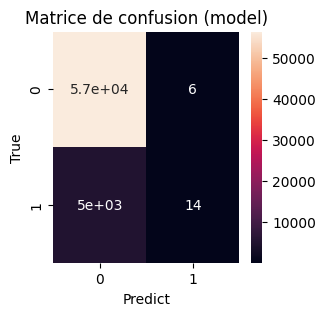

Rapport de classification :
              precision    recall  f1-score   support

         0.0       0.92      1.00      0.96     56530
         1.0       0.70      0.00      0.01      4965

    accuracy                           0.92     61495
   macro avg       0.81      0.50      0.48     61495
weighted avg       0.90      0.92      0.88     61495



2023/04/02 19:51:39 INFO mlflow.tracking.fluent: Experiment with name 'All_RFC_01_class_weight' does not exist. Creating a new experiment.


Logging parameters
Logging metrics
Logging model
Logging CV results matrix
Logging extra data related to the experiment
mlflow-artifacts:/393178796833778268/ab6bfede907d4466b61432fee09ef74a/artifacts
runID: 5945ff316e5543f992ed98e2ef58c1ad
Logging parameters
Logging metrics
Logging model
Logging CV results matrix
Logging extra data related to the experiment
mlflow-artifacts:/393178796833778268/9b33e28352ab4b45b422a09c47c5e35a/artifacts
runID: c4868e4f55814fcabfaaeb6c0d6568ae
Logging parameters
Logging metrics
Logging model
Logging CV results matrix
Logging extra data related to the experiment
mlflow-artifacts:/393178796833778268/1c3a78a9ea2747ed88a86367be01d5fb/artifacts
runID: 8658043f368540a2b027dde7c5fd0b3b
Logging parameters
Logging metrics
Logging model
Logging CV results matrix
Logging extra data related to the experiment
mlflow-artifacts:/393178796833778268/d2e557598ce643559af1cfbe53eed558/artifacts
runID: 6742b0584cdc48ddb1bfeaa492bba688
Logging parameters
Logging metrics
Loggi

In [30]:
# 1) Méthode des poids : hyper paramètre class_weight du classifieur
pipeline = Pipeline (steps = [['classifier', RandomForestClassifier(random_state=10)]])

# Combinaisons des hyperparamètres
weights = np.linspace(0.080, 0.090, 10) # poids = inversement proportionnel à la distribution / classe
hyper_params = {'classifier__class_weight' : [{0 : x, 1 : 1.0-x} for x in weights]}

# Grille des modèles avec 3 validations croisées
stratified_kfold = StratifiedKFold(n_splits=3, shuffle=True, random_state=10)

# Pipeline de classification
best_model, score_f1_weight, score_auc_weight = fct_pipeline(pipeline, 
                                                             hyper_params, 
                                                             stratified_kfold, 
                                                             'f1', 
                                                             experiment_name='All_RFC_01_class_weight', 
                                                             classifier_name='RFC')

Fitting 3 folds for each of 5 candidates, totalling 15 fits
[CV] END ...............over_sampling__sampling_strategy=0.1; total time= 6.3min
[CV] END ...............over_sampling__sampling_strategy=0.1; total time= 4.9min
[CV] END ...............over_sampling__sampling_strategy=0.1; total time= 4.9min
[CV] END over_sampling__sampling_strategy=0.30000000000000004; total time= 5.2min
[CV] END over_sampling__sampling_strategy=0.30000000000000004; total time= 5.1min
[CV] END over_sampling__sampling_strategy=0.30000000000000004; total time= 5.2min
[CV] END ...............over_sampling__sampling_strategy=0.5; total time= 6.2min
[CV] END ...............over_sampling__sampling_strategy=0.5; total time= 6.3min
[CV] END ...............over_sampling__sampling_strategy=0.5; total time= 6.1min
[CV] END over_sampling__sampling_strategy=0.7000000000000001; total time= 7.4min
[CV] END over_sampling__sampling_strategy=0.7000000000000001; total time= 7.4min
[CV] END over_sampling__sampling_strategy=0.70

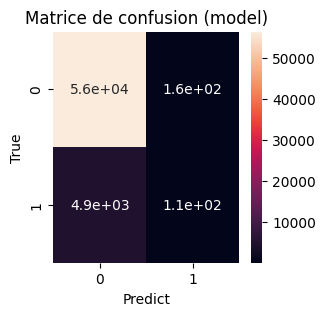

Rapport de classification :
              precision    recall  f1-score   support

         0.0       0.92      1.00      0.96     56530
         1.0       0.42      0.02      0.04      4965

    accuracy                           0.92     61495
   macro avg       0.67      0.51      0.50     61495
weighted avg       0.88      0.92      0.88     61495



2023/04/02 22:17:15 INFO mlflow.tracking.fluent: Experiment with name 'All_RFC_02_over_sampling' does not exist. Creating a new experiment.


Logging parameters
Logging metrics
Logging model
Logging CV results matrix
Logging extra data related to the experiment
mlflow-artifacts:/136464846323050503/d2393e15c74c43e5a931b8d3afb69ba9/artifacts
runID: c6d46a6433fe4a9fa96c65836c783f2a
Logging parameters
Logging metrics
Logging model
Logging CV results matrix
Logging extra data related to the experiment
mlflow-artifacts:/136464846323050503/52f63dc137c7498cb53cab6bd6f6c8b1/artifacts
runID: d1f056f3493b4f2eb8af016dfb0cd868
Logging parameters
Logging metrics
Logging model
Logging CV results matrix
Logging extra data related to the experiment
mlflow-artifacts:/136464846323050503/483d0cc157bc412482d392a4a9f0cc13/artifacts
runID: d5c907823b404182a52d5cc63ead2fc5
Logging parameters
Logging metrics
Logging model
Logging CV results matrix
Logging extra data related to the experiment
mlflow-artifacts:/136464846323050503/206c9e579c4c4f94ace2b46cb5eae3b4/artifacts
runID: 7ca51873f9ea43429e05412b4e29e996
Logging parameters
Logging metrics
Loggi

In [33]:
# 2) Méthode SMOTE avec optimisation des hyper-paramètres SMOTE
pipeline = imbpipeline(steps = [['scaler', StandardScaler()],
                                ['over_sampling', SMOTE(random_state=10)],
                                ['classifier', RandomForestClassifier(random_state=10)]
])
hyper_params = {#'over_sampling__k_neighbors' : [3, 5, 7],
                'over_sampling__sampling_strategy' : np.linspace(0.1, 0.9, 5)
}
stratified_kfold = StratifiedKFold(n_splits=3, shuffle=True, random_state=10)
best_model, score_f1_over, score_auc_over = fct_pipeline(pipeline, 
                                                         hyper_params, 
                                                         stratified_kfold, 
                                                         'f1', 
                                                         experiment_name='All_RFC_02_over_sampling', 
                                                         classifier_name='RFC'
)

Fitting 3 folds for each of 3 candidates, totalling 9 fits
[CV] END ..............under_sampling__sampling_strategy=0.4; total time= 1.4min
[CV] END ..............under_sampling__sampling_strategy=0.4; total time= 1.4min
[CV] END ..............under_sampling__sampling_strategy=0.4; total time=  59.2s
[CV] END ..............under_sampling__sampling_strategy=0.5; total time=  51.1s
[CV] END ..............under_sampling__sampling_strategy=0.5; total time=  49.1s
[CV] END ..............under_sampling__sampling_strategy=0.5; total time=  49.2s
[CV] END ..............under_sampling__sampling_strategy=0.6; total time=  46.4s
[CV] END ..............under_sampling__sampling_strategy=0.6; total time= 1.1min
[CV] END ..............under_sampling__sampling_strategy=0.6; total time=  43.4s
--------------------------------------------------
Meilleurs hyperparamètres : {'under_sampling__sampling_strategy': 0.6}
CV f1-score : 0.286
f1_score : 0.292
custom_score : 0.16
AUC_Roc_score : 0.743


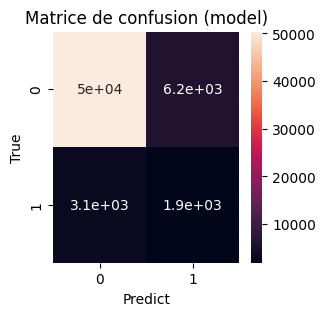

Rapport de classification :
              precision    recall  f1-score   support

         0.0       0.94      0.89      0.92     56530
         1.0       0.24      0.38      0.29      4965

    accuracy                           0.85     61495
   macro avg       0.59      0.64      0.60     61495
weighted avg       0.89      0.85      0.87     61495



2023/04/02 23:18:05 INFO mlflow.tracking.fluent: Experiment with name 'All_RFC_03_under_sampling' does not exist. Creating a new experiment.


Logging parameters
Logging metrics
Logging model
Logging CV results matrix
Logging extra data related to the experiment
mlflow-artifacts:/437351261688902685/c4c2abc97f4b42f3afd0faa66ec0b620/artifacts
runID: dfb46e7dfe6848028a5744d9d8920148
Logging parameters
Logging metrics
Logging model
Logging CV results matrix
Logging extra data related to the experiment
mlflow-artifacts:/437351261688902685/f8038e2ecec8458ea92de9b1b65af32b/artifacts
runID: 533206b8815d4c7d82449581dbee768c
Logging parameters
Logging metrics
Logging model
Logging CV results matrix
Logging extra data related to the experiment
mlflow-artifacts:/437351261688902685/18b6b55373f4400d938de4aa7c149cdd/artifacts
runID: f1efb9c5ab19473686dea88695b3efbf


In [34]:
# 3) Méthode RandomUnderSampler avec optimisation du taux de Under sampling pour le sous échantillonnage de la classe majoritaire 
pipeline = imbpipeline(steps = [['scaler', StandardScaler()],
                                ['under_sampling', RandomUnderSampler(random_state=10)],
                                ['classifier', RandomForestClassifier(random_state=10)]
])

# Grille des modèles avec 3 validations croisées 
stratified_kfold = StratifiedKFold(n_splits=3, shuffle=True, random_state=10)
hyper_params = {'under_sampling__sampling_strategy' : [0.4, 0.5, 0.6]}

# Pipeline de classification
best_model, score_f1_under, score_auc_under = fct_pipeline(pipeline, 
                                                           hyper_params, 
                                                           stratified_kfold, 
                                                           'f1', 
                                                           experiment_name='All_RFC_03_under_sampling', 
                                                           classifier_name='RFC')

Fitting 3 folds for each of 9 candidates, totalling 27 fits
[CV] END over_sampling__sampling_strategy=0.1, under_sampling__sampling_strategy=0.1; total time= 4.9min
[CV] END over_sampling__sampling_strategy=0.1, under_sampling__sampling_strategy=0.1; total time= 4.9min
[CV] END over_sampling__sampling_strategy=0.1, under_sampling__sampling_strategy=0.1; total time= 4.9min
[CV] END over_sampling__sampling_strategy=0.1, under_sampling__sampling_strategy=0.5; total time= 1.0min
[CV] END over_sampling__sampling_strategy=0.1, under_sampling__sampling_strategy=0.5; total time= 1.0min
[CV] END over_sampling__sampling_strategy=0.1, under_sampling__sampling_strategy=0.5; total time= 1.0min
[CV] END over_sampling__sampling_strategy=0.1, under_sampling__sampling_strategy=0.9; total time=  43.8s
[CV] END over_sampling__sampling_strategy=0.1, under_sampling__sampling_strategy=0.9; total time=  43.9s
[CV] END over_sampling__sampling_strategy=0.1, under_sampling__sampling_strategy=0.9; total time=  4

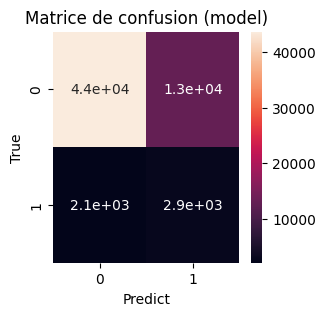

Rapport de classification :
              precision    recall  f1-score   support

         0.0       0.95      0.77      0.85     56530
         1.0       0.18      0.58      0.28      4965

    accuracy                           0.76     61495
   macro avg       0.57      0.68      0.57     61495
weighted avg       0.89      0.76      0.81     61495



2023/04/03 00:43:02 INFO mlflow.tracking.fluent: Experiment with name 'All_RFC_04_overunder_sampling' does not exist. Creating a new experiment.


Logging parameters
Logging metrics
Logging model
Logging CV results matrix
Logging extra data related to the experiment
mlflow-artifacts:/787501140183798904/2a1d26a14d4347d5861404cfef686b2e/artifacts
runID: 206df0eb3c224076b6aebc146c571e65
Logging parameters
Logging metrics
Logging model
Logging CV results matrix
Logging extra data related to the experiment
mlflow-artifacts:/787501140183798904/090a576ac1504cbd822d4b118b5ef1e2/artifacts
runID: 92c3c9410d054aba9754f23d11d82fda
Logging parameters
Logging metrics
Logging model
Logging CV results matrix
Logging extra data related to the experiment
mlflow-artifacts:/787501140183798904/a7e3a92f451d4223bef04611ab662e75/artifacts
runID: 0ab1a51fad70432a90938d3f53384fff
Logging parameters
Logging metrics
Logging model
Logging CV results matrix
Logging extra data related to the experiment
mlflow-artifacts:/787501140183798904/cad66cbce009471ea7e2f0df310b2ef3/artifacts
runID: 7864424293eb44b0ae646efac0d54772
Logging parameters
Logging metrics
Loggi

In [35]:
# 4) Méthode combinée SMOTE + RandomUnderSampler avec optimisation des taux Over/Under sampling 
pipeline = imbpipeline(steps = [['scaler', StandardScaler()],
                                ['over_sampling', SMOTE(random_state=10)],
                                ['under_sampling', RandomUnderSampler(random_state=10)],
                                ['classifier', RandomForestClassifier(random_state=10)]
])
stratified_kfold = StratifiedKFold(n_splits=3, shuffle=True, random_state=10)
hyper_params = {#'over_sampling__k_neighbors' : [7],
                'over_sampling__sampling_strategy' : [0.1, 0.5, 0.9],
                'under_sampling__sampling_strategy' : [0.1, 0.5, 0.9]
}
best_model, score_f1_overunder, score_auc_overunder = fct_pipeline(pipeline, 
                                                                   hyper_params, 
                                                                   stratified_kfold, 
                                                                   'f1', 
                                                                   experiment_name='All_RFC_04_overunder_sampling', 
                                                                   classifier_name='RFC'
)

                     f1-score  auc-score
under_sampling          0.292      0.743
over_under_sampling     0.278      0.744
over_sampling           0.043      0.727
class_weight            0.006      0.728


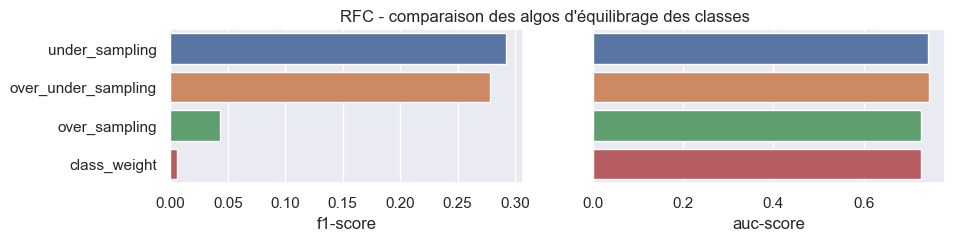

In [39]:
# Comparaison de l'évaluation des méthodes d'équilibrage des classes sur le TEST set
fct_compare_result('RFC')

### KBest
- under sampling strategy = 0.6

Fitting 3 folds for each of 10 candidates, totalling 30 fits
[CV] END ........................................kbest__k=20; total time=  14.7s
[CV] END ........................................kbest__k=20; total time=  16.0s
[CV] END ........................................kbest__k=20; total time=  16.0s
[CV] END ........................................kbest__k=50; total time=  20.1s
[CV] END ........................................kbest__k=50; total time=  19.3s
[CV] END ........................................kbest__k=50; total time=  18.4s
[CV] END ........................................kbest__k=80; total time=  21.2s
[CV] END ........................................kbest__k=80; total time=  22.4s
[CV] END ........................................kbest__k=80; total time=  21.7s
[CV] END .......................................kbest__k=110; total time=  25.1s
[CV] END .......................................kbest__k=110; total time=  26.6s
[CV] END .......................................

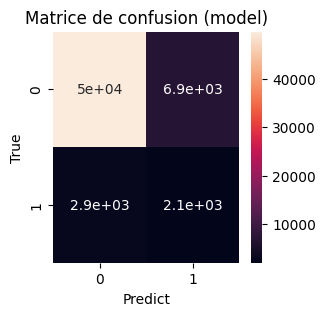

Rapport de classification :
              precision    recall  f1-score   support

         0.0       0.94      0.88      0.91     56530
         1.0       0.23      0.41      0.30      4965

    accuracy                           0.84     61495
   macro avg       0.59      0.65      0.60     61495
weighted avg       0.89      0.84      0.86     61495



2023/04/03 02:33:36 INFO mlflow.tracking.fluent: Experiment with name 'All_RFC_05_under_sampling_kbest' does not exist. Creating a new experiment.


Logging parameters
Logging metrics
Logging model
Logging CV results matrix
Logging extra data related to the experiment
mlflow-artifacts:/396406781771286013/6d36465da91d4914bc533b84ab6e8ce3/artifacts
runID: 85b844e6f9884a499033c2735c4ed9b0
Logging parameters
Logging metrics
Logging model
Logging CV results matrix
Logging extra data related to the experiment
mlflow-artifacts:/396406781771286013/fcb05117dcb04a5483370a3a0cd88963/artifacts
runID: 946f0edc2a8f41d082ceadcb3e634c47
Logging parameters
Logging metrics
Logging model
Logging CV results matrix
Logging extra data related to the experiment
mlflow-artifacts:/396406781771286013/26b9bbef9a724694b29e10a5897fa2cd/artifacts
runID: f0918222477546f18ecb184844bb1748
Logging parameters
Logging metrics
Logging model
Logging CV results matrix
Logging extra data related to the experiment
mlflow-artifacts:/396406781771286013/d1dc27e61aee4b7699ab33a83c027744/artifacts
runID: 799d1a16872f49f2b2b1a62afa370c4f
Logging parameters
Logging metrics
Loggi

In [36]:
# 5) SelectKbest
pipeline = imbpipeline(steps = [['scaler', StandardScaler()],
                                ['under_sampling', RandomUnderSampler(sampling_strategy=0.6, random_state=10)],
                                ['kbest', SelectKBest(f_classif)],
                                ['classifier', RandomForestClassifier(random_state=10)]
])

# Combinaisons des hyperparamètres (K entre 20 et 300 par pas de 30)
hyper_params = {'kbest__k' : range(20, 320, 30)}

# Grille des modèles avec 3 validations croisées
stratified_kfold = StratifiedKFold(n_splits=3, shuffle=True, random_state=10) 

# Pipeline de classification
best_model, score_f1_kbest, score_auc_kbest = fct_pipeline(pipeline, 
                                                           hyper_params, 
                                                           stratified_kfold, 
                                                           'f1', 
                                                           experiment_name='All_RFC_05_under_sampling_kbest', 
                                                           classifier_name='RFC')

### Hyper-parameters optimization
- Under sampling = 0.6
- KBest = 200 (F1=0.287)
- KBest = 50 (F1=0.28) --> On pourra choisir K=50 car le score F1 ne progresse quasi plus au delà

--------------------------------------------------
Meilleurs hyperparamètres : {'classifier__n_estimators': 500, 'classifier__min_samples_leaf': 10, 'classifier__max_depth': 20}
CV f1-score : 0.291
f1_score : 0.299
custom_score : 0.176
AUC_Roc_score : 0.749


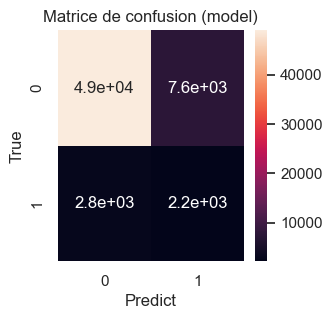

Rapport de classification :
              precision    recall  f1-score   support

         0.0       0.95      0.87      0.90     56530
         1.0       0.23      0.44      0.30      4965

    accuracy                           0.83     61495
   macro avg       0.59      0.65      0.60     61495
weighted avg       0.89      0.83      0.86     61495



2023/04/03 04:01:52 INFO mlflow.tracking.fluent: Experiment with name 'All_RFC_06_optimized_random' does not exist. Creating a new experiment.


Logging parameters
Logging metrics
Logging model
Logging CV results matrix
Logging extra data related to the experiment
mlflow-artifacts:/840266016581700207/6faaff6a6b38413cae22d8cf86f01d31/artifacts
runID: 6eebbedce6674f9083678322febf4015
Logging parameters
Logging metrics
Logging model
Logging CV results matrix
Logging extra data related to the experiment
mlflow-artifacts:/840266016581700207/8235061e511545359974db59f428b28c/artifacts
runID: 0de8d3355d3445c888dff17cd2b6e6f9
Logging parameters
Logging metrics
Logging model
Logging CV results matrix
Logging extra data related to the experiment
mlflow-artifacts:/840266016581700207/4231416337d3482db67733eb85cc84e4/artifacts
runID: 83295eaa4ce9447cb77ef5aa352bd3d3
Logging parameters
Logging metrics
Logging model
Logging CV results matrix
Logging extra data related to the experiment
mlflow-artifacts:/840266016581700207/16b338a382f446a7bb3614959a59ae22/artifacts
runID: fb38c7cda0074a18b4b4811c81b8bd0c
Logging parameters
Logging metrics
Loggi

In [40]:
# Réglage des hyperparamètres avec RandomizedSearchCV :
# - n_estimators : entre 200 et 500 
# - max_depth : entre 5 et 50
# - min_samples_leaf entre 1 et 10
pipeline = imbpipeline(steps = [['scaler', StandardScaler()],
                                ['under_sampling', RandomUnderSampler(sampling_strategy=0.6, random_state=10)],
                                ['kbest', SelectKBest(f_classif, k=50)],                              
                                ['classifier', RandomForestClassifier(random_state=10)]
])

# Combinaison des hyperparamètres
hyper_params = {'classifier__n_estimators' : range(200, 600, 100),
                'classifier__max_depth': [int(x) for x in np.linspace(5, 50, num=10)],       
                'classifier__min_samples_leaf' : [1, 2, 4, 8, 10]
}

best_model, score_f1_optimized, score_auc_optimized = fct_pipeline(pipeline, 
                                                                   hyper_params, 
                                                                   stratified_kfold, 
                                                                   'f1', 
                                                                   experiment_name='All_RFC_06_optimized_random', 
                                                                   classifier_name='RFC',
                                                                   gridsearchcv=False
                                                                   
)

Fitting 3 folds for each of 9 candidates, totalling 27 fits
[CV] END classifier__max_depth=18, classifier__min_samples_leaf=10, classifier__n_estimators=500; total time= 1.7min
[CV] END classifier__max_depth=18, classifier__min_samples_leaf=10, classifier__n_estimators=500; total time= 1.8min
[CV] END classifier__max_depth=18, classifier__min_samples_leaf=10, classifier__n_estimators=500; total time= 1.3min
[CV] END classifier__max_depth=18, classifier__min_samples_leaf=15, classifier__n_estimators=500; total time= 1.0min
[CV] END classifier__max_depth=18, classifier__min_samples_leaf=15, classifier__n_estimators=500; total time=  58.4s
[CV] END classifier__max_depth=18, classifier__min_samples_leaf=15, classifier__n_estimators=500; total time=  55.9s
[CV] END classifier__max_depth=18, classifier__min_samples_leaf=50, classifier__n_estimators=500; total time=  50.4s
[CV] END classifier__max_depth=18, classifier__min_samples_leaf=50, classifier__n_estimators=500; total time=  47.0s
[CV]

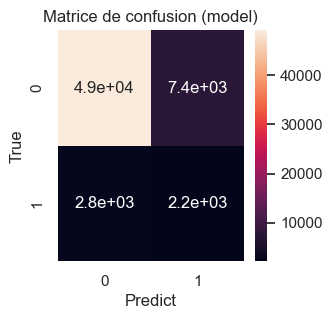

Rapport de classification :
              precision    recall  f1-score   support

         0.0       0.95      0.87      0.91     56530
         1.0       0.23      0.44      0.30      4965

    accuracy                           0.83     61495
   macro avg       0.59      0.65      0.60     61495
weighted avg       0.89      0.83      0.86     61495



2023/04/03 11:00:12 INFO mlflow.tracking.fluent: Experiment with name 'All_RFC_07_optimized_f1' does not exist. Creating a new experiment.


Logging parameters
Logging metrics
Logging model
Logging CV results matrix
Logging extra data related to the experiment
mlflow-artifacts:/751722968342438233/7c76a67ee2154fcb9fbf0135731f0e14/artifacts
runID: 2a95b30137ab4d34a942606e647c5020
Logging parameters
Logging metrics
Logging model
Logging CV results matrix
Logging extra data related to the experiment
mlflow-artifacts:/751722968342438233/1c6cf6b91c504ad498f1899b306cf05f/artifacts
runID: 7ceb75a9134d4dbeb43a7b4bb96ba265
Logging parameters
Logging metrics
Logging model
Logging CV results matrix
Logging extra data related to the experiment
mlflow-artifacts:/751722968342438233/7b7e5f5facc54b6ba5cd48798e8c8359/artifacts
runID: d1938d0f6e8345639bbb38f37e6670ca
Logging parameters
Logging metrics
Logging model
Logging CV results matrix
Logging extra data related to the experiment
mlflow-artifacts:/751722968342438233/29bf1826c73a4c65b136a3dfbb8e1472/artifacts
runID: 2f3a8db59e4b41d094260ef0dbb00754
Logging parameters
Logging metrics
Loggi

In [41]:
# Optimisation finale avec GridSearchCV et scoring = f1
# KBest=50
# Under sampling_strategy=0.6 
# On affine les valeurs d'hyperparamètre en fonction de la recherche Random précédente
pipeline = imbpipeline(steps = [['scaler', StandardScaler()],
                                ['under_sampling', RandomUnderSampler(sampling_strategy=0.6, random_state=10)],
                                ['kbest', SelectKBest(f_classif, k=50)],
                                ['classifier', RandomForestClassifier(random_state=10)]
])

# Combinaison des hyperparamètres
hyper_params = {'classifier__n_estimators' : [500],                 
                'classifier__max_depth' : [18, 20, 22],           
                'classifier__min_samples_leaf' : [10, 15, 50]
}

rfc_optimized, rfc_score_f1_optimized, rfc_score_auc_optimized = fct_pipeline(pipeline, 
                                                                              hyper_params, 
                                                                              stratified_kfold, 
                                                                              'f1', 
                                                                              experiment_name='All_RFC_07_optimized_f1', 
                                                                              classifier_name='RFC',
                                                                              gridsearchcv=True
                                                                   
)

Fitting 3 folds for each of 9 candidates, totalling 27 fits
[CV] END classifier__max_depth=18, classifier__min_samples_leaf=10, classifier__n_estimators=500; total time= 1.5min
[CV] END classifier__max_depth=18, classifier__min_samples_leaf=10, classifier__n_estimators=500; total time= 1.7min
[CV] END classifier__max_depth=18, classifier__min_samples_leaf=10, classifier__n_estimators=500; total time= 1.5min
[CV] END classifier__max_depth=18, classifier__min_samples_leaf=15, classifier__n_estimators=500; total time= 1.5min
[CV] END classifier__max_depth=18, classifier__min_samples_leaf=15, classifier__n_estimators=500; total time=  59.1s
[CV] END classifier__max_depth=18, classifier__min_samples_leaf=15, classifier__n_estimators=500; total time=  56.4s
[CV] END classifier__max_depth=18, classifier__min_samples_leaf=30, classifier__n_estimators=500; total time=  54.9s
[CV] END classifier__max_depth=18, classifier__min_samples_leaf=30, classifier__n_estimators=500; total time=  51.9s
[CV]

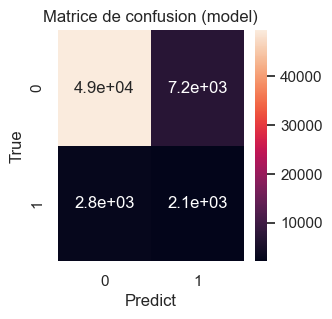

Rapport de classification :
              precision    recall  f1-score   support

         0.0       0.95      0.87      0.91     56530
         1.0       0.23      0.43      0.30      4965

    accuracy                           0.84     61495
   macro avg       0.59      0.65      0.60     61495
weighted avg       0.89      0.84      0.86     61495



2023/04/03 13:35:23 INFO mlflow.tracking.fluent: Experiment with name 'All_RFC_07_optimized_custom' does not exist. Creating a new experiment.


Logging parameters
Logging metrics
Logging model
Logging CV results matrix
Logging extra data related to the experiment
mlflow-artifacts:/789900563161203395/1c0e4dcb3c1140da813306f265265d2e/artifacts
runID: 35b01354571f48acb06aa24bf4a44c85
Logging parameters
Logging metrics
Logging model
Logging CV results matrix
Logging extra data related to the experiment
mlflow-artifacts:/789900563161203395/c1a38a111f884c3692d1bd11428e1f69/artifacts
runID: bf2a2447a3bd4c7da8cdc6ca3f5a8af0
Logging parameters
Logging metrics
Logging model
Logging CV results matrix
Logging extra data related to the experiment
mlflow-artifacts:/789900563161203395/310314f39d2d4c61a3f84184a3c40b4a/artifacts
runID: 0ebe096be4024e71a3a6264fc83ce7ad
Logging parameters
Logging metrics
Logging model
Logging CV results matrix
Logging extra data related to the experiment
mlflow-artifacts:/789900563161203395/3be2ef51b0c248ce9e7446a80def2866/artifacts
runID: 20d5b8bd4b0342a6911e09891235e58e
Logging parameters
Logging metrics
Loggi

In [42]:
# Optimisation finale avec GridSearchCV et scoring = custom_score
# Combinaison des hyperparamètres
hyper_params = {'classifier__n_estimators' : [500],                 
                'classifier__max_depth' : [18, 20, 22],           
                'classifier__min_samples_leaf' : [10, 15, 30]
}
rfc_optimized_custom, rfc_score_f1_custom, rfc_score_auc_custom = fct_pipeline(pipeline, 
                                                                               hyper_params, 
                                                                               stratified_kfold, 
                                                                               custom_score, 
                                                                               experiment_name='All_RFC_07_optimized_custom', 
                                                                               classifier_name='RFC',
                                                                               gridsearchcv=True
)

### Threshold optimization

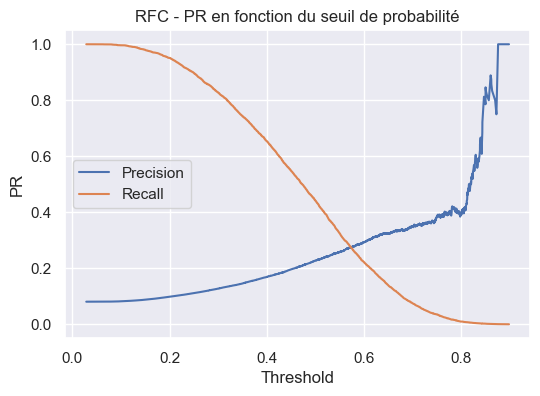

In [45]:
# Optimisation du seuil de probabilité/classification
rfc_model_final = rfc_optimized
fct_thr_optimized(rfc_model_final, 'RFC')

In [55]:
# Recherche du seuil de classification optimal : 0.50 = pas de changement de seuil
rfc_score_f1_final, rfc_score_auc_final = eval_model_final(rfc_model_final, X_test, thr=0.50)

Rapport de classification :
              precision    recall  f1-score   support

         0.0       0.95      0.87      0.91     56530
         1.0       0.23      0.44      0.30      4965

    accuracy                           0.83     61495
   macro avg       0.59      0.65      0.60     61495
weighted avg       0.89      0.83      0.86     61495

f1_score : 0.3
AUC Roc score : 0.748


In [56]:
rfc_model_final.get_params()

{'memory': None,
 'steps': [('scaler', StandardScaler()),
  ('under_sampling',
   RandomUnderSampler(random_state=10, sampling_strategy=0.6)),
  ('kbest', SelectKBest(k=50)),
  ['classifier',
   RandomForestClassifier(max_depth=18, min_samples_leaf=15, n_estimators=500,
                          random_state=10)]],
 'verbose': False,
 'scaler': StandardScaler(),
 'under_sampling': RandomUnderSampler(random_state=10, sampling_strategy=0.6),
 'kbest': SelectKBest(k=50),
 'classifier': RandomForestClassifier(max_depth=18, min_samples_leaf=15, n_estimators=500,
                        random_state=10),
 'scaler__copy': True,
 'scaler__with_mean': True,
 'scaler__with_std': True,
 'under_sampling__random_state': 10,
 'under_sampling__replacement': False,
 'under_sampling__sampling_strategy': 0.6,
 'kbest__k': 50,
 'kbest__score_func': <function sklearn.feature_selection._univariate_selection.f_classif(X, y)>,
 'classifier__bootstrap': True,
 'classifier__ccp_alpha': 0.0,
 'classifier__class

In [63]:
# Save du model RANDOM FOREST CLASSIFIER (RFC) final optimisé
rfc_param_final = ['under_sampling__sampling_strategy',
                   'kbest__k',
                   'classifier__n_estimators',
                   'classifier__max_depth',
                   'classifier__min_samples_leaf'
]
print ('Meilleurs paramètres optimisés (RFC) :')
print ('Seuil de classification : 0.50')
print ('-'*50)
rfc_param_final = [f'{k}={v}' for k, v in rfc_model_final.get_params().items() if k in rfc_param_final]
print('rfc optimisé : ', rfc_param_final)

# Save du modèle de base
rfc_model_base = rfc_model_base # inchangé
rfc_param_base = [f'{k}={v}' for k, v in rfc_model_base.get_params().items() 
                  if k in ['n_estimators', 'max_depth', 'min_samples_leaf']
]
print('rfc de base : ', rfc_param_base)

Meilleurs paramètres optimisés (RFC) :
Seuil de classification : 0.??
--------------------------------------------------
rfc optimisé :  ['under_sampling__sampling_strategy=0.6', 'kbest__k=50', 'classifier__max_depth=18', 'classifier__min_samples_leaf=15', 'classifier__n_estimators=500']
rfc de base :  ['max_depth=None', 'min_samples_leaf=1', 'n_estimators=100']


## Results

In [5]:
lgbm_model_final = pickle.load(open('lgbm_model_final.p', 'rb'))
log_model_final = pickle.load(open('log_model_final.p', 'rb'))

      f1-score  auc-score
LGBM     0.327      0.776
LOG      0.307      0.763
RFC      0.300      0.748


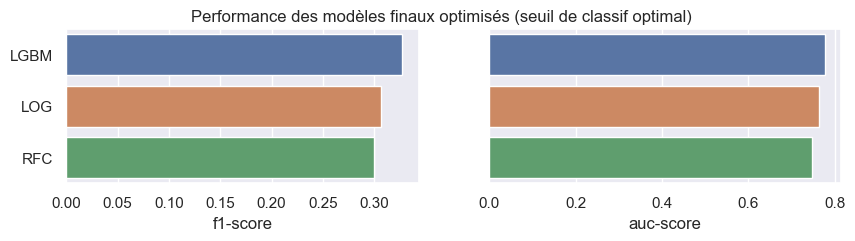

In [96]:
# Performance des modèles
fct_compare_result_final()

## Save for the dashboard
- 1. save du sous échantillon du TEST set pour analyse des données dans le dashboard
- 2. save des variables modele au format pikle pour prédiction  de l'octroi de crédit via l'API (back-end) du dashboard
- 3. save des variables SHAP (shape_values) au format pikle pour affichage des 50 features importances locales
- 4. save des images png (Log+lgbm) pour affichage des 50 features importances globales

In [ ]:
# 1. Save de l'échantillon du TEST set pour l'application dashboard
df_appli_test = pd.DataFrame(X_test, columns=df_test.drop('TARGET', axis=1).columns)
df_appli_test['TARGET'] = y_test

# Ajout du score de probabilité d'appartenance à 1 classe (octroi/refus crédit)
df_appli_test['log_score_pred'] = log_model_final.predict_proba(X_test)[:,1].tolist()
df_appli_test['lgbm_score_pred'] = lgbm_model_final.predict_proba(X_test)[:,1].tolist()

# Sous échantillon de 100 observations du TEST set : 50 octrois/50 refus
df_appli_0_test = df_appli_test[df_appli_test['TARGET']==0][:50] 
df_appli_1_test = df_appli_test[df_appli_test['TARGET']==1][:50]
df_appli_test = pd.concat([df_appli_0_test, df_appli_1_test], axis=0, ignore_index=True)
print(f"Dimensions du sous échantillon de TEST : {df_appli_test.shape}")

# Save du dataframe pour l'application dashboard
df_appli_test.to_csv('df_appli_test.csv')

Dimensions de l'échantillon de TEST : (100, 805)


In [ ]:
# 2. Save des modèles au format pikle 
# Compactage des modeles (serialisation de la représentation hiérarchique d'objets en flux binaire) 
with open('log_model_final.p', 'wb') as file:
    pickle.dump(log_model_final, file)

with open('lgbm_model_final.p', 'wb') as file:
    pickle.dump(lgbm_model_final, file)

with open('rfc_model_final.p', 'wb') as file:
    pickle.dump(rfc_model_final, file)

In [ ]:
# OLD
""" 
# Features importance depuis le modèle de régression logistique (kbest=200) 
log_model_final = pickle.load(open('log_model_final.p', 'rb'))
print(f"Dimensions coef_ : {log_model_final['classifier'].coef_.shape}")
print(f"coef_ :\n{log_model_final['classifier'].coef_}")

# Indexes des 200 features les + importants
cols_idx = log_model_final['kbest'].get_support(True)
print(f"Indexes des Kbest features :\n{cols_idx}")

# Nom des features correspondant aux indexes
feats = df_all.drop('TARGET', axis=1)
feats = feats.iloc[:, cols_idx].columns.tolist()
print(f"Features :\n{feats}")

# Création du dataframe contenant 3 colonnes ['feature', 'importance', 'importance_abs']
df_log_feats_importance = pd.DataFrame(data=feats, columns=['feature'])
df_log_feats_importance['importance'] = log_model_final['classifier'].coef_[0].tolist()
df_log_feats_importance['importance_abs'] = np.abs(log_model_final['classifier'].coef_[0].tolist())
df_log_feats_importance.sort_values(by='importance_abs', ascending=False)[:50]

# Save des 50 features les + importants
df_log_feats_importance.to_csv('df_log_feats_importance')
"""

In [ ]:
# 3. SHAPE fonctions
from shap import LinearExplainer, TreeExplainer
from shap import waterfall_plot, summary_plot
from shap.explainers import Tree as shap_Tree
from shap import plots as shap_plots

""" Features importances LOCALES de l'observation i (n° de ligne de X_test) 
- Tracé en cascade de la contribution de chaque feature à la prédiction finale pour 1 observation particulière i
- Montre comment les valeurs shap sont ajoutées à la valeur de base afin de génerer 1 prédiction finale
- Ne tient pas compte de l'interaction entre features 
"""
def f_shap_waterfall_plot(shap_values, nb_feats=50, i=0, show=False):
    waterfall_plot(shap_values[i], max_display=nb_feats, show=show)

""" Features importances GLOBALES (moyenne de l'impact des features sur la TARGET) """
def f_shape_summary_plot(shap_values, nb_feats=50, show=False): 
    summary_plot(shap_values, 
                 #feature_names = shap_values.feature_names,
                 plot_type = 'bar',
                 color='green',
                 max_display=nb_feats,
                 show=show)
    
""" Liste des 50 features importance
- triée dans l'orde d'importance décroissant pour les modèle donné (feat_importance)
- triée dans le même ordre que la matrice X_train/X_test (feats)
"""
def fct_get_feats_importance(shap_values, feats):
    importances=[]
    # Nb total de features (50)
    for feat in range(shap_values.values.shape[1]):
        importances.append(np.mean(np.abs(shap_values.values[:, feat])))
    feat_importances = {feat : imp for feat, imp in zip(feats, importances)}
    feat_importances = {k : v for k, v in sorted(feat_importances.items(), key=lambda item : item[1], reverse=True)}
    feat_importances = pd.DataFrame(list(feat_importances.keys()), columns=['feat_importance'])
    feat_importances['feat'] = feats
    # Retourne le df des features importance
    return feat_importances

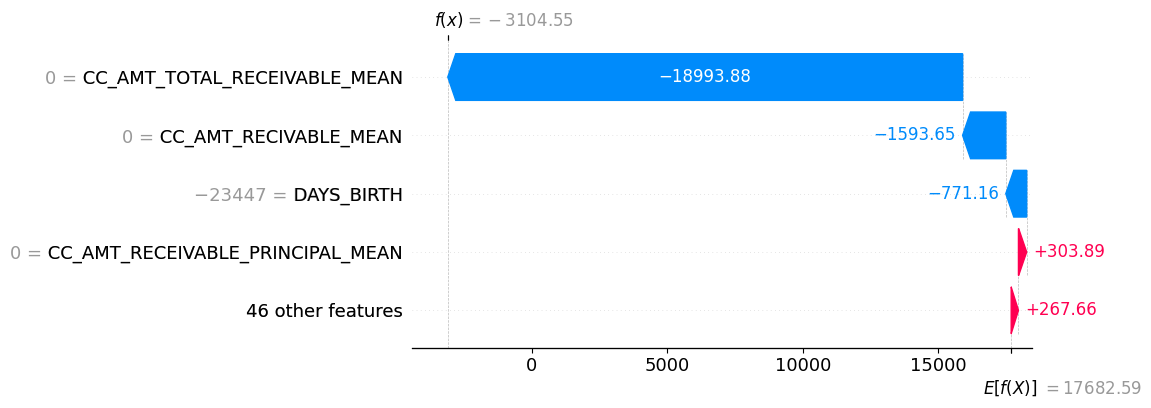

In [ ]:
# 3. SHAP features importance locales (Regression Logistique = log)
# Save de la variable SHAP "log_shap_values" au format binaire (pikle)

# SelectKBest 50 : fit du modèle de régression logistique avec k=50
log_model_final['kbest'].k=50
log_model_final.fit(X_train, y_train)

# Réduction des features X aux 50 KBest features sélectionnées
KBest = log_model_final['kbest']
X_train_new = KBest.fit_transform(X_train, y_train)
#X_test_new = KBest.transform(X_test)
X_test_new = KBest.transform(df_appli_test.drop(['TARGET', 'log_score_pred', 'lgbm_score_pred'], axis=1).values)

# Indexes et libellés des 50 features
cols_idx = KBest.get_support(True)
feats = df_all.drop('TARGET', axis=1)
feats = feats.iloc[:, cols_idx].columns.tolist()

# Init de l'explication SHAP
log = log_model_final['classifier']
log_explainer = LinearExplainer(log, X_train_new)

# Estimation de l'explication SHAP du modèle sur le sous échantillon du TEST set
log_shap_values = log_explainer(X_test_new)
log_shap_values.feature_names = feats

# Save shap_values pour dashboard
with open('log_shap_values.p', 'wb') as file:
    pickle.dump(log_shap_values, file)

# Save features importance (Régression Logistique et LGBM)
df_log_feat_importance = fct_get_feats_importance(log_shap_values, feats)
df_log_feat_importance.to_csv('df_log_feat_importance.csv')

# Analyse de l'impact des features importance locales (ici observation n°3)
f_shap_waterfall_plot(log_shap_values, nb_feats=10, i=3, show=True)
#plt.savefig('log_shap_explainer_local.png')

In [ ]:
# 3. SHAP features importance locales (Light GBM = lgbm)
# Save de la variable SHAP "lgbm_explainer" + "lgbm_shap_values" au format binaire (pikle)

# SelectKBest 50 : fit du modèle LGBM avec k=50
lgbm_model_final['kbest'].k=50
lgbm_model_final.fit(X_train, y_train)

# Entraînement du model à l'explication SHAP sur le TRAIN set
#lgbm_explainer = TreeExplainer(estimator, X_train_new)
lgbm = lgbm_model_final['classifier']
lgbm_explainer = shap_Tree(lgbm)

# Estimation de l'explication SHAP du modèle sur le TEST set
#lgbm_shap_values = lgbm_explainer.shap_values(X_test_new)
lgbm_shap_values = lgbm_explainer(X_test_new)

# Save shap_values
with open('lgbm_explainer.p', 'wb') as file:
    pickle.dump(lgbm_explainer, file)
with open('lgbm_shap_values.p', 'wb') as file:
    pickle.dump(lgbm_shap_values, file)

# Save features importance (LGBM)
df_lgbm_feat_importance = fct_get_feats_importance(lgbm_shap_values, feats)
df_lgbm_feat_importance.to_csv('df_lgbm_feat_importance.csv')

# Analyse de l'impact des features importance locales sur la target pour 1 observation donnée (ici l'observation n°2)
shap_plots._waterfall.waterfall_legacy(lgbm_explainer.expected_value[1],
                                       lgbm_shap_values[2].values[:,0],
                                       feature_names=feats, 
                                       max_display=20)

In [ ]:
# 4. SHAP features importances globales (log) depuis l'échantillon de TRAIN set
# X_test_new = KBest.transform(X_test)
log_shap_values = log_explainer(X_train_new)
log_shap_values.feature_names = feats
summary_plot(log_shap_values, features=X_train_new, feature_names=feats, max_display=50, show=False)
plt.savefig('log_summary_plot.png')
plt.close()

In [ ]:
# 4. SHAP features importance globale (lgbm) depuis l'échantillon de TRAIN set
shap_values = TreeExplainer(lgbm).shap_values(X_train_new)
summary_plot(shap_values[1], features=X_train_new, feature_names=feats, plot_type='violin', max_display=50, show=False)
plt.savefig('lgbm_summary_plot.png')
plt.close()